# Parcial: Gran Escala 

# Parte A - Trabajo con Cluster en EMR, Pyspark y Hadoop

👥 **Integrantes del equipo**:

**Gerardo Rocha Benigno**

**Rodrigo Alejandro Huerta Cruz**

**Daniel Michell Perez Ruiz**

## Pyspark

In [1]:
%%local
%%html
<style>pre { white-space: pre !important; }</style>

In [2]:
%%configure -f
{ "conf":{
          "spark.pyspark.python": "python",
          "spark.pyspark.virtualenv.enabled": "true",
          "spark.pyspark.virtualenv.type":"native",
          "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
         }
}

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName('profeco_etl') \
    .getOrCreate()

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Importación de librerías

In [4]:
spark._sc.install_pypi_package("unidecode")
# spark._sc.install_pypi_package("pandas")
# spark._sc.install_pypi_package("matplotlib", "https://pypi.org/simple")
# spark._sc.install_pypi_package("IPython")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt1/yarn/usercache/livy/appcache/application_1746538606210_0001/container_1746538606210_0001_01_000001/tmp/spark-74384c6d-15be-43d4-85ba-37e08852c02c
    Can't uninstall 'python-dateutil'. No files were found to uninstall.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 2.23.11 requires python-dateutil<=2.9.0,>=2.1, but you have python-dateutil 2.9.0.post0 which is incompatible.


In [5]:
# Librerías pyspark
from pyspark.sql.functions import count as count_, lit, col, sum as sum_, round, row_number, desc, min as min_, countDistinct, when, lower, trim, count, avg, first, array_max, collect_set, max as max_
from pyspark.sql.functions import udf
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Librerías Python (solamente unidecode se ejecutó en pyspark, las demás se realizaron en el proceso de python para generar gráficas y un análisis final)
# from IPython.display import display
import unidecode
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
# import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
import matplotlib.cm as cm

# Librerías AWS
import boto3
import awswrangler as wr
from botocore.config import Config

### Funciones

In [7]:
# UDF para limpiar textos (quitar acentos, apóstrofes y pasar a minúsculas)
def normalizar(texto):
    if texto is None:
        return None
    texto = texto.replace("'", "")  # quitar apóstrofes
    texto = unidecode.unidecode(texto)  # quitar acentos
    return texto.lower()

normalizar_udf = udf(normalizar, StringType())

# Formateador personalizado
def human_format(x, pos):
    if x >= 1e6:
        return f'{x*1.0/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x*1.0/1e3:.0f}k'
    else:
        return int(x)

### Carga el CSV en Spark

In [7]:
schema = StructType([
    StructField('producto', StringType(), True),
    StructField('presentacion', StringType(), True),
    StructField('marca', StringType(), True),
    StructField('categoria', StringType(), True),
    StructField('catalogo', StringType(), True),
    StructField('precio', FloatType(), True),
    StructField('fecharegistro', StringType(), True),
    StructField('cadenacomercial', StringType(), True),
    StructField('giro', StringType(), True),
    StructField('nombrecomercial', StringType(), True),
    StructField('direccion', StringType(), True),
    StructField('estado', StringType(), True),
    StructField('municipio', StringType(), True),
    StructField('latitud', StringType(), True),
    StructField('longitud', StringType(), True),
    StructField('anio', IntegerType(), True)    
])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Carga y subida de datos

#### Post-Limpieza

Aunque se estuvo realizando limpieza desde Bash, hay algunas características que hace falta modificar y limpiar, por lo que con apoyo de las herramientas de pyspark esto se consigue:

In [8]:
# Cargamos los datos de S3, el URI del bucket es s3://itam-analytics-grb/profeco/clean/
# anio es int, precio es float. Todo lo demás podemos tratarlo como string
df_profeco = spark.read \
    .option('header', True) \
    .schema(schema) \
    .csv('s3://itam-analytics-grb/profeco/clean/')


# df_profeco = spark.read.parquet("s3://itam-analytics-danielmichell/examen_arquitectura/parquet/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
df_profeco.show(4)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+--------------------+-------+--------------------+------+-------------+--------------------+--------------------+--------------------+--------------------+------+----------+---------+-----------+--------+----+
|        producto|        presentacion|  marca|           categoria|precio|fecharegistro|     cadenacomercial|                giro|     nombrecomercial|           direccion|estado| municipio|  latitud|   longitud|catalogo|anio|
+----------------+--------------------+-------+--------------------+------+-------------+--------------------+--------------------+--------------------+--------------------+------+----------+---------+-----------+--------+----+
|tortilla de maiz|        1 kg. granel|    s/m|tortillas y deriv...|  22.0|   2019-09-04|tortillerias trad...|        tortillerías|      tortilleria by|othon almada 151;...|sonora|hermosillo|29.103581| -110.96413| basicos|2019|
|          aceite|botella 1 lt. canola| canoil|aceites y grasas ...|  28.9|   2019-09-05

In [ ]:
df_profeco.select("catalogo").distinct().show(20)
df_profeco.select("estado").distinct().show(40)
df_profeco.filter("catalogo = 'medicamentos'")\
.groupBy("marca").count().orderBy(col("count").desc()).show(20,truncate=False)
df_profeco.filter("catalogo = 'medicamentos'")\
.groupBy("producto").count().orderBy(col("count").desc()).show(20,truncate=False)

La limpieza consiste en retirar algunos caracterés como lo son: ',¨ y normalizar las columnas, asignar ciertos articulos a su respectivo sitio, remplazar valores que son iguales o generar nuevas variables que representen estos valores.

In [17]:
# Por si hubo encabezados mal cargados
df_profeco = df_profeco.filter(col('catalogo') != 'catalogo')

# Por si hay virguilillas mal borradas en navideño
df_profeco = df_profeco.withColumn("catalogo", when(col("catalogo").startswith("navide"), "navideno").otherwise(col("catalogo")))
# Aplicar normalización general
df_profeco = df_profeco.withColumn("estado", normalizar_udf(col("estado")))
df_profeco = df_profeco.withColumn("marca", normalizar_udf(col("marca")))
df_profeco = df_profeco.withColumn("catalogo", normalizar_udf(col("catalogo")))
df_profeco = df_profeco.withColumn("producto", normalizar_udf(col("producto")))
df_profeco = df_profeco.withColumn("categoria", normalizar_udf(col("categoria")))

# Homologar marca
df_profeco = df_profeco.withColumn("marca", when(col("marca").isin("s/m", "sm", "sin marca","cualquier marca"), "sin marca").otherwise(col("marca")))

# Homologar catálogo
df_profeco = df_profeco.withColumn("catalogo", when(col("catalogo") == "tenis", "utiles escolares")
                       .when(col("catalogo") == "aeropuertos", "basicos")
                       .otherwise(col("catalogo")))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Observamos que en el catálogo de interés sólo se encuentran dos categorías: medicamentos y art. para el cuidado personal

In [23]:
df_profeco.filter("catalogo = 'medicamentos'")\
.groupBy("categoria").count().orderBy(col("count").desc()).show(50,truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------+--------+
|categoria                     |count   |
+------------------------------+--------+
|medicamentos                  |18539554|
|arts. para el cuidado personal|670365  |
+------------------------------+--------+

In [22]:
df_profeco.show(4,truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+----------------------+---------+---------------------------------+------+-------------+--------------------------+-------------------------------------+-----------------------+-----------------------------------------------------------------------------------+------+----------+---------+-----------+--------+----+
|producto        |presentacion          |marca    |categoria                        |precio|fecharegistro|cadenacomercial           |giro                                 |nombrecomercial        |direccion                                                                          |estado|municipio |latitud  |longitud   |catalogo|anio|
+----------------+----------------------+---------+---------------------------------+------+-------------+--------------------------+-------------------------------------+-----------------------+-----------------------------------------------------------------------------------+------+----------+---------+-----------+--------+----

**Guarda el CSV como parquet en S3, particionalo por catalogo y año.**

In [24]:
# Guardamos en parquet, comprimido con snappy y particionando por catalogo y anio
df_profeco.write\
    .mode('overwrite') \
    .option('compression','snappy') \
    .partitionBy('catalogo', 'anio') \
    .parquet('s3://itam-analytics-danielmichell/examen_arquitectura/parquet_clean/')


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
# Borramos el dataset, ya que lo vamos a cargar con parquet
del df_profeco

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Carga el parquet en Pyspark

Y a partir de el dataframe cargado se prosigue a contestar las preguntas

In [25]:
# Cargamos el parquet. 
df_parquet = spark.read.parquet('s3://itam-analytics-danielmichell/examen_arquitectura/parquet_clean/')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Preguntas Sección A

**TODOS LOS CATÁLOGOS** 

Contesta las siguientes preguntas utilizando PySpark. Realiza el siguiente análisis (por año) y sobre todos los catálogos. Imprimiremos todas las respuestas en la consola.

In [26]:
path_save = "s3://itam-analytics-danielmichell/examen_arquitectura/salidas/"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 1. ¿Cuántos catálogos diferentes tenemos?

In [27]:
# 1. ¿Cuántos catálogos diferentes tenemos?

conteo_anio_cat = df_parquet.groupBy('anio', 'catalogo').count().orderBy('anio')

# Creamos un dataset que contiene el conteo por año (Esto nos permitirá realizar un conteo de catalogos por año)
catalogos_por_anio = conteo_anio_cat.select("anio", "catalogo") \
    .groupBy("anio") \
    .agg(count_("catalogo").alias("conteo_anio"))

# Hacemos un join
conteo_anio_cat = conteo_anio_cat \
    .join(catalogos_por_anio, on="anio", how="left") \
    .orderBy('anio') \
    .withColumnRenamed('count', 'cont_anio_catalogo')

# Guardamos la salida (Vamos a usarlo más adelante)
conteo_anio_cat.coalesce(1).write \
    .mode("overwrite") \
    .option("header", True) \
    .csv(path_save+"p1/")


# Imprimimos el output
conteo_anio = conteo_anio_cat \
    .select('anio', 'conteo_anio') \
    .distinct() \
    .orderBy('anio')


print("El numero de catalogos por anio puede observarse en la siguiente tabla:")
conteo_anio.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

El numero de catalogos por anio puede observarse en la siguiente tabla:
+----+-----------+
|anio|conteo_anio|
+----+-----------+
|2018|          9|
|2019|          9|
|2020|          9|
|2021|          9|
|2022|          9|
|2023|          9|
|2024|          9|
+----+-----------+

En todos los años tenemos el mismo número de categorías, en este caso, 9 categorías y está es la distribución de los catálogos

In [28]:
df_parquet.select('catalogo')\
          .groupBy('catalogo')\
          .count()\
          .withColumnRenamed('count', 'cont_catalogo')\
          .orderBy(col('cont_catalogo').desc()).show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------------+
|catalogo           |cont_catalogo|
+-------------------+-------------+
|basicos            |48018962     |
|medicamentos       |19209919     |
|electrodomesticos  |7170897      |
|frutas y legumbres |5038463      |
|utiles escolares   |2951734      |
|mercados           |2237374      |
|juguetes           |1432179      |
|pescados y mariscos|568800       |
|navideno           |236510       |
+-------------------+-------------+

In [13]:
df = pd.read_csv("PA_p1.csv")
df = df[["catalogo","cont_anio_catalogo"]].groupby(["catalogo"]).sum().reset_index().sort_values(by=["cont_anio_catalogo"],ascending=False)
df

catalogo  cont_anio_catalogo
0              basicos            48018962
4         medicamentos            19209919
1    electrodomesticos             7170897
2   frutas y legumbres             5038463
8     utiles escolares             2951734
5             mercados             2237374
3             juguetes             1432179
7  pescados y mariscos              568800
6             navideno              236510

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/187846302.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, y="catalogo", x="cont_catalogo", palette="crest")


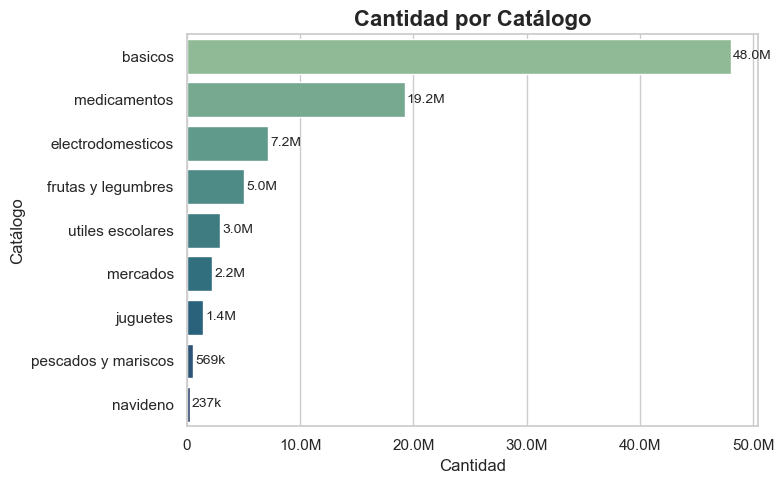

In [16]:
df = pd.read_csv("PA_p1.csv")
df = (df[["catalogo","cont_anio_catalogo"]]
      .groupby(["catalogo"]).sum().reset_index().sort_values(by=["cont_anio_catalogo"],ascending=False)
      .rename(columns={"cont_anio_catalogo":"cont_catalogo"})
)
# Configurar el estilo de seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))

# Crear gráfico de barras
ax = sns.barplot(data=df, y="catalogo", x="cont_catalogo", palette="crest")

ax.xaxis.set_major_formatter(ticker.FuncFormatter(human_format))

# Añadir etiquetas y título
ax.set_title("Cantidad por Catálogo", fontsize=16, weight='bold')
ax.set_xlabel("Cantidad", fontsize=12)
ax.set_ylabel("Catálogo", fontsize=12)

# Mostrar valores sobre las barras
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 200000, p.get_y() + p.get_height() / 2,
            human_format(width, None), va='center', fontsize=10)

plt.tight_layout()
plt.show()

Principalmente en el catálogo de básicos y medicamentos, como se esperaría, por ser lo más escencial

### 2. ¿Cuáles son las 20 categorías por catálogo con más observaciones?

In [29]:
# 2. ¿Cuáles son las 20 categorías por catálogo con más observaciones?
# Guarda la salida de este query en tu bucket de S3, lo necesitaremos más adelante."

# Generamos dataframe con conteo por categoria
conteo_categoria_anio = df_parquet.groupBy('anio', 'catalogo', 'categoria') \
    .count() \
    .withColumnRenamed('count', 'cont_anio_categoria')

# Unimos con dataframe 
conteo_categoria_anio = conteo_categoria_anio \
    .join(conteo_anio_cat, on=['anio', 'catalogo'], how = 'left') \
    .select('anio', 'catalogo', 'categoria', 'cont_anio_catalogo', 'cont_anio_categoria') \
    .orderBy('anio', 'catalogo', 'cont_anio_categoria')

# Guardamos dataframe completo
conteo_categoria_anio.coalesce(1).write \
    .mode("overwrite") \
    .option("header", True) \
    .csv(path_save+"p2/completo")

# Creamoslas dataframe con 20 categórias solamente

# Creamos ventana para realizar un orden de mayor a menor en cont_anio_categoria 
ventana = Window.partitionBy("anio", "catalogo").orderBy(desc("cont_anio_categoria"))

# Aplicamos ventana, nos quedamos con el top20 de categorías por catalogo y anio
conteo_top_20 = conteo_categoria_anio \
    .withColumn('orden_categoria', row_number().over(ventana)) \
    .filter(col('orden_categoria') <= 20) \
    .orderBy('anio','catalogo', 'orden_categoria')

# Creamos columna de porcentaje
conteo_top_20 = conteo_top_20.withColumn(
    "porcentaje",
    round(col("cont_anio_categoria") / col("cont_anio_catalogo") * 100, 2)
)

# Guardamos dataframe con el top 20
conteo_top_20.coalesce(1).write \
    .mode("overwrite") \
    .option("header", True) \
    .csv(path_save+"p2/top_20")

print("Para conocer por anio y por catalogo las 20 categorias con mas observaciones, vamos a generar una grafica de pastel para cada catalogo y cada anio")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Para conocer por anio y por catalogo las 20 categorias con mas observaciones, vamos a generar una grafica de pastel para cada catalogo y cada anio

También se muestra las 20 cateogrías más observados por catálogo

Aquí se muestra un ejemplo de como se ve un conteo del top 20 y cuanto es respecto al total de la categoría en el año

In [34]:
conteo_top_20_glob = conteo_top_20.groupBy("catalogo", "categoria") \
    .agg(sum_("cont_anio_categoria").alias("cont_anio_categoria"))
window = Window.partitionBy("catalogo").orderBy(conteo_top_20_glob["cont_anio_categoria"].desc())
conteo_top_20_glob = conteo_top_20_glob.withColumn("orden_categoria", row_number().over(window))
conteo_top_20_glob = conteo_top_20_glob.filter("orden_categoria <= 20")
conteo_top_20_glob.orderBy("catalogo").show(50,truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----------------------------------+-------------------+---------------+
|catalogo          |categoria                          |cont_anio_categoria|orden_categoria|
+------------------+-----------------------------------+-------------------+---------------+
|basicos           |arts. para el cuidado personal     |6490858            |1              |
|basicos           |refrescos envasados                |3709951            |2              |
|basicos           |derivados de leche                 |3453506            |3              |
|basicos           |detergentes y productos similares  |3304152            |4              |
|basicos           |carnes frias secas y embutidos     |3038610            |5              |
|basicos           |arts. de papel p/higiene personal  |2877146            |6              |
|basicos           |chocolates y golosinas             |2620076            |7              |
|basicos           |condimentos                        |2570467       

In [35]:
# Guardamos dataframe con el top 20 global
conteo_top_20_glob.coalesce(1).write \
    .mode("overwrite") \
    .option("header", True) \
    .csv(path_save+"p2/top_20_global")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
conteo_top_20.show(40,truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+------------------+----------------------------------+------------------+-------------------+---------------+----------+
|anio|catalogo          |categoria                         |cont_anio_catalogo|cont_anio_categoria|orden_categoria|porcentaje|
+----+------------------+----------------------------------+------------------+-------------------+---------------+----------+
|2018|basicos           |arts. para el cuidado personal    |8804761           |1159575            |1              |13.17     |
|2018|basicos           |detergentes y productos similares |8804761           |669682             |2              |7.61      |
|2018|basicos           |derivados de leche                |8804761           |668873             |3              |7.6       |
|2018|basicos           |refrescos envasados               |8804761           |636955             |4              |7.23      |
|2018|basicos           |carnes frias secas y embutidos    |8804761           |593642             |5           

En ambas tablas se tiene una saturación de datos, para ilustrar y entender un poco mejor esto, se muestran 2 gráficos, uno de las 20 categorías con más observaciones y otro de la principal cateogría por catálogo:

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3823912250.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_top20, y="categoria", x="cont_anio_categoria", palette="flare")


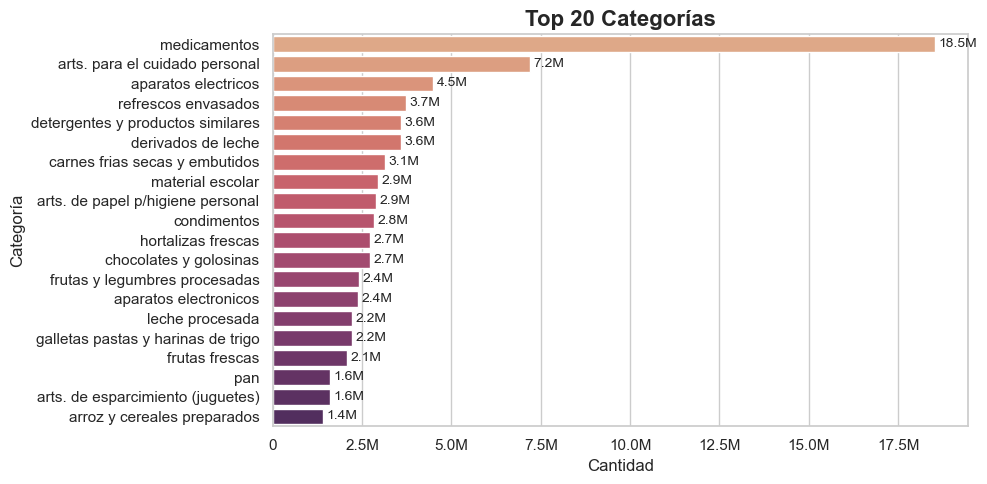

In [30]:
df = pd.read_csv("top_20_global.csv")
df_top20 = (df[["categoria","cont_anio_categoria"]]
 .groupby(["categoria"]).sum().reset_index().sort_values(by=["cont_anio_categoria"],ascending=False).reset_index(drop=True)
  .iloc[0:20]
)

# Estilo
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))

# Gráfico de barras
ax = sns.barplot(data=df_top20, y="categoria", x="cont_anio_categoria", palette="flare")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(human_format))

# Etiquetas y título
ax.set_title("Top 20 Categorías", fontsize=16, weight='bold')
ax.set_xlabel("Cantidad", fontsize=12)
ax.set_ylabel("Categoría", fontsize=12)

# Mostrar valores sobre las barras
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 100000, p.get_y() + p.get_height() / 2,
            human_format(width, None), va='center', fontsize=10)

plt.tight_layout()
plt.show()

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3561798823.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_orden_categoria, y="categoria", x="cont_anio_categoria", palette="mako")


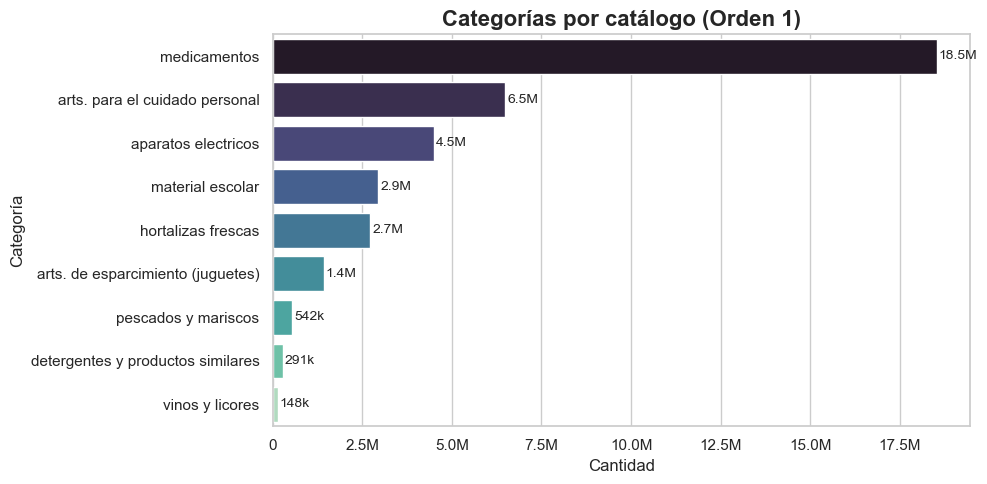

In [44]:
df_orden_categoria = df[df["orden_categoria"]==1].sort_values(["cont_anio_categoria"],ascending=False)[["catalogo","categoria","cont_anio_categoria"]]

# Estilo
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))

# Gráfico de barras
ax = sns.barplot(data=df_orden_categoria, y="categoria", x="cont_anio_categoria", palette="mako")

ax.xaxis.set_major_formatter(ticker.FuncFormatter(human_format))

# Etiquetas
ax.set_title("Categorías por catálogo (Orden 1)", fontsize=16, weight='bold')
ax.set_xlabel("Cantidad", fontsize=12)
ax.set_ylabel("Categoría", fontsize=12)

# Valores sobre las barras
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 50000, p.get_y() + p.get_height() / 2,
            human_format(width, None), va='center', fontsize=10)

plt.tight_layout()
plt.show()

**Conclusiones**

Las dos gráficas muestran las principales categorías de productos. En ambas, medicamentos destaca como la categoría con mayor cantidad, muy por encima del resto. Sin embargo, en el conjunto general de las 20 principales categorías, se observa una distribución más amplia y equilibrada entre otras como cuidado personal, aparatos eléctricos y refrescos, lo que refleja una diversidad en el consumo.

Por otro lado, al filtrar por orden_categoria == 1, el enfoque se estrecha y se nota una concentración más marcada en las categorías esenciales o prioritarias, como material escolar y hortalizas frescas. Las categorías de menor volumen como vinos y licores y detergentes siguen presentes, pero con un peso mucho menor.

### 3. ¿Tenemos datos de todos los estados del país? De no ser así, ¿cuáles faltan?

In [37]:
# 3. ¿Tenemos datos de todos los estados del país? De no ser así, ¿cuáles faltan?
# No existe Distrito Federal, ya se llama Ciudad de México en todas las bases. Hay 32 valores distintos de estado

# Creamos un dataframe con el conteo de observaciones por estado y anio. 
obs_estado = df_parquet \
    .groupBy('estado', 'anio') \
    .count() \
    .orderBy('estado', 'anio') \
    .withColumnRenamed('count','cont_est_anio')

# Contamos en cuantos años aparece un estado
obs_anios_est = obs_estado \
    .select('estado', 'anio') \
    .distinct() \
    .groupBy('estado') \
    .agg(countDistinct('anio').alias('num_anios_est')) \
    .orderBy('estado') 

# Agregamos columna que diga "completo" o "faltante" dependiendo de si hay observaciones en los 7 años o no.
obs_anios_est = obs_anios_est.withColumn('estatus', 
                                        when(col('num_anios_est')==7, 'completo').otherwise('faltante')
                                        )

# Guardamos dataframes
obs_estado.coalesce(1).write \
    .mode("overwrite") \
    .option("header", True) \
    .csv(path_save+"p3/obs_estado") 

obs_anios_est.coalesce(1).write \
    .mode("overwrite") \
    .option("header", True) \
    .csv(path_save+"p3/obs_anios_est") 

print("Existen 32 entidades federativas y existe informacion de 7 anios (2018-2024). En la siguiente tabla se muestra el numero de anios en los que existe informacion de cada entidad federativa.\nEn ella se observa que falta informacion de Colima y Nayarit en cuatro anios.")
obs_anios_est.show(35)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Existen 32 entidades federativas y existe informacion de 7 anios (2018-2024). En la siguiente tabla se muestra el numero de anios en los que existe informacion de cada entidad federativa.
En ella se observa que falta informacion de Colima y Nayarit en cuatro anios.
+--------------------+-------------+--------+
|              estado|num_anios_est| estatus|
+--------------------+-------------+--------+
|      aguascalientes|            7|completo|
|     baja california|            7|completo|
| baja california sur|            7|completo|
|            campeche|            7|completo|
|             chiapas|            7|completo|
|           chihuahua|            7|completo|
|    ciudad de mexico|            7|completo|
|coahuila de zaragoza|            7|completo|
|              colima|            3|faltante|
|             durango|            7|completo|
|    estado de mexico|            7|completo|
|          guanajuato|            7|completo|
|            guerrero|            7|completo

In [46]:
obs_anios_est = pd.read_csv("obs_anios_est.csv")
obs_anios_est["estado_norm"] = obs_anios_est["estado"]
obs_anios_est.head(2)

estado  num_anios_est   estatus      estado_norm
0   aguascalientes              7  completo   aguascalientes
1  baja california              7  completo  baja california

In [47]:
# Cargar el GeoJSON de los estados de México
estados_mex = gpd.read_file("Mexico_estados.json")
# Leer el shapefile que ya cargaste (asegúrate de tenerlo como `estados_mex`)
estados_mex["estado_norm"] = estados_mex["ESTADO"].str.lower().str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")
estados_mex["estado_norm"] = estados_mex["estado_norm"].replace({"michoacan":"michoacan de ocampo","mexico":"estado de mexico","coahuila":"coahuila de zaragoza"})

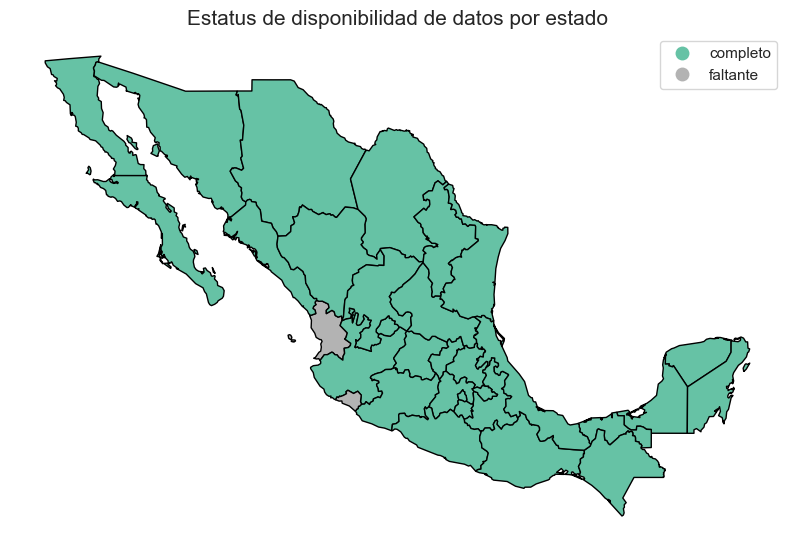

In [48]:
# Unir por nombre normalizado
mapa = estados_mex.merge(obs_anios_est, on="estado_norm", how="left")
# Graficar el mapa con estatus
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
mapa.plot(column='estatus', cmap='Set2', legend=True, edgecolor='black', ax=ax)
ax.set_title("Estatus de disponibilidad de datos por estado", fontsize=15)
ax.axis('off')
plt.show()


**Conclusiones**

El análisis de disponibilidad de datos por estado muestra que de las 32 entidades federativas, 30 cuentan con información completa para los 7 años analizados (2018–2024). Solo Colima y Nayarit presentan datos incompletos, con información disponible en solo 3 de los 7 años, lo cual representa una limitación importante para análisis comparativos a nivel nacional. La cobertura general es alta, pero estos dos casos deben considerarse en estudios que requieran consistencia temporal.

### 4. ¿Cuántas observaciones tenemos por estado?

In [38]:
# Ya tenemos este dataframe.

# Guardamos de nuevo por sanidad mental
obs_estado.coalesce(1).write \
    .mode("overwrite") \
    .option("header", True) \
    .csv(path_save+"p4/obs_estado")

# Generamos dataframe por estado con suma de cont_est_anio
obs_estado_tota = obs_estado \
    .select('estado','cont_est_anio') \
    .groupBy('estado') \
    .agg(sum_('cont_est_anio').alias('total_estado'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
obs_estado = pd.read_csv("./csvs_PA/obs_estado.csv")
obs_estado_tota = obs_estado.groupby(["estado"]).agg({"cont_est_anio":["sum"]}).reset_index()
obs_estado_tota.columns = ["estado","observaciones"]
obs_estado_tota["estado_norm"] = obs_estado_tota["estado"]
# Unir por nombre normalizado
mapa = estados_mex.merge(obs_estado_tota, on="estado_norm", how="left")

In [53]:
obs_estado_tota[["estado","observaciones"]]


estado  observaciones
0         aguascalientes        1668545
1        baja california        1513987
2    baja california sur        1477127
3               campeche        1765074
4                chiapas        1163732
5              chihuahua        1798478
6       ciudad de mexico       17968798
7   coahuila de zaragoza        1616519
8                 colima         560520
9                durango        1616227
10      estado de mexico       12537548
11            guanajuato        3330005
12              guerrero         981815
13               hidalgo         868532
14               jalisco        4182990
15   michoacan de ocampo        1538864
16               morelos        1026711
17               nayarit         266068
18            nuevo leon        3358320
19                oaxaca        1536513
20                puebla        2345346
21             queretaro        2534860
22          quintana roo        2820066
23       san luis potosi        1712178
24               sinaloa        1280672
25                sonora        1881988
26               tabasco        2463009
27            tamaulipas        1892753
28              tlaxcala        1804101
29              veracruz        2657211
30               yucatan        2324835
31             zacatecas        2371446

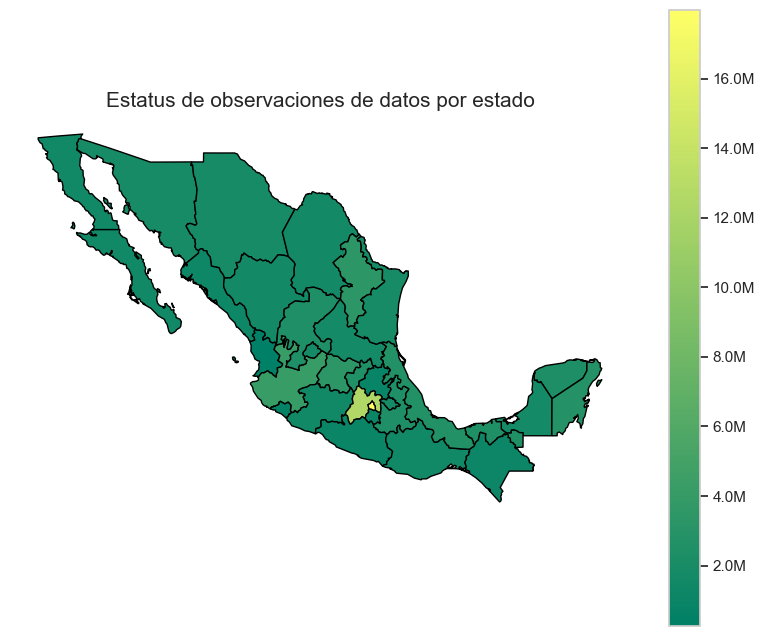

In [50]:
# Plot con formateo de colorbar
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
mapa_plot = mapa.plot(
    column='observaciones',
    cmap='summer',
    legend=True,
    edgecolor='black',
    ax=ax
)

# Formato de la leyenda
cbar = mapa_plot.get_figure().axes[-1]  # Accede al eje del colorbar
cbar.yaxis.set_major_formatter(mticker.FuncFormatter(human_format))

# Títulos y estilo
ax.set_title("Estatus de observaciones de datos por estado", fontsize=15)
ax.axis('off')
plt.show()

In [39]:
df_estados_anio = obs_estado \
    .groupBy('estado') \
    .pivot('anio') \
    .agg(sum_('cont_est_anio')) \
    .fillna(0) \
    .orderBy('estado')

print("La tabla siguiente muestra el numero de observaciones por estado y por anio")
df_estados_anio.show(35)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

La tabla siguiente muestra el numero de observaciones por estado y por anio
+--------------------+-------+-------+-------+-------+-------+-------+------+
|              estado|   2018|   2019|   2020|   2021|   2022|   2023|  2024|
+--------------------+-------+-------+-------+-------+-------+-------+------+
|      aguascalientes| 235847| 289973| 216598| 240772| 291820| 313809| 79726|
|     baja california| 619093| 165344| 195002| 104216| 160203| 209715| 60414|
| baja california sur| 163771| 135558| 244874| 283821| 282548| 291569| 74986|
|            campeche| 270889| 273786| 253009| 289282| 298464| 303525| 76119|
|             chiapas| 360125| 236768| 124094| 164396| 164801|  88692| 24856|
|           chihuahua| 401630| 264343|   7797| 182849| 385359| 442131|114369|
|    ciudad de mexico|2492481|2495784|2446252|3062808|3355847|3320792|794834|
|coahuila de zaragoza| 345559| 271376| 226226| 228360| 232422| 246396| 66180|
|              colima| 262907| 283025|  14588|      0|      0|    

La Ciudad de México y el Estado de México concentran la mayoría de observaciones, con más de 17 y 12 millones respectivamente, reflejando su tamaño y actividad. En contraste, Colima y Nayarit tienen muy pocas observaciones (menos de 600 mil y 300 mil), debido a que solo tienen datos en 3 de los 7 años. Otros estados con caídas notables en ciertos años son Hidalgo, Sinaloa y Sonora. Esto indica que, aunque la mayoría de estados tienen datos consistentes, hay algunos con cobertura limitada que deben tomarse en cuenta en análisis comparativos.

### 5. De cada estado obten: el número de catalogos diferentes por año, ¿ha aumentado el número de catálogos con el tiempo? 

In [40]:
# Vamos a contar también el número de categorias, para reralizar un análisis más extenso

# Primero creamos dataframe de numero de catalogos por estado y anio
num_catalogo_estado = df_parquet \
    .select('anio', 'estado', 'catalogo') \
    .groupBy('anio', 'estado') \
    .agg(countDistinct('catalogo').alias('num_catalogos')) \
    .orderBy('estado', 'anio')

# Después creamos dataframe de número de categorias por estado y anio
num_categoria_estado = df_parquet \
    .select('anio', 'estado', 'categoria') \
    .groupBy('anio', 'estado') \
    .agg(countDistinct('categoria').alias('num_categorias')) \
    .orderBy('estado', 'anio')

# Realizamos join
df_completo =  num_categoria_estado \
    .join(num_catalogo_estado, on=['anio', 'estado'], how='inner') \
    .orderBy('estado', 'anio')

# Guardamos el dataframe
df_completo.coalesce(1).write \
    .mode("overwrite") \
    .option("header", True) \
    .csv(path_save+"p5/metricas_estado")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
df_completo_pivot = df_completo \
    .groupBy('estado') \
    .pivot('anio') \
    .agg(sum_('num_catalogos')) \
    .fillna(0)\
    .orderBy('estado')

print('La tabla de abajo muestra el numero de catalogos por anio de cada estado. En ella se muestra que el numero de catalogos vaira con el tiempo, pero no se ve una tendencia ni creciente ni decreciente clara.')
df_completo_pivot.show(35)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

La tabla de abajo muestra el numero de catalogos por anio de cada estado. En ella se muestra que el numero de catalogos vaira con el tiempo, pero no se ve una tendencia ni creciente ni decreciente clara.
+--------------------+----+----+----+----+----+----+----+
|              estado|2018|2019|2020|2021|2022|2023|2024|
+--------------------+----+----+----+----+----+----+----+
|      aguascalientes|   9|   9|   9|   9|   9|   9|   8|
|     baja california|   9|   9|   9|   8|   9|   9|   9|
| baja california sur|   9|   9|   9|   9|   9|   9|   9|
|            campeche|   9|   9|   9|   9|   9|   9|   8|
|             chiapas|   9|   9|   9|   9|   9|   8|   7|
|           chihuahua|   9|   9|   5|   9|   9|   9|   9|
|    ciudad de mexico|   9|   9|   9|   9|   9|   9|   9|
|coahuila de zaragoza|   9|   9|   9|   9|   9|   9|   9|
|              colima|   9|   9|   4|   0|   0|   0|   0|
|             durango|   9|   9|   9|   9|   9|   9|   8|
|    estado de mexico|   9|   9|   9|   9|

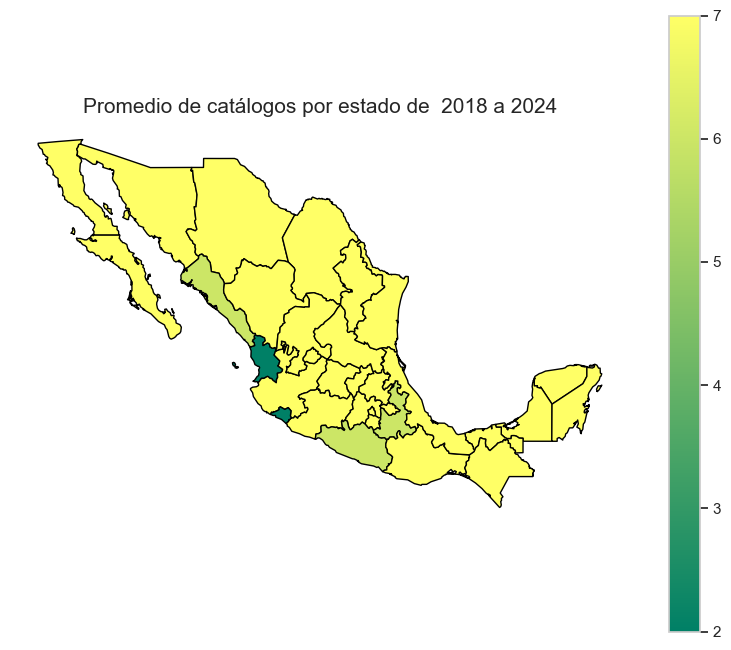

In [64]:
metricas_estado = pd.read_csv("./csvs_PA/metricas_estado.csv")
metricas_estado = metricas_estado[["estado","num_catalogos"]].groupby(["estado"]).sum().reset_index()
metricas_estado["prop_catalogos"] = round(metricas_estado["num_catalogos"]/9)
metricas_estado["estado_norm"] = metricas_estado["estado"]
mapa = estados_mex.merge(metricas_estado, on="estado_norm", how="left")
# Plot con formateo de colorbar
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
mapa_plot = mapa.plot(
    column='prop_catalogos',
    cmap='summer',
    legend=True,
    edgecolor='black',
    ax=ax
)

# Formato de la leyenda
cbar = mapa_plot.get_figure().axes[-1]  # Accede al eje del colorbar
cbar.yaxis.set_major_formatter(mticker.FuncFormatter(human_format))
# Títulos y estilo
ax.set_title("Promedio de catálogos por estado de  2018 a 2024", fontsize=15)
ax.axis('off')
plt.show()


La mayoría de los estados mantuvieron un promedio cercano a 9 catálogos por año, lo que indica una cobertura amplia y constante entre 2018 y 2024. Sin embargo, Colima y Nayarit destacan por tener los promedios más bajos, con menos de 3 catálogos por año, debido a la ausencia de datos en los últimos periodos. También se observan caídas puntuales en estados como Sinaloa, Sonora, Morelos y Chihuahua, lo cual podría afectar la comparabilidad o análisis longitudinal en esos casos.

## PREGUNTAS CON DATAFRAME DE MEDICAMENTOS

**Utilizando Spark contesta las siguientes preguntas a partir del catálogo que le tocó a tu equipo. Recuerda trabajar en el archivo con los datos particionados de otra manera tus queries van a tardar mucho.**

El catálogo asignado a nuestro equipo es "Medicamentos". Este catálogo muestra un bajo número de valores distintos en el campo 'marca' debido a que más del 95% de las observaciones tiene como valor 's/m', que es probable que correspondan a medicamentos genéricos. Debido a lo anterior, en su lugar las preguntas planteadas originalmente se harán en función del campo 'producto'.

La tabla de abajo muestra nuestra justificación.

In [42]:
df_parquet_meds = spark.read.parquet('s3://itam-analytics-danielmichell/examen_arquitectura/parquet_clean/catalogo=medicamentos/')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
df_justificacion = df_parquet_meds \
    .groupBy('marca') \
    .count()

num_obs= df_parquet_meds \
    .select('marca') \
    .count()

df_justificacion = df_justificacion.withColumn(
    "porcentaje", round(col("count") / lit(num_obs) * 100, 2)
)

df_justificacion.orderBy(col("count").desc()).show(80, truncate=False)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------+--------+----------+
|marca                   |count   |porcentaje|
+------------------------+--------+----------+
|sin marca               |18254383|95.03     |
|le roy                  |164699  |0.86      |
|zuum                    |105307  |0.55      |
|omron                   |80771   |0.42      |
|medimart                |70538   |0.37      |
|dalux                   |68765   |0.36      |
|protec                  |62063   |0.32      |
|ensure                  |49223   |0.26      |
|quality day             |39406   |0.21      |
|nebucor                 |31920   |0.17      |
|escudo antibacterial    |30972   |0.16      |
|vitascom                |30272   |0.16      |
|curitas                 |29303   |0.15      |
|soriana                 |26029   |0.14      |
|inhala care  o home care|21623   |0.11      |
|zuum. klin              |18959   |0.1       |
|microlife               |18236   |0.09      |
|3m. nexcare             |15332   |0.08      |
|citizen     

El 95% de los datos pertenecen a sin marca

### 1. ¿Cuántos productos diferentes tiene tu categoria?

In [44]:
# Número de productos por total
productos_total = df_parquet_meds \
    .select('producto') \
    .distinct() \
    .count()

print(f"En el dataset de medicamentos existen {productos_total} productos distintos, sin distincion de anio.")


# Número de productos por anio
df_marcas_anio = df_parquet_meds \
    .groupBy('anio') \
    .agg(countDistinct('producto').alias('num_producto')) \
    .orderBy('anio')


print("\nPor anio, la evolucion de productos distintos se muestra en la tabla de abajo.")
df_marcas_anio.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

En el dataset de medicamentos existen 379 productos distintos, sin distincion de anio.

Por anio, la evolucion de productos distintos se muestra en la tabla de abajo.
+----+------------+
|anio|num_producto|
+----+------------+
|2018|         354|
|2019|         355|
|2020|         379|
|2021|         379|
|2022|         379|
|2023|         379|
|2024|         379|
+----+------------+

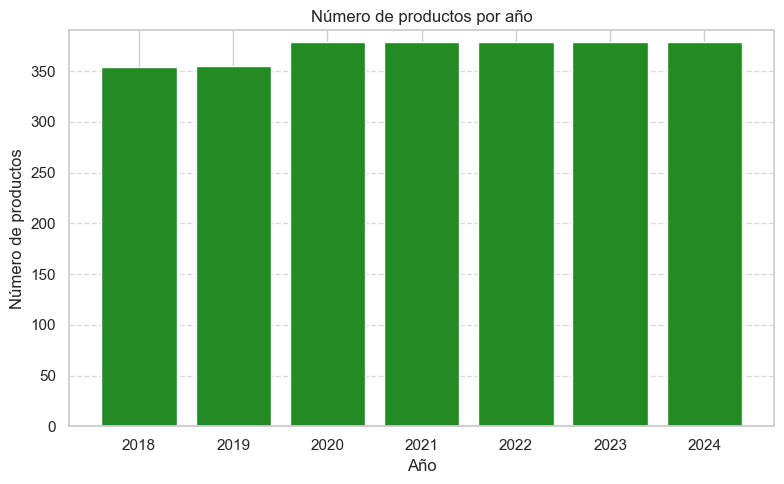

In [65]:
# Datos
anios = [2018, 2019, 2020, 2021, 2022, 2023, 2024]
num_productos = [354, 355, 379, 379, 379, 379, 379]

# Crear gráfico
plt.figure(figsize=(8, 5))
plt.bar(anios, num_productos, color='forestgreen')
plt.title("Número de productos por año")
plt.xlabel("Año")
plt.ylabel("Número de productos")
plt.xticks(anios)
plt.ylim(0, 390)  # para resaltar diferencias
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [45]:
df_justificacion = df_parquet_meds \
    .groupBy('producto') \
    .count()

num_obs= df_parquet_meds \
    .select('producto') \
    .count()

df_justificacion = df_justificacion.withColumn(
    "porcentaje", round(col("count") / lit(num_obs) * 100, 2)
)

df_justificacion.orderBy(col("count").desc()).show(80, truncate=False)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------+------+----------+
|producto                      |count |porcentaje|
+------------------------------+------+----------+
|gel antibacterial             |194437|1.01      |
|tabcin                        |177187|0.92      |
|cialis                        |164696|0.86      |
|cubrebocas                    |162553|0.85      |
|cafiaspirina                  |157576|0.82      |
|celestamine-ns                |156591|0.82      |
|micardis                      |147254|0.77      |
|lyrica                        |147096|0.77      |
|celebrex                      |146797|0.76      |
|lexapro                       |137216|0.71      |
|alevian duo                   |127077|0.66      |
|levitra                       |120184|0.63      |
|amoxicilina; acido clavulanico|111811|0.58      |
|dolo-neurobion forte          |108700|0.57      |
|tempra                        |108515|0.56      |
|aspirina                      |107581|0.56      |
|nexium-mups                   

Existe una distribución mucho más uniforme de cada producto

### 2. ¿Cuál es el producto con mayor precio? ¿En qué estado?

In [47]:
df_mayor_precio = df_parquet_meds\
    .select('estado', 'producto', 'precio', 'anio')\
    .groupBy('estado', 'producto', 'anio')\
    .agg(max_('precio').alias('precio'))\
    .orderBy(col('precio').desc())

print("El producto con el mayor precio es Arava, el cual tiene un precio de 5275.0")
print("Este producto se vendió a ese precio en Baja California, Guerrero y Chihuahua en 2024")
df_mayor_precio.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

El producto con el mayor precio es Arava, el cual tiene un precio de 5275.0
Este producto se vendi? a ese precio en Baja California, Guerrero y Chihuahua en 2024
+--------------------+--------+----+------+
|              estado|producto|anio|precio|
+--------------------+--------+----+------+
|           chihuahua|   arava|2024|5275.0|
|            guerrero|   arava|2024|5275.0|
|     baja california|   arava|2024|5275.0|
|          guanajuato|   arava|2024|5040.0|
|          nuevo leon|   arava|2024|5040.0|
|          nuevo leon|   arava|2023|5040.0|
|     san luis potosi|   arava|2024|5040.0|
|          tamaulipas|   arava|2024|5040.0|
|coahuila de zaragoza|   arava|2024|5040.0|
|      aguascalientes|   arava|2023|5040.0|
|      aguascalientes|   arava|2024|5040.0|
|             durango|   arava|2024|5040.0|
|              sonora|   arava|2024|5040.0|
|          tamaulipas|   arava|2023|5040.0|
|             jalisco|   arava|2024|5040.0|
|           queretaro|   arava|2024|5040.0|
| 

### 3. ¿Cuál es la marca con menor precio en CDMX?

In [48]:
df_menor_precio_cdmx = df_parquet_meds.filter("estado = 'ciudad de mexico'")\
               .select("producto","anio","precio")\
               .groupBy("producto","anio")\
               .agg(min_('precio').alias('precio'))\
               .orderBy('precio')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
df_menor_precio_cdmx.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+----+------+
|         producto|anio|precio|
+-----------------+----+------+
|     ampliron duo|2023|   5.0|
| guantes de latex|2020|  5.21|
|gel antibacterial|2021|   5.4|
|gel antibacterial|2020|   6.0|
| metamizol sodico|2021|  6.63|
+-----------------+----+------+
only showing top 5 rows

In [49]:
print("El articulo con menor precio en Ciudad de México es 'Ampliron Duo' con un precio de 5 pesos en 2023")
df_menor_precio_cdmx.orderBy('precio').show(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

El articulo con menor precio en Ciudad de M?xico es 'Ampliron Duo' con un precio de 5 pesos en 2023
+------------+----+------+
|    producto|anio|precio|
+------------+----+------+
|ampliron duo|2023|   5.0|
+------------+----+------+
only showing top 1 row

menor precio por año general

In [52]:
df_menor_precio = df_parquet_meds\
               .select("producto","anio","precio")\
               .groupBy("producto","anio")\
               .agg(min_('precio').alias('precio'))\
               .orderBy('precio')
window = Window.partitionBy("anio").orderBy(col("precio").asc())
df_ranked = df_menor_precio.withColumn("rank", row_number().over(window))
df_menor_por_anio = df_ranked.filter(col("rank") == 1).drop("rank")
df_menor_por_anio.show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+----+------+
|producto              |anio|precio|
+----------------------+----+------+
|paracetamol           |2018|5.0   |
|clorfenamina compuesta|2019|6.5   |
|guantes de latex      |2020|4.5   |
|cubrebocas            |2021|4.95  |
|clorfenamina compuesta|2022|6.0   |
|ampliron duo          |2023|5.0   |
|alcohol               |2024|7.01  |
+----------------------+----+------+

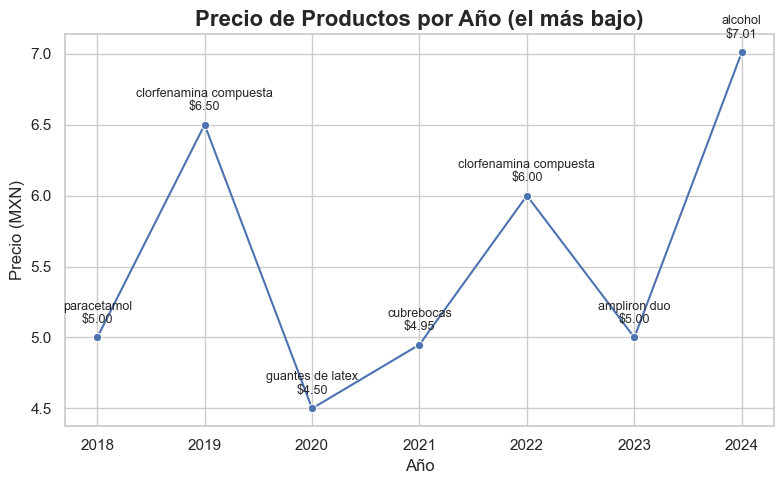

In [70]:
df_precios = pd.DataFrame({
    "producto": [
        "paracetamol", "clorfenamina compuesta", "guantes de latex", "cubrebocas",
        "clorfenamina compuesta", "ampliron duo", "alcohol"
    ],
    "anio": [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    "precio": [5.0, 6.5, 4.5, 4.95, 6.0, 5.0, 7.01]
})

# Estilo del gráfico
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))

# Gráfico de líneas con puntos
ax = sns.lineplot(data=df_precios, x="anio", y="precio", marker="o", linewidth=1.5)
for i, row in df_precios.iterrows():
    ax.text(row["anio"], row["precio"] + 0.1, f'{row["producto"]}\n${row["precio"]:.2f}',
            ha='center', fontsize=9)

# Etiquetas
ax.set_title("Precio de Productos por Año (el más bajo)", fontsize=16, weight='bold')
ax.set_xlabel("Año", fontsize=12)
ax.set_ylabel("Precio (MXN)", fontsize=12)
ax.set_xticks(df_precios["anio"])

plt.tight_layout()
plt.show()

El precio más alto se registra en 2024 con el alcohol ($7.01), mostrando una tendencia creciente en productos sanitarios.

Clorfenamina compuesta aparece dos veces, con una ligera baja de $6.50 (2019) a $6.00 (2022).

El precio más bajo fue en 2020 con los guantes de látex ($4.50), probablemente por alta oferta o subsidios en pandemia.

En general, los precios han sido relativamente estables, con ligeros incrementos en años recientes.

### 4. ¿Cuál es el producto con mayor número de observaciones?

In [53]:
df_conteo_glob = df_parquet_meds \
    .groupBy('producto') \
    .agg(count('*').alias('num_obs_glob'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
df_conteo_glob.orderBy(col("num_obs_glob").desc()).show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+------------+
|         producto|num_obs_glob|
+-----------------+------------+
|gel antibacterial|      194437|
|           tabcin|      177187|
|           cialis|      164696|
+-----------------+------------+
only showing top 3 rows

In [55]:
df_conteo_glob.coalesce(1).write \
    .mode("overwrite") \
    .option("header", True) \
    .csv(path_save+"meds/cont_prod_glob")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
df_conteo = df_parquet_meds \
    .groupBy('producto', 'anio') \
    .agg(count('*').alias('num_obs'))

ventana = Window.partitionBy('anio').orderBy(col('num_obs').desc())

df_mas_obs = df_conteo \
    .withColumn('orden', row_number().over(ventana)) \
    .filter(col('orden') == 1) \
    .orderBy('anio')


print('Por anio el producto con mayor numero de observaciones se muestra en la siguente tabla')
print('\nLa pandemia de Covid-19 tuvo un efecto importante en este ranking.')
df_mas_obs.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Por anio el producto con mayor numero de observaciones se muestra en la siguente tabla

La pandemia de Covid-19 tuvo un efecto importante en este ranking.
+-----------------+----+-------+-----+
|         producto|anio|num_obs|orden|
+-----------------+----+-------+-----+
|           cialis|2018|  33544|    1|
|         micardis|2019|  25812|    1|
|           tabcin|2020|  31549|    1|
|gel antibacterial|2021|  45671|    1|
|gel antibacterial|2022|  52479|    1|
|gel antibacterial|2023|  55492|    1|
|gel antibacterial|2024|  14015|    1|
+-----------------+----+-------+-----+

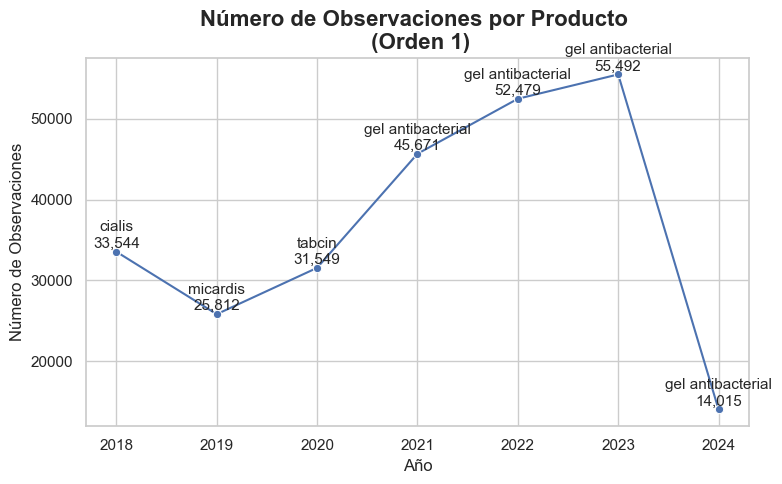

In [75]:
df_obs = pd.DataFrame({
    "producto": [
        "cialis", "micardis", "tabcin",
        "gel antibacterial", "gel antibacterial", "gel antibacterial", "gel antibacterial"
    ],
    "anio": [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    "num_obs": [33544, 25812, 31549, 45671, 52479, 55492, 14015],
    "orden": [1, 1, 1, 1, 1, 1, 1]
})

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))

# Gráfico de líneas con marcadores
ax = sns.lineplot(data=df_obs, x="anio", y="num_obs", marker="o", linewidth=1.5)
for i, row in df_obs.iterrows():
    ax.text(row["anio"], row["num_obs"] + 500, f'{row["producto"]}\n{row["num_obs"]:,}',
            ha='center', fontsize=11)

# Etiquetas
ax.set_title("Número de Observaciones por Producto \n (Orden 1)", fontsize=16, weight='bold')
ax.set_xlabel("Año", fontsize=12)
ax.set_ylabel("Número de Observaciones", fontsize=12)
ax.set_xticks(df_obs["anio"])

plt.tight_layout()
plt.show()

El gel antibacterial domina en observaciones desde 2021 hasta 2023, alcanzando un pico de más de 55 mil registros en 2023.

En 2024, su uso o seguimiento cae drásticamente a 14 mil observaciones, probablemente por menor demanda tras la pandemia.

Productos como cialis, micardis y tabcin tuvieron observaciones más moderadas (entre 25 mil y 33 mil) en los primeros años.

El alto uso del gel antibacterial lo coloca como el más utilizado a lo largo de los años

### 5. ¿Cuáles son el top 5 de productos con mayor precio en cada estado? ¿Son diferentes?

In [57]:
# Calculamos el precio promedio por producto, estado (para no repetir productos)
precio_prom_glob = df_parquet_meds.groupBy('estado', 'producto') \
    .agg(avg('precio').alias('precio_prom'))

# ventana
ventana = Window.partitionBy('estado').orderBy(col('precio_prom').desc())

# Creamos dataframe de top 5 productos más caros por estado 
df_top5_estado_glob = precio_prom_glob \
    .withColumn('orden', row_number().over(ventana)) \
    .filter(col('orden') <= 5) \
    .orderBy('estado', 'orden')

df_top5_estado_glob.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+--------+------------------+-----+
|         estado|producto|       precio_prom|orden|
+---------------+--------+------------------+-----+
| aguascalientes| cytotec|2988.5162913118857|    1|
| aguascalientes|   arava|2762.8197171581714|    2|
| aguascalientes|  keppra|2397.2584470606803|    3|
| aguascalientes| lipitor| 1759.736245989673|    4|
| aguascalientes| asenlix|1704.6074998510167|    5|
|baja california| cytotec|2937.3212432195005|    1|
|baja california|   arava|2587.5318160153915|    2|
|baja california|  keppra|2307.2819926070692|    3|
|baja california| asenlix|1788.6407496548632|    4|
|baja california| lipitor|1706.4803607892052|    5|
+---------------+--------+------------------+-----+
only showing top 10 rows

In [58]:
df_top5_estado_glob.coalesce(1).write \
    .mode("overwrite") \
    .option("header", True) \
    .csv(path_save+"meds/mayor_precio_edo_prod_glob")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [59]:
# Calculamos el precio promedio por producto, estado y anio (para no repetir productos)
precio_prom = df_parquet_meds.groupBy('estado', 'anio', 'producto') \
    .agg(avg('precio').alias('precio_prom'))

# ventana
ventana = Window.partitionBy('estado', 'anio').orderBy(col('precio_prom').desc())

# Creamos dataframe de top 5 productos más caros por estado, año 
df_top5_estado_anio = precio_prom \
    .withColumn('orden', row_number().over(ventana)) \
    .filter(col('orden') <= 5) \
    .orderBy('estado', 'anio', 'orden')

df_top5_estado_anio.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+----+--------+------------------+-----+
|        estado|anio|producto|       precio_prom|orden|
+--------------+----+--------+------------------+-----+
|aguascalientes|2018| cytotec|2789.0102689560144|    1|
|aguascalientes|2018|   arava| 2153.623006982741|    2|
|aguascalientes|2018|  keppra| 2071.391358928916|    3|
|aguascalientes|2018| asenlix|1628.6417380386258|    4|
|aguascalientes|2018| lipitor| 1523.565196600486|    5|
|aguascalientes|2019| cytotec| 2789.412213740458|    1|
|aguascalientes|2019|   arava|2266.4246575342468|    2|
|aguascalientes|2019|  keppra|2140.8033777185387|    3|
|aguascalientes|2019| lipitor| 1598.637640449438|    4|
|aguascalientes|2019| asenlix|1582.5726116204717|    5|
+--------------+----+--------+------------------+-----+
only showing top 10 rows

In [60]:
# Guardamos en un diccionario 7 dataframes pivoteados, uno por anio
anios = [row["anio"] for row in df_top5_estado_anio.select("anio").distinct().collect()]

pivot_anio = {}

for anio in anios:
    df_anio = df_top5_estado_anio.filter(col('anio') == anio)
    
    pivot_df = df_anio.groupBy('estado') \
        .pivot('orden', [1,2,3,4,5]) \
        .agg(first('producto'))
    
    pivot_anio[anio] = pivot_df
    
print("No tiene sentido realizar una sola tabla para todos los anios debido al efecto de la inflacion. Lo correcto es hacer una tabla por anio en la que se muestren, para cada anio, los cinco productos con mayor precio en cada estado")
print("\nPuede observarse que cytotec, arava y keppra son elementos comunes en todos los anios, aunque en 2020, 2021 y 2022 productos para el resfriado comun y para enfermedades respiratorias aparecen, tal vez debido a un aumento en la demanda por Covid-19")
print("\nEn 2023 y 2024 productos como fosamax plus que sirve para tratar la osteoporosis e insulina aparecen en el ranking de productos mas caros")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

No tiene sentido realizar una sola tabla para todos los anios debido al efecto de la inflacion. Lo correcto es hacer una tabla por anio en la que se muestren, para cada anio, los cinco productos con mayor precio en cada estado

Puede observarse que cytotec, arava y keppra son elementos comunes en todos los anios, aunque en 2020, 2021 y 2022 productos para el resfriado comun y para enfermedades respiratorias aparecen, tal vez debido a un aumento en la demanda por Covid-19

En 2023 y 2024 productos como fosamax plus que sirve para tratar la osteoporosis e insulina aparecen en el ranking de productos mas caros

#### 2018
 


In [61]:
pivot_anio[2018].show(32)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------+------+------+-------+-------+
|              estado|      1|     2|     3|      4|      5|
+--------------------+-------+------+------+-------+-------+
|      aguascalientes|cytotec| arava|keppra|asenlix|lipitor|
|     baja california|cytotec| arava|keppra|asenlix|lipitor|
| baja california sur|cytotec| arava|keppra|asenlix|lipitor|
|            campeche|cytotec| arava|keppra|asenlix|lipitor|
|             chiapas|cytotec| arava|keppra|asenlix|lipitor|
|           chihuahua|cytotec| arava|keppra|asenlix|lipitor|
|    ciudad de mexico|cytotec| arava|keppra|asenlix|lipitor|
|coahuila de zaragoza|cytotec| arava|keppra|asenlix|lipitor|
|              colima|cytotec| arava|keppra|asenlix|lipitor|
|             durango|cytotec| arava|keppra|asenlix|bonviva|
|    estado de mexico|cytotec| arava|keppra|asenlix|lipitor|
|          guanajuato|cytotec| arava|keppra|asenlix|lipitor|
|            guerrero|cytotec|keppra| arava|asenlix|lipitor|
|             hidalgo|cy

#### 2019

In [62]:
pivot_anio[2019].show(32)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------+-----+------+-------+-------+
|              estado|      1|    2|     3|      4|      5|
+--------------------+-------+-----+------+-------+-------+
|      aguascalientes|cytotec|arava|keppra|lipitor|asenlix|
|     baja california|cytotec|arava|keppra|asenlix|lipitor|
| baja california sur|cytotec|arava|keppra|asenlix|lipitor|
|            campeche|cytotec|arava|keppra|asenlix|lipitor|
|             chiapas|cytotec|arava|keppra|lipitor| evista|
|           chihuahua|cytotec|arava|keppra|asenlix|lipitor|
|    ciudad de mexico|cytotec|arava|keppra|asenlix|lipitor|
|coahuila de zaragoza|cytotec|arava|keppra|asenlix|lipitor|
|              colima|cytotec|arava|keppra|lipitor|asenlix|
|             durango|cytotec|arava|keppra|asenlix|lipitor|
|    estado de mexico|cytotec|arava|keppra|asenlix|lipitor|
|          guanajuato|cytotec|arava|keppra|lipitor|asenlix|
|            guerrero|cytotec|arava|keppra|asenlix|lipitor|
|             hidalgo|cytotec|arava|kepp

#### 2020

In [63]:
pivot_anio[2020].show(32)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------+-----------+-----------+------------+---------------+
|              estado|          1|          2|          3|           4|              5|
+--------------------+-----------+-----------+-----------+------------+---------------+
|      aguascalientes|    cytotec|      arava|     keppra|fosamax plus|        lipitor|
|     baja california|    cytotec|      arava|     keppra|     asenlix|        lipitor|
| baja california sur|    cytotec|      arava|     keppra|     asenlix|        lipitor|
|            campeche|    cytotec|      arava|     keppra|     lipitor|        asenlix|
|             chiapas|    cytotec|      arava|     keppra|     lipitor|   fosamax plus|
|           chihuahua|nebulizador| termometro|aderogyl 15| antiflu-des|antiflu-des jr.|
|    ciudad de mexico|    cytotec|      arava|     keppra|     lipitor|   fosamax plus|
|coahuila de zaragoza|    cytotec|      arava|     keppra|     lexapro|        lipitor|
|              colima|      arav

#### 2021

In [64]:
pivot_anio[2021].show(32)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------+-------+-------+--------------------+--------------------+
|              estado|      1|      2|      3|                   4|                   5|
+--------------------+-------+-------+-------+--------------------+--------------------+
|      aguascalientes|cytotec|  arava| keppra|             lexapro|        fosamax plus|
|     baja california|cytotec|  arava| keppra|        fosamax plus|             lipitor|
| baja california sur|  arava|cytotec| keppra|             lipitor|        fosamax plus|
|            campeche|  arava|cytotec| keppra|             lipitor|        fosamax plus|
|             chiapas|cytotec|  arava| keppra|             lipitor|        fosamax plus|
|           chihuahua|cytotec|  arava| keppra|        fosamax plus|             lipitor|
|    ciudad de mexico|cytotec|  arava| keppra|             lipitor|lantus. insulina ...|
|coahuila de zaragoza|cytotec|  arava| keppra|             lexapro|        fosamax plus|
|             durango

#### 2022

In [65]:
pivot_anio[2022].show(32)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------+----------+--------+--------------------+--------------------+
|              estado|      1|         2|       3|                   4|                   5|
+--------------------+-------+----------+--------+--------------------+--------------------+
|      aguascalientes|cytotec|     arava|  keppra|lantus. insulina ...|             lipitor|
|     baja california|cytotec|     arava|  keppra|             lipitor|lantus. insulina ...|
| baja california sur|  arava|   cytotec|  keppra|             lipitor|        fosamax plus|
|            campeche|cytotec|     arava|  keppra|             lipitor|lantus. insulina ...|
|             chiapas|cytotec|     arava|  keppra|             lipitor|        fosamax plus|
|           chihuahua|  arava|   cytotec|  keppra|lantus. insulina ...|        fosamax plus|
|    ciudad de mexico|cytotec|     arava|  keppra|             lipitor|lantus. insulina ...|
|coahuila de zaragoza|  arava|   cytotec|  keppra|             lexapro

#### 2023

In [66]:
pivot_anio[2023].show(32)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------+------------+--------+--------------------+--------------------+
|              estado|       1|           2|       3|                   4|                   5|
+--------------------+--------+------------+--------+--------------------+--------------------+
|      aguascalientes|   arava|     cytotec|  keppra|           xatral-od|             lipitor|
|     baja california|   arava|     cytotec|  keppra|           xatral-od|             asenlix|
| baja california sur|   arava|     cytotec|  keppra|             lipitor|           xatral-od|
|            campeche|   arava|     cytotec|  keppra|             lipitor|           xatral-od|
|             chiapas| cytotec|       arava|  keppra|             lipitor|             asenlix|
|           chihuahua|   arava|     cytotec|  keppra|           xatral-od|             lipitor|
|    ciudad de mexico|   arava|     cytotec|  keppra|             lipitor|           xatral-od|
|coahuila de zaragoza|   arava|     cyto

#### 2024

In [67]:
pivot_anio[2024].show(32)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------+-------+------+--------------------+--------------------+
|              estado|      1|      2|     3|                   4|                   5|
+--------------------+-------+-------+------+--------------------+--------------------+
|      aguascalientes|  arava|cytotec|keppra|           xatral-od|lantus. insulina ...|
|     baja california|  arava|cytotec|keppra|           xatral-od|        secotex ocas|
| baja california sur|  arava|cytotec|keppra|           xatral-od|lantus. insulina ...|
|            campeche|  arava|cytotec|keppra|           xatral-od|lantus. insulina ...|
|             chiapas|  arava|cytotec|keppra|        secotex ocas|             asenlix|
|           chihuahua|  arava|cytotec|keppra|           xatral-od|lantus. insulina ...|
|    ciudad de mexico|  arava|cytotec|keppra|           xatral-od|             lipitor|
|coahuila de zaragoza|  arava|cytotec|keppra|           xatral-od|lantus. insulina ...|
|             durango|  arava|cy

In [85]:
pd.read_csv("./csvs_PA/mayor_precio_edo_prod_glob.csv")

estado producto  precio_prom  orden
0    aguascalientes  cytotec  2988.516291      1
1    aguascalientes    arava  2762.819717      2
2    aguascalientes   keppra  2397.258447      3
3    aguascalientes  lipitor  1759.736246      4
4    aguascalientes  asenlix  1704.607500      5
..              ...      ...          ...    ...
155       zacatecas  cytotec  2834.320572      1
156       zacatecas    arava  2531.166202      2
157       zacatecas   keppra  2250.851280      3
158       zacatecas  asenlix  1727.597742      4
159       zacatecas  lipitor  1707.867152      5

[160 rows x 4 columns]

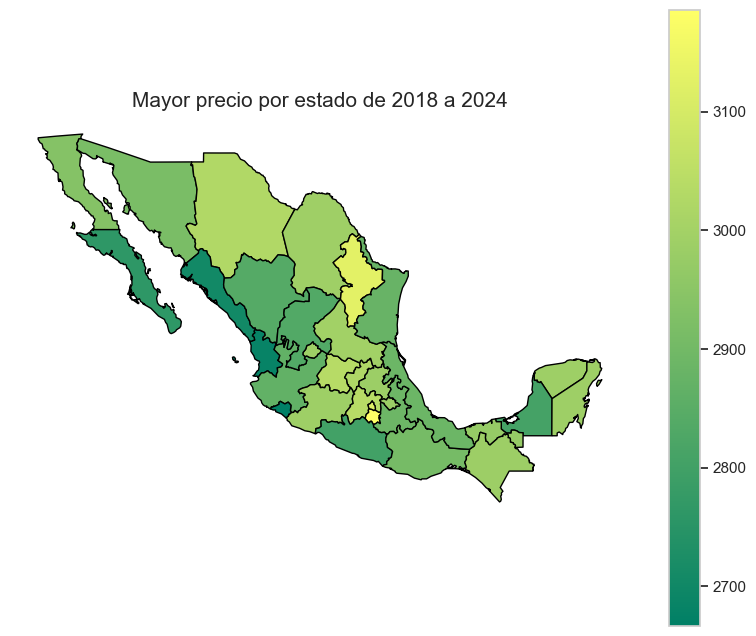

In [83]:
df_top5_estado_glob = pd.read_csv("./csvs_PA/mayor_precio_edo_prod_glob.csv")
df_top5_estado_glob = df_top5_estado_glob[["estado","precio_prom"]].groupby(["estado"]).max().reset_index()
df_top5_estado_glob["estado_norm"] = df_top5_estado_glob["estado"]
mapa = estados_mex.merge(df_top5_estado_glob, on="estado_norm", how="left")
# Plot con formateo de colorbar
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
mapa_plot = mapa.plot(
    column='precio_prom',
    cmap='summer',
    legend=True,
    edgecolor='black',
    ax=ax
)

# Formato de la leyenda
cbar = mapa_plot.get_figure().axes[-1]  # Accede al eje del colorbar
#cbar.yaxis.set_major_formatter(mticker.FuncFormatter(human_format))
# Títulos y estilo
ax.set_title("Mayor precio por estado de 2018 a 2024", fontsize=15)
ax.axis('off')
plt.show()


**Análisis general del top 5 de productos más caros por estado (2018–2024):**

**Uniformidad en los productos más caros:**
Durante los años 2018 y 2019, hay una alta consistencia entre los estados en cuanto a los productos más caros. Medicamentos como Cytotec, Arava, Keppra, Asenlix y Lipitor aparecen repetidamente en casi todos los estados.

**Cambio gradual y aparición de nuevos productos:**
A partir de 2020, se observa una ligera diversificación en los productos del top 5. Aparecen nuevos como Fosamax Plus, Lexapro y Lantus (insulina), especialmente en 2021 y 2022. Para 2023 y 2024, Xatral-OD toma mucha presencia como uno de los más caros.

**Estados con productos atípicos:**
Algunos estados como Chihuahua, Morelos, Nayarit y Guerrero presentan listas distintas en ciertos años (2020 y 2023), donde predominan productos como termómetros, nebulizadores o tempra, posiblemente por temas de disponibilidad o emergencias sanitarias locales.

**Distribución geográfica del precio más alto:**
El mapa muestra que el mayor precio promedio por estado varía, pero hay una concentración notable de valores más altos en el centro del país, como en Ciudad de México, Estado de México, Puebla y Morelos, mientras que en otras zonas el precio más alto promedio es ligeramente menor.

**¿Son diferentes entre estados?:**
Aunque hay productos recurrentes, como Cytotec y Arava, los resultados muestran que sí hay diferencias entre estados, especialmente en años recientes. Estas variaciones pueden estar relacionadas con políticas locales de compra, disponibilidad o demanda.

### 6. ¿Ha dejado de existir algún producto durante los años que tienes? ¿Cuál? ¿Cuándo desapareció?

In [68]:

# Para que un producto se considere que dejó de existir necesita aparecer en anios consecutivos hasta cierto tiempo distinto a 2024
anios = [row['anio'] for row in df_parquet_meds.select('anio').distinct().orderBy('anio').collect()]

df_disp = df_parquet_meds \
    .select('producto', 'anio') \
    .distinct() \
    .groupBy('producto') \
    .agg(collect_set('anio').alias('anios_aparicion')) # Crea df con columna producto y columna anios_aparicion que tiene lista de anios

df_disp = df_disp \
    .withColumn('ultimo_anio', array_max('anios_aparicion')) # Extrae el ultimo año en que aparecio el producto

# 2024 es el ultimo anio
ultimo_anio = max(anios)

# Si siguiera 'vigente', el ultimo anio seria 2024. En caso contrario entonces está 'descontinuado'
df_descontinuados = df_disp \
    .filter(col('ultimo_anio') < ultimo_anio) \
    .select('producto', 'ultimo_anio') \
    .withColumnRenamed('ultimo_anio', 'anio_desaparicion')

num_descontinuados = df_descontinuados.count()

if num_descontinuados ==0:
    print("No existen productos desaparecidos")
else:
    print(f"Existen {num_descontinuados} productos desaparecidos. La tabla de abajo muestra qué productos desaparecieron y en que anio lo hicieron")
    df_descontinuados.show(35)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

No existen productos desaparecidos

No existen productos desaparecidos y esto es consistente con lo que al inicio se vio, donde se tenía un mismo número de productos por año desde 2020, más aún, han aumentando la cantidad de productos en los años.

### 7. Genera una gráfica de serie de tiempo por estado para el producto con mayor precio -en todos los años-, donde el eje "x" es el año y el eje "y"" es el precio máximo.

In [79]:
df_prom_estado_anio = df_parquet_meds \
    .groupBy('anio','estado', 'producto') \
    .agg(avg('precio').alias('precio_prom_est'))
ventana = Window.partitionBy('anio','estado').orderBy(desc('precio_prom_est'))
df_prom_estado_anio = df_prom_estado_anio.withColumn('orden', row_number().over(ventana)) \
    .filter(col('orden')==1)\
    .drop('orden')
df_prom_estado_anio.coalesce(1).write \
    .mode("overwrite") \
    .option("header", True) \
    .csv(path_save+"meds/mayor_precio_edo_prod_glob_time_serie")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [80]:
df_prom_estado_anio.show(50)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------------------+--------+------------------+
|anio|              estado|producto|   precio_prom_est|
+----+--------------------+--------+------------------+
|2018|      aguascalientes| cytotec|2789.0102689560144|
|2018|     baja california| cytotec|2797.6106942612137|
|2018| baja california sur| cytotec| 2967.416110568576|
|2018|            campeche| cytotec| 2694.280704273897|
|2018|             chiapas| cytotec| 2929.476331360947|
|2018|           chihuahua| cytotec|2860.7673566951307|
|2018|    ciudad de mexico| cytotec|3037.4749177530957|
|2018|coahuila de zaragoza| cytotec|2808.5933265686035|
|2018|              colima| cytotec| 2631.926976854556|
|2018|             durango| cytotec|2624.4384826660157|
|2018|    estado de mexico| cytotec|2922.6120984499858|
|2018|          guanajuato| cytotec| 2893.264348909748|
|2018|            guerrero| cytotec|2790.4815196161685|
|2018|             hidalgo| cytotec|2901.6773310122285|
|2018|             jalisco| cytotec|2675.5738369

In [84]:
# Para encontrar, por estado el producto más caro, vamos a obtener primero el producto con mayor precio promedio en todos los anios

df_prom_estado = df_parquet_meds \
    .groupBy('estado', 'producto') \
    .agg(avg('precio').alias('precio_prom_est'))

ventana = Window.partitionBy('estado').orderBy(desc('precio_prom_est'))

df_mas_caro = df_prom_estado \
    .withColumn('orden', row_number().over(ventana)) \
    .filter(col('orden')==1) \
    .select('estado', 'producto')

# Ahora extraemos la serie del producto más caro de cada estado haciendo un join
df_serie_mas_caro = df_parquet_meds \
    .join(df_mas_caro, how='inner', on=['estado', 'producto']) \
    .select('estado', 'anio', 'precio', 'producto') \
    .orderBy('estado', 'anio')

# Tenemos varias observaciones de anio y estado, por lo que necesitamos el precio promedio 
serie_tiempo = df_serie_mas_caro.groupBy("estado", "anio") \
    .agg(avg("precio").alias("precio_promedio"))

serie_tiempo.coalesce(1).write \
    .mode("overwrite") \
    .option("header", True) \
    .csv(path_save+"meds/mayor_precio_time_serie")

serie_tiempo.show()



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----+------------------+
|             estado|anio|   precio_promedio|
+-------------------+----+------------------+
|     aguascalientes|2018|2789.0102689560144|
|     aguascalientes|2019| 2789.412213740458|
|     aguascalientes|2020| 2661.560810810811|
|     aguascalientes|2021| 2932.311475409836|
|     aguascalientes|2022|3108.8129032258066|
|     aguascalientes|2023| 3435.937931034483|
|     aguascalientes|2024| 3614.906976744186|
|    baja california|2018|2797.6106942612137|
|    baja california|2019|2909.6035225022006|
|    baja california|2020|2998.3983339251895|
|    baja california|2021|3275.3866943359376|
|    baja california|2022|3130.7799995236282|
|    baja california|2023|3200.0901202466116|
|    baja california|2024|3584.5905905330883|
|baja california sur|2018| 2967.416110568576|
|baja california sur|2019|  2591.07333836411|
|baja california sur|2020|2551.2593057321947|
|baja california sur|2021| 2665.895895070043|
|baja california sur|2022|    2694

In [82]:
df_prom_estado.show(35,truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------------------------+------------------+
|estado              |producto                   |precio_prom_est   |
+--------------------+---------------------------+------------------+
|tlaxcala            |benzonatato                |42.50832922745688 |
|yucatan             |venda elastica             |38.02269923192915 |
|aguascalientes      |desloratadina              |72.90513100270101 |
|chiapas             |bredelin                   |525.1361947901108 |
|chihuahua           |quadriderm nf              |337.66556627067934|
|michoacan de ocampo |refresh tears              |710.9883031155357 |
|oaxaca              |enalapril                  |46.11638225820148 |
|queretaro           |genoprazol                 |59.17280536825726 |
|quintana roo        |daflon 500 m.              |459.8147708707006 |
|san luis potosi     |acarbosa                   |73.55649893391056 |
|quintana roo        |betametasona               |46.850230234053434|
|hidalgo            

In [83]:
df_mas_caro.show(35,truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------+
|estado              |producto|
+--------------------+--------+
|aguascalientes      |cytotec |
|baja california     |cytotec |
|baja california sur |cytotec |
|campeche            |cytotec |
|chiapas             |cytotec |
|chihuahua           |cytotec |
|ciudad de mexico    |cytotec |
|coahuila de zaragoza|cytotec |
|colima              |cytotec |
|durango             |cytotec |
|estado de mexico    |cytotec |
|guanajuato          |cytotec |
|guerrero            |cytotec |
|hidalgo             |cytotec |
|jalisco             |cytotec |
|michoacan de ocampo |cytotec |
|morelos             |cytotec |
|nayarit             |cytotec |
|nuevo leon          |cytotec |
|oaxaca              |cytotec |
|puebla              |cytotec |
|queretaro           |cytotec |
|quintana roo        |cytotec |
|san luis potosi     |cytotec |
|sinaloa             |cytotec |
|sonora              |cytotec |
|tabasco             |cytotec |
|tamaulipas          |cytotec |
|tlaxcal

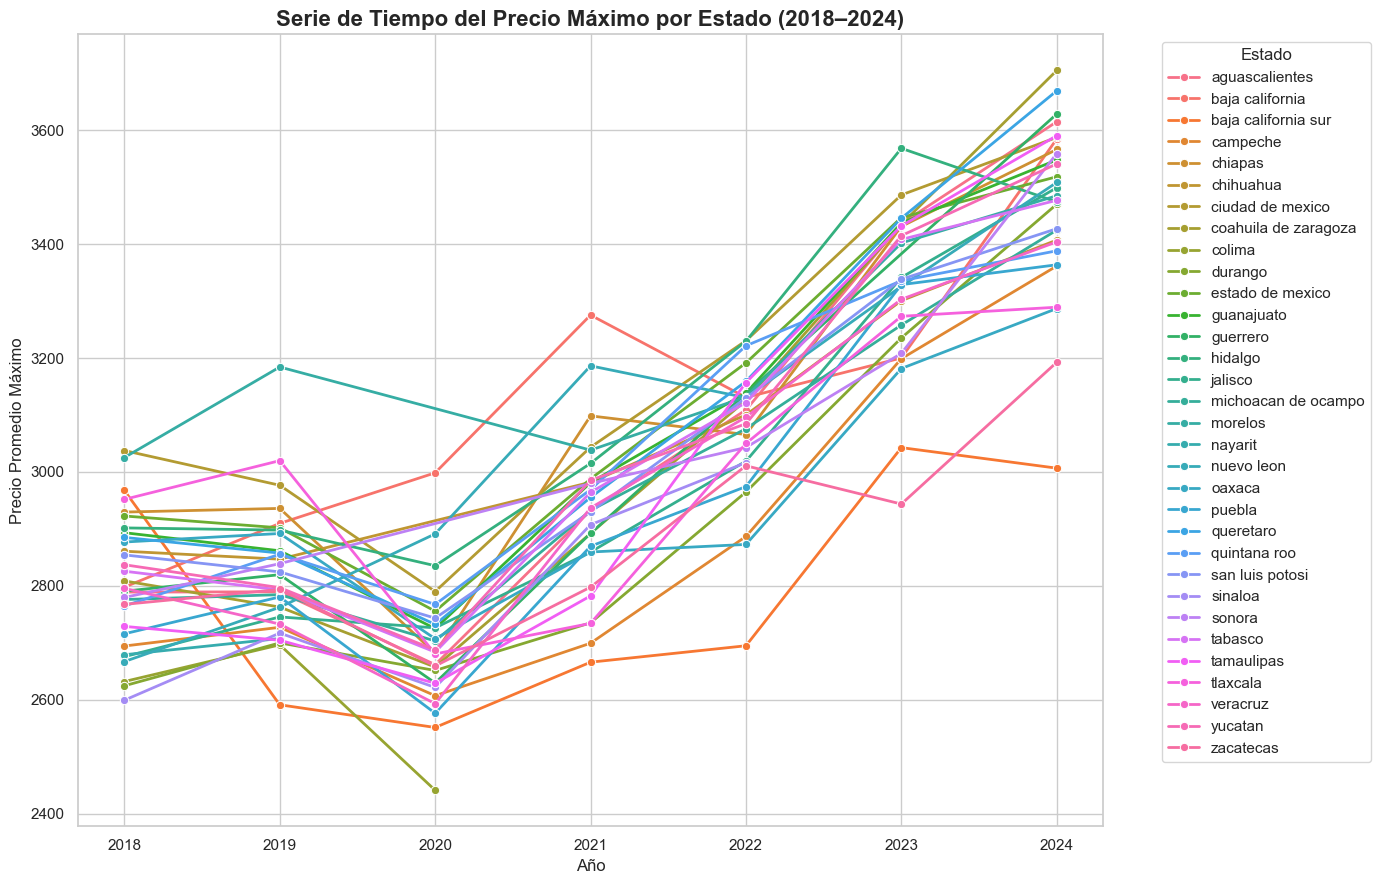

In [95]:
df_serie = pd.read_csv("./csvs_PA/mayor_precio_time_serie.csv")
# Gráfica
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 9))

sns.lineplot(data=df_serie, x="anio", y="precio_promedio", hue="estado", marker="o", linewidth=2)

plt.title("Serie de Tiempo del Precio Máximo por Estado (2018–2024)", fontsize=16, weight='bold')
plt.xlabel("Año", fontsize=12)
plt.ylabel("Precio Promedio Máximo", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Estado')
plt.tight_layout()
plt.show()

# Parcial Gran Escala - Parte B)

Apaguen su cluster de EMR, en esta parte no lo necesitarán. Para esta parte utilizaremos Athena.

Crea una base de datos profeco_db en Athena.

Crea una tabla externa profeco dentro de la base de datos profeco_db.

**¡¡¡Recuerda crear la tabla profeco con la tabla particionada, de otra forma tus queries van a ser costosos!!!.**

A partir de la siguiente pregunta utiliza Athena desde R o Python:

In [166]:
def abreviar_conteo(valor):
    """Convierte un número a formato abreviado: 1,200 -> 1.2K, 1,200,000 -> 1.2M"""
    if valor >= 1_000_000:
        return f"{valor / 1_000_000:.1f}M"
    elif valor >= 1_000:
        return f"{valor / 1_000:.1f}K"
    else:
        return str(valor)

def graficar_serie_medicamentos(df, titulo="Medicamentos reportados por año", color="#00707e"):
    """
    Grafica una serie temporal con estilo profesional, etiquetas abreviadas (K, M) y eje Y formateado.
    
    Parámetros:
    - df: DataFrame con columnas 'anio' y 'conteo'
    - titulo: Título del gráfico
    - color: Color de la línea
    """
    def abreviar_ticks(x, _):
        if x >= 1_000_000:
            return f"{x / 1_000_000:.1f}M"
        elif x >= 1_000:
            return f"{x / 1_000:.1f}K"
        else:
            return str(int(x))

    plt.figure(figsize=(8, 5))
    plt.plot(df["anio"], df["conteo"], marker='o', linewidth=3, color=color, alpha=0.55)
    
    # Etiquetas sobre los puntos
    for x, y in zip(df["anio"], df["conteo"]):
        label = abreviar_conteo(y)
        plt.text(x, y + max(df["conteo"]) * 0.015, label, ha='center', fontsize=11, color="#444")

    plt.title(titulo, fontsize=16, fontweight='bold')
    plt.xlabel("Año", fontsize=12)
    plt.ylabel("Número de registros", fontsize=12)
    plt.xticks(df["anio"], fontsize=10)
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(abreviar_ticks))
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()



def graficar_boxplot_estadistico(df):
    """
    Genera un boxplot estilizado a partir de un DataFrame con columnas:
    'anio', 'min', 'q_25', 'mediana', 'q_75', 'max'
    
    Parámetros:
    - df: DataFrame con los valores estadísticos por año
    """

    # Preparar data para el boxplot
    box_data = list(zip(df["min"], df["q_25"], df["mediana"], df["q_75"], df["max"]))
    fig, ax = plt.subplots(figsize=(8,5))

    # Crear boxplot manualmente con datos resumidos
    bxp_data = [
        {"med": m, "q1": q1, "q3": q3, "whislo": mn, "whishi": mx}
        for mn, q1, m, q3, mx in box_data
    ]

    ax.bxp(bxp_data, showfliers=False, patch_artist=True,
           boxprops=dict(facecolor="#c6e2e9", color="#00707e", linewidth=2),
           medianprops=dict(color="#004d4d", linewidth=2),
           whiskerprops=dict(color="#00707e"),
           capprops=dict(color="#00707e"))

    # Estética general
    ax.set_xticklabels(df["anio"], fontsize=11)
    ax.set_title("Distribución anual de precios de productos", fontsize=16, fontweight='bold')
    ax.set_ylabel("Precio", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

def graficar_boxplot_observaciones(df):
    """
    Genera un boxplot estilizado que muestra la distribución de observaciones
    por año a partir de los productos más reportados.
    
    Parámetros:
    - df: DataFrame con columnas: 'anio', 'producto', 'observaciones'
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Configuración estética
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 4))

    # Crear boxplot
    ax = sns.boxplot(data=df, x="anio", y="observaciones", palette="Blues", width=0.6)

    # Mostrar puntos reales sobre cada caja
    sns.stripplot(data=df, x="anio", y="observaciones", color="black", alpha=0.6, size=5, jitter=0.2)

    # Etiquetas
    plt.title("Distribución de observaciones por año (Top productos)", fontsize=16, fontweight='bold')
    plt.xlabel("Año", fontsize=12)
    plt.ylabel("Número de observaciones", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



## Creación `Database` & `Tables`

In [2]:
session = boto3.Session(profile_name='arquitectura')
s3 = session.client('s3')
my_config = Config(
    region_name = 'us-east-1'
)
glue = boto3.client('glue', config=my_config)

**Crear Database**

In [3]:
response = glue.create_database(
    DatabaseInput={
        'Name': 'profeco_db',
    },
)
response

{'ResponseMetadata': {'RequestId': '01997b7f-0e6a-4c7c-a8c4-f65297d00335',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 06 May 2025 15:10:35 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '01997b7f-0e6a-4c7c-a8c4-f65297d00335',
   'cache-control': 'no-cache'},
  'RetryAttempts': 0}}

**Crear Tabla**

In [8]:
# Query para crear la tabla externa con particiones
query = '''
CREATE EXTERNAL TABLE IF NOT EXISTS `profeco_db`.`profeco` (
    producto string,
    presentacion string,
    marca string,
    categoria string,
    precio double,
    fecharegistro string,
    cadenacomercial string,
    giro string,
    nombrecomercial string,
    direccion string,
    estado string,
    municipio string,
    latitud string,
    longitud string
)
PARTITIONED BY (catalogo string, anio int)
ROW FORMAT SERDE 'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS PARQUET
LOCATION 's3://itam-analytics-danielmichell/examen_arquitectura/parquet_clean/'
'''

In [7]:
wr.catalog.delete_table_if_exists(
    database='profeco_db',
    table='profeco',
    boto3_session=session
)

print("Tabla borrada exitosamente!")

Tabla borrada exitosamente!


In [9]:
# Ejecutar la consulta
wr.athena.read_sql_query(
    sql=query,
    database="profeco_db",
    ctas_approach=False,
    boto3_session=session
)

print("Tabla creada exitosamente!")

Tabla creada exitosamente!


In [ ]:
# 3. Cargar particiones
repair_query = "MSCK REPAIR TABLE profeco_db.profeco"
wr.athena.start_query_execution(
     sql=repair_query,
     database="profeco_db",
     boto3_session=session
)

In [11]:
df = wr.athena.read_sql_query(
    '''SELECT * FROM profeco_db.profeco LIMIT 5''', 
    database="profeco_db", 
    ctas_approach=False,
    boto3_session=session
)
df

producto                                       presentacion  \
0        colores de madera  caja 24 piezas. mina + gruesa. gratis 1 sacapu...   
1  cuaderno forma italiana                100 hojas. cuadro grande. engrapado   
2     cuaderno profesional                   100 hojas. cuadro grande. cosido   
3        colores de madera            caja plastico 12 piezas. 68-7408. largo   
4  cuaderno forma italiana                   100 hojas. cuadro grande. cosido   

                 marca         categoria      precio fecharegistro  \
0       bic. evolution  material escolar  169.899994    2022-03-31   
1         scribe. 6133  material escolar   21.900000    2022-03-31   
2         norma. color  material escolar   74.900002    2022-03-31   
3  crayola. twistables  material escolar  109.900002    2022-03-31   
4         norma. color  material escolar   46.900002    2022-03-31   

      cadenacomercial                                   giro  \
0  ley (autoservicio)  supermercado / tienda de autoservicio   
1  ley (autoservicio)  supermercado / tienda de autoservicio   
2  ley (autoservicio)  supermercado / tienda de autoservicio   
3  ley (autoservicio)  supermercado / tienda de autoservicio   
4  ley (autoservicio)  supermercado / tienda de autoservicio   

           nombrecomercial                                          direccion  \
0  ley sucursal blvd. kino  blvd. eusebio kino y revolucion s/n; esq. revo...   
1  ley sucursal blvd. kino  blvd. eusebio kino y revolucion s/n; esq. revo...   
2  ley sucursal blvd. kino  blvd. eusebio kino y revolucion s/n; esq. revo...   
3  ley sucursal blvd. kino  blvd. eusebio kino y revolucion s/n; esq. revo...   
4  ley sucursal blvd. kino  blvd. eusebio kino y revolucion s/n; esq. revo...   

   estado   municipio    latitud     longitud          catalogo  anio  
0  sonora  hermosillo  29.097565  -110.949496  utiles escolares  2022  
1  sonora  hermosillo  29.097565  -110.949496  utiles escolares  2022  
2  sonora  hermosillo  29.097565  -110.949496  utiles escolares  2022  
3  sonora  hermosillo  29.097565  -110.949496  utiles escolares  2022  
4  sonora  hermosillo  29.097565  -110.949496  utiles escolares  2022

Se observa que la tabla se creo con éxito

In [12]:
# se guardan las salidas para no volver a ejecutar los querys y añadir más costos
# df.to_csv("./output_b/data.csv", index=False)

## Preguntas

**De acuerdo a la categoría que te haya tocado obtén (desde 2018 a 2022):**

Se extiende el análisis a 2024, ya que al tocar la categoría de medicamentos es importante conocer el impacto de la pandemia en los datos. De cualquier manera se deja comentado el filtro para los años de 2018 a 2022.

### **a) ¿De qué año a qué año tienen datos de esa categoría?**

In [48]:
query_basic = """
SELECT 
    distinct(anio)
FROM 
    profeco_db.profeco
WHERE 
    catalogo = 'medicamentos'
-- AND
--    anio between 2018 and 2022
ORDER BY 
    anio
"""

query = """
SELECT 
    anio, count(*) conteo
FROM 
    profeco_db.profeco
WHERE 
    catalogo = 'medicamentos'
-- AND 
--    anio between 2018 and 2022
GROUP BY 
    anio
ORDER BY 
    anio
"""


query_df = wr.athena.read_sql_query(
    query, 
    database="profeco_db", 
    ctas_approach=False,
    boto3_session=session
)

In [97]:
# query_df.to_csv("./output_b/data_a.csv", index=False)
query_df = pd.read_csv("./output_b/data_a.csv")
query_df

anio   conteo
0  2018  3657969
1  2019  2887105
2  2020  2571915
3  2021  2937404
4  2022  3164281
5  2023  3192617
6  2024   798628

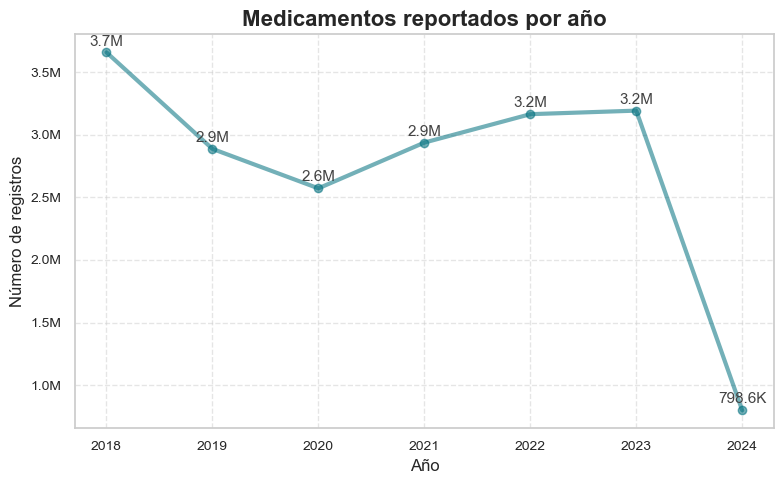

In [105]:
graficar_serie_medicamentos(query_df)

Para la categoría de medicamentos se tienen registros desde el **2018 al 2024 con cantidad mayor en 2018**, con **3.6M** de registros.

Se tiene también mayor número de registros en 2018, con casi 3.7 millones, lo que representa el pico en la serie.

Entre 2019 y 2020 hubo una caída continua, llegando a 2.6 millones en 2020, posiblemente por la disrupción causada por la pandemia.

De 2021 a 2023, se observa una recuperación sostenida, con cifras que regresan a niveles por encima de 3.2 millones.

En 2024, hay una caída abrupta a 798 mil registros, lo cual podría deberse a una base de datos aún incompleta, una reestructuración del sistema de captura o simplemente una reducción en el número de reportes disponibles hasta el momento.

### **b) ¿Cuántos registros de fecha hay vacíos?**

In [50]:

query_b = """
SELECT 
    count(*) conteo
FROM 
    profeco_db.profeco
WHERE 
    fecharegistro IS NULL
AND 
    catalogo = 'medicamentos'
-- AND 
--    anio between 2018 and 2022
"""

df_query_b = wr.athena.read_sql_query(
    query_b, 
    database="profeco_db", 
    ctas_approach=False,
    boto3_session=session
)

In [52]:
# df_query_b.to_csv("./output_b/data_b.csv", index=False)
df_query_b


conteo
0       0

No existe ningún registro sin fecha, porque con base en está fecha se selecciona el año por el cuál está particionada la tabla y en caso de existierán casos con fechas nulas, tendríamos una categoría más en las particiones, la categoría de "null", y ya sea que se tendría que asociar un valor a ese valor nulo para particionar o llevarnos una partición null, lo cuál generaría incosistencia con el tipo de formato `int` con el cuál se estableció la partición de `anio`.

### **c) ¿Cuántos registros tienes por año?**

En la pregunta 1 se observan los registros por año

| Año    | Registros     |
|--------|--------------:|
| 2018   |  3,657,969    |
| 2019   |  2,887,105    |
| 2020   |  2,571,915    |
| 2021   |  2,937,404    |
| 2022   |  3,164,281    |
| 2023   |  3,192,617    |
| 2024   |    798,628    |

### **d) ¿Cuál es el precio mínimo, máximo, promedio, desviación estándar, mediana, cuantil 25 y 75% de tu categoría por año?**

In [53]:
query_d = """
SELECT
    anio,
    MIN(precio) AS min,
    MAX(precio) AS max,
    AVG(precio) AS mean,
    STDDEV(precio) AS std,
    APPROX_PERCENTILE(precio, 0.5) AS mediana,
    APPROX_PERCENTILE(precio, 0.25) AS q_25,
    APPROX_PERCENTILE(precio, 0.75) AS q_75
FROM 
    profeco_db.profeco
WHERE 
    catalogo = 'medicamentos'
-- AND 
--    anio between 2018 and 2022
GROUP BY 
    anio
ORDER BY 
    anio
"""

df_query_d = wr.athena.read_sql_query(
    query_d, 
    database="profeco_db", 
    ctas_approach=False,
    boto3_session=session
)
# df_query_d.to_csv("./output_b/data_d.csv", index=False)
df_query_d

anio   min          max        mean         std     mediana       q_25  \
0  2018  5.00  3535.000000  415.927358  427.193231  304.174445  95.281984   
1  2019  6.50  3779.000000  433.043714  446.192696  308.334201  89.968797   
2  2020  4.50  4082.000000  419.928531  463.663499  273.567123  69.350697   
3  2021  4.95  4082.000000  423.066817  488.693700  251.142297  58.792060   
4  2022  6.00  4104.839844  456.222171  524.127487  273.021077  62.983507   
5  2023  5.00  5040.000000  492.442195  571.924811  278.655461  65.154534   
6  2024  7.01  5275.000000  505.877757  593.105319  296.714136  66.706400   

         q_75  
0  585.165710  
1  614.908851  
2  622.027079  
3  618.185138  
4  685.360693  
5  732.550208  
6  716.135195

In [98]:
df_query_d = pd.read_csv("./output_b/data_d.csv")

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/2762420521.py:66: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.bxp(bxp_data, showfliers=False, patch_artist=True,


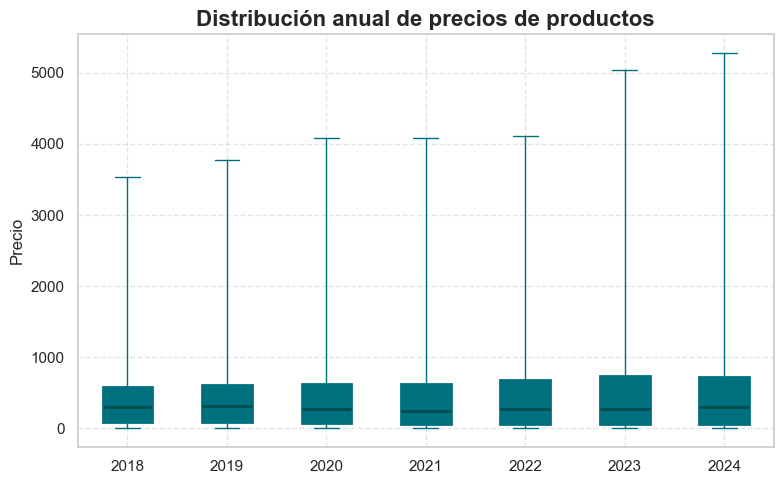

In [106]:
# Ejecutar la función
graficar_boxplot_estadistico(df_query_d)

Se muestran precios alrededor de $300 a $450, pero tenemos precios mínimos desde $5 y precios máximos hasta los $4,100 aprox.

Los precios de los medicamentos han subido con el tiempo, especialmente los más caros.

El precio promedio también ha aumentado cada año.

La mayoría de los medicamentos siguen siendo accesibles, pero hay algunos muy costosos que elevan mucho los valores máximos.

En 2024 se registran los precios más altos y también más variedad en los precios.

### **e) ¿Cuáles son el top 5 de productos con mayor precio en cada estado? ¿Verifica si te dió lo mismo en Spark?**

Cambiamos marca por producto

In [65]:
query_e_2 = """
WITH ranked_prices AS (
    SELECT
        anio,
        estado,
        producto,
        MAX(precio) AS precio_maximo,
        RANK() OVER (PARTITION BY anio, estado ORDER BY MAX(precio) DESC) AS ranking
    FROM 
        profeco_db.profeco
    WHERE 
        precio IS NOT NULL
    AND 
        catalogo = 'medicamentos'
    -- AND 
    --   anio between 2018 and 2022
    GROUP BY 
        anio, estado, producto
)
SELECT
    anio,
    estado,
    producto,
    precio_maximo,
    ranking
FROM 
    ranked_prices
WHERE 
    ranking <= 5
ORDER BY
    anio,
    estado, 
    ranking;
"""
df_query_e_2 = wr.athena.read_sql_query(
    query_e_2, 
    database="profeco_db", 
    ctas_approach=False,
    boto3_session=session
)

In [66]:
#df_query_e_2.to_csv("./output_b/data_e_max.csv", index=False)
df_query_e_2

anio          estado producto  precio_maximo  ranking
0     2018  aguascalientes  cytotec         3450.0        1
1     2018  aguascalientes  lexapro         2689.0        2
2     2018  aguascalientes   cialis         2620.0        3
3     2018  aguascalientes    arava         2591.0        4
4     2018  aguascalientes   keppra         2281.0        5
...    ...             ...      ...            ...      ...
1066  2024       zacatecas    arava         4034.0        1
1067  2024       zacatecas  cytotec         3895.0        2
1068  2024       zacatecas  lexapro         3728.0        3
1069  2024       zacatecas   cialis         3307.0        4
1070  2024       zacatecas   keppra         3042.0        5

[1071 rows x 5 columns]

In [107]:
df_query_e_2 = pd.read_csv("./output_b/data_e_max.csv")

In [108]:
# Diccionario para guardar por año
tablas_por_anio = {}

# Iterar por año y pivotear para cada uno
for anio, grupo in df_query_e_2.groupby("anio"):
    tabla = grupo.pivot(index="estado", columns="ranking", values="producto").reset_index()
    tablas_por_anio[anio] = tabla

In [109]:
for anio in [2018,2019,2020,2021,2022,2023,2024]:
    display(tablas_por_anio[anio])

ranking                estado        1        2         3        4        5
0              aguascalientes  cytotec  lexapro    cialis    arava   keppra
1             baja california  cytotec   cialis  cymbalta  lexapro    arava
2         baja california sur  cytotec    arava   lexapro   cialis   keppra
3                    campeche  cytotec  lexapro     arava   keppra   cialis
4                     chiapas  cytotec  lexapro     arava   cialis  lipitor
5                   chihuahua  cytotec   cialis     arava  lexapro   keppra
6            ciudad de mexico  cytotec  lexapro     arava   cialis  lipitor
7        coahuila de zaragoza  cytotec   cialis    keppra    arava  lexapro
8                      colima  cytotec  lexapro     arava   cialis   keppra
9                     durango  cytotec  lexapro    cialis    arava  lipitor
10           estado de mexico  cytotec   cialis  cymbalta    arava  lexapro
11                 guanajuato  cytotec    arava   lexapro   cialis   keppra
12                   guerrero  cytotec  lexapro     arava  lipitor   cialis
13                    hidalgo  cytotec    arava   lexapro   cialis   keppra
14                    jalisco  cytotec   cialis     arava  lexapro   keppra
15        michoacan de ocampo  cytotec  lexapro    cialis    arava   keppra
16                    morelos  cytotec  lexapro    cialis    arava  lipitor
17                    nayarit  cytotec  lexapro    cialis    arava  lipitor
18                 nuevo leon  cytotec  lexapro    cialis    arava  lipitor
19                     oaxaca  cytotec  lexapro     arava   cialis   keppra
20                     puebla  cytotec    arava   lexapro   cialis  lipitor
21                  queretaro  cytotec    arava   lexapro   cialis   keppra
22               quintana roo  cytotec  lexapro    cialis    arava  lipitor
23            san luis potosi  cytotec    arava   lexapro   cialis  lipitor
24                    sinaloa  cytotec  lexapro     arava   cialis  lipitor
25                     sonora  cytotec    arava   lexapro   cialis   keppra
26                    tabasco  cytotec  lexapro   lipitor    arava   cialis
27                 tamaulipas  cytotec   cialis   lexapro    arava  asenlix
28                   tlaxcala  cytotec   cialis     arava   keppra  lipitor
29                   veracruz  cytotec   cialis     arava  lexapro  lipitor
30                    yucatan  cytotec    arava   lexapro   cialis   keppra
31                  zacatecas  cytotec    arava   lexapro   cialis  lipitor

ranking                estado        1        2        3        4         5
0              aguascalientes  cytotec  lexapro    arava   keppra    cialis
1             baja california  lexapro  cytotec    arava   cialis    keppra
2         baja california sur  cytotec  lexapro    arava   cialis    keppra
3                    campeche  cytotec  lexapro    arava   keppra    cialis
4                     chiapas  cytotec  lexapro   cialis    arava   lipitor
5                   chihuahua  cytotec  lexapro   cialis    arava   lipitor
6            ciudad de mexico  cytotec  lexapro    arava   cialis   lipitor
7        coahuila de zaragoza  cytotec  lexapro   cialis    arava   lipitor
8                      colima  cytotec  lexapro    arava  lipitor    cialis
9                     durango  lexapro  cytotec    arava   cialis   lipitor
10           estado de mexico  lexapro  cytotec    arava   cialis   lipitor
11                 guanajuato  lexapro  cytotec    arava   cialis   lipitor
12                   guerrero  cytotec  lexapro    arava   keppra    cialis
13                    hidalgo  lexapro  cytotec    arava   cialis   lipitor
14                    jalisco  cytotec   cialis  lexapro   keppra     arava
15        michoacan de ocampo  lexapro  cytotec   cialis    arava   lipitor
16                    morelos  cytotec  lexapro    arava   keppra    cialis
17                    nayarit  cytotec   cialis    arava   keppra   lexapro
18                 nuevo leon  cytotec    arava   cialis  lexapro    keppra
19                     oaxaca  cytotec  lexapro    arava   cialis    keppra
20                     puebla  lexapro  cytotec   cialis    arava   lipitor
21                  queretaro  lexapro  cytotec    arava   cialis   lipitor
22               quintana roo  lexapro  cytotec    arava   cialis   lipitor
23            san luis potosi  lexapro  cytotec    arava   cialis   lipitor
24                    sinaloa  cytotec    arava  lexapro   cialis   lipitor
25                     sonora  lexapro  cytotec    arava   cialis   lipitor
26                    tabasco  cytotec  lexapro   cialis  lipitor  cymbalta
27                 tamaulipas  cytotec  lexapro   cialis    arava    keppra
28                   tlaxcala  cytotec  lexapro    arava   cialis    keppra
29                   veracruz  lexapro  cytotec   cialis    arava   lipitor
30                    yucatan  lexapro  cytotec    arava   cialis   lipitor
31                  zacatecas  lexapro  cytotec   cialis    arava   lipitor

ranking                estado            1            2            3  \
0              aguascalientes      lexapro      cytotec        arava   
1             baja california      lexapro      cytotec        arava   
2         baja california sur      lexapro        arava      cytotec   
3                    campeche      lexapro      cytotec      lipitor   
4                     chiapas      lexapro        arava      cytotec   
5                   chihuahua  nebulizador   termometro  aderogyl 15   
6            ciudad de mexico      lexapro      cytotec        arava   
7        coahuila de zaragoza      lexapro      cytotec        arava   
8                      colima        arava      cytotec       keppra   
9                     durango      lexapro      cytotec        arava   
10           estado de mexico      lexapro      cytotec        arava   
11                 guanajuato      lexapro      cytotec        arava   
12                   guerrero      lexapro      cytotec        arava   
13                    hidalgo      lexapro      cytotec        arava   
14                    jalisco      lexapro      cytotec       cialis   
15        michoacan de ocampo      lexapro      cytotec        arava   
16                    morelos  nebulizador   termometro     theraflu   
17                    nayarit  nebulizador  aderogyl 15  antiflu-des   
18                 nuevo leon      cytotec      lexapro       cialis   
19                     oaxaca      cytotec      lexapro        arava   
20                     puebla        arava      lexapro       cialis   
21                  queretaro      lexapro      cytotec        arava   
22               quintana roo      lexapro      cytotec        arava   
23            san luis potosi      lexapro      cytotec        arava   
24                    sinaloa      lexapro      cytotec        arava   
25                     sonora  nebulizador   termometro       tempra   
26                    tabasco      lexapro      cytotec        arava   
27                 tamaulipas      lexapro      cytotec        arava   
28                   tlaxcala      lexapro      cytotec        arava   
29                   veracruz      lexapro      cytotec        arava   
30                    yucatan      lexapro      cytotec       cialis   
31                  zacatecas      lexapro      cytotec       cialis   

ranking                  4                5  
0                   keppra          lipitor  
1                   cialis          lipitor  
2                   cialis           keppra  
3                    arava           keppra  
4                   cialis          lipitor  
5              antiflu-des  antiflu-des jr.  
6                   cialis         cymbalta  
7                   keppra           cialis  
8                   cialis     fosamax plus  
9                   cialis          lipitor  
10                  cialis          lipitor  
11                  keppra           cialis  
12                  keppra           cialis  
13                  cialis           keppra  
14                   arava           keppra  
15                  cialis          lipitor  
16                  tempra          xl-3 vr  
17                  tempra       termometro  
18                 lipitor            arava  
19                  keppra           cialis  
20                 cytotec           keppra  
21                  cialis         cymbalta  
22                  cialis          lipitor  
23                  cialis          lipitor  
24                  cialis          lipitor  
25       gel antibacterial          xl-3 vr  
26                  keppra           cialis  
27                  cialis          lipitor  
28                  keppra          lipitor  
29                  cialis           keppra  
30                   arava          lipitor  
31                   arava          lipitor

ranking                estado        1        2        3          4  \
0              aguascalientes    arava  cytotec  lexapro     cialis   
1             baja california  lexapro    arava  cytotec     cialis   
2         baja california sur  lexapro  cytotec    arava     cialis   
3                    campeche  lexapro    arava  cytotec     keppra   
4                     chiapas  lexapro    arava  cytotec     cialis   
5                   chihuahua  lexapro    arava  cytotec     cialis   
6            ciudad de mexico  lexapro    arava  cytotec     cialis   
7        coahuila de zaragoza  lexapro  cytotec    arava     keppra   
8                     durango  lexapro  cytotec    arava     keppra   
9            estado de mexico  lexapro  cytotec    arava     cialis   
10                 guanajuato  lexapro    arava  cytotec     keppra   
11                   guerrero  lexapro  cytotec    arava     keppra   
12                    hidalgo  lexapro   cialis  cytotec      arava   
13                    jalisco  lexapro  cytotec    arava     cialis   
14        michoacan de ocampo  lexapro  cytotec    arava     cialis   
15                    morelos  cytotec  lexapro    arava     keppra   
16                 nuevo leon  lexapro  cytotec    arava     cialis   
17                     oaxaca  lexapro  cytotec    arava     cialis   
18                     puebla  lexapro  cytotec    arava     cialis   
19                  queretaro  lexapro  cytotec    arava     cialis   
20               quintana roo  lexapro  cytotec   cialis      arava   
21            san luis potosi  lexapro  cytotec    arava     keppra   
22                    sinaloa  lexapro  cytotec    arava     cialis   
23                     sonora  lexapro    arava  cytotec     cialis   
24                    tabasco  lexapro  cytotec    arava  xatral-od   
25                 tamaulipas  lexapro  cytotec    arava     cialis   
26                   tlaxcala  lexapro  cytotec    arava     keppra   
27                   veracruz  lexapro  cytotec    arava     cialis   
28                    yucatan  lexapro  cytotec    arava     cialis   
29                  zacatecas  lexapro  cytotec    arava     cialis   

ranking                  5  
0                   keppra  
1                   keppra  
2                   keppra  
3                  lipitor  
4                   keppra  
5                   keppra  
6                   keppra  
7                   cialis  
8                   cialis  
9                   keppra  
10                 lipitor  
11       keflex pediatrico  
12                 lipitor  
13                  keppra  
14                  keppra  
15                 lipitor  
16                 lipitor  
17                  keppra  
18                 lipitor  
19                  keppra  
20                  keppra  
21                  cialis  
22                  keppra  
23                  keppra  
24                  keppra  
25                  keppra  
26                 lipitor  
27                  keppra  
28                  keppra  
29                 lipitor

ranking                estado         1        2        3           4  \
0              aguascalientes   lexapro  cytotec    arava      keppra   
1             baja california     arava  cytotec   cialis     lexapro   
2         baja california sur   lexapro    arava  cytotec      keppra   
3                    campeche   lexapro  cytotec    arava      cialis   
4                     chiapas   lexapro  cytotec    arava      keppra   
5                   chihuahua     arava  lexapro  cytotec      cialis   
6            ciudad de mexico   lexapro  cytotec    arava    cymbalta   
7        coahuila de zaragoza     arava  cytotec  lexapro      cialis   
8                     durango   lexapro  cytotec    arava      keppra   
9            estado de mexico   lexapro  cytotec    arava      keppra   
10                 guanajuato   cytotec    arava  lexapro      keppra   
11                   guerrero  aspirina   tempra   tabcin  sedalmerck   
12                    hidalgo   cytotec  lexapro    arava      keppra   
13                    jalisco     arava  lexapro  cytotec      keppra   
14        michoacan de ocampo   lexapro  cytotec    arava      keppra   
15                    morelos   lexapro  cytotec    arava      keppra   
16                 nuevo leon   lexapro  cytotec    arava      cialis   
17                     oaxaca   cytotec  lexapro    arava      keppra   
18                     puebla     arava  cytotec  lexapro     lipitor   
19                  queretaro   lexapro    arava  cytotec      keppra   
20               quintana roo   cytotec  lexapro    arava      cialis   
21            san luis potosi   cytotec    arava  lexapro      cialis   
22                    sinaloa   lexapro  cytotec    arava      keppra   
23                     sonora   lexapro    arava  cytotec      cialis   
24                    tabasco   cytotec  lexapro    arava      keppra   
25                 tamaulipas   lexapro    arava  cytotec     lipitor   
26                   tlaxcala     arava  lexapro  cytotec      keppra   
27                   veracruz     arava  cytotec  lexapro      cialis   
28                    yucatan     arava  cytotec  lexapro      cialis   
29                  zacatecas   cytotec    arava  lexapro      cialis   

ranking             5  
0              cialis  
1              keppra  
2              cialis  
3              keppra  
4              cialis  
5              keppra  
6              keppra  
7              keppra  
8              cialis  
9             lipitor  
10            lipitor  
11       cafiaspirina  
12             cialis  
13             cialis  
14            lipitor  
15            lipitor  
16            lipitor  
17             cialis  
18             keppra  
19             cialis  
20             keppra  
21             keppra  
22            lipitor  
23            lipitor  
24             cialis  
25             keppra  
26            lipitor  
27             keppra  
28            lipitor  
29            lipitor

ranking                estado         1             2         3         4  \
0              aguascalientes     arava       cytotec   lexapro   lipitor   
1             baja california     arava       lexapro   cytotec    keppra   
2         baja california sur   cytotec       lexapro     arava    keppra   
3                    campeche     arava       cytotec   lexapro    cialis   
4                     chiapas     arava       cytotec   lexapro    keppra   
5                   chihuahua     arava       cytotec   lexapro    keppra   
6            ciudad de mexico     arava       lexapro   aprovel   cytotec   
7        coahuila de zaragoza     arava       cytotec   lexapro    keppra   
8                     durango     arava       cytotec   lexapro    keppra   
9            estado de mexico     arava       lexapro   cytotec  cymbalta   
10                 guanajuato     arava       lexapro   cytotec    keppra   
11                   guerrero    tempra  cafiaspirina  aspirina    tabcin   
12                    hidalgo     arava       lexapro   cytotec    keppra   
13                    jalisco     arava       cytotec   lexapro    keppra   
14        michoacan de ocampo     arava       lexapro   cytotec    keppra   
15                    morelos     arava       cytotec   lexapro    keppra   
16                 nuevo leon     arava       cytotec   lexapro    keppra   
17                     oaxaca     arava       cytotec   lexapro    keppra   
18                     puebla     arava       cytotec   lexapro    keppra   
19                  queretaro     arava       cytotec   lexapro    cialis   
20               quintana roo     arava       lexapro   cytotec    keppra   
21            san luis potosi     arava       cytotec   lexapro    keppra   
22                    sinaloa  lactacyd           NaN       NaN       NaN   
23                     sonora     arava       cytotec   lexapro    keppra   
24                    tabasco     arava       lexapro   cytotec    keppra   
25                 tamaulipas     arava       cytotec   lexapro    keppra   
26                   tlaxcala     arava       lexapro   cytotec    keppra   
27                   veracruz     arava       cytotec   lexapro    keppra   
28                    yucatan     arava       cytotec   lexapro    keppra   
29                  zacatecas     arava       cytotec   lexapro    cialis   

ranking                       5  
0                        keppra  
1                        cialis  
2                        cialis  
3                       lipitor  
4                       lipitor  
5                        cialis  
6                        keppra  
7                        cialis  
8                        cialis  
9                        keppra  
10                     cymbalta  
11       suplemento alimenticio  
12                      lipitor  
13                       cialis  
14                       cialis  
15                       cialis  
16                       cialis  
17                       cialis  
18                       cialis  
19                       keppra  
20                       cialis  
21                       cialis  
22                          NaN  
23                       cialis  
24                       cialis  
25                      lipitor  
26                       cialis  
27                       cialis  
28                       cialis  
29                       keppra

ranking                estado      1        2        3        4  \
0              aguascalientes  arava  cytotec  lexapro   keppra   
1             baja california  arava  cytotec  lexapro   cialis   
2         baja california sur  arava  cytotec   keppra  lipitor   
3                    campeche  arava  cytotec  lexapro   cialis   
4                     chiapas  arava  cytotec  lexapro   keppra   
5                   chihuahua  arava  cytotec  lexapro   keppra   
6            ciudad de mexico  arava  cytotec  lexapro   keppra   
7        coahuila de zaragoza  arava  cytotec  lexapro   keppra   
8                     durango  arava  cytotec  lexapro   keppra   
9            estado de mexico  arava  cytotec  lexapro   keppra   
10                 guanajuato  arava  cytotec  lexapro   keppra   
11                   guerrero  arava  cytotec  lexapro   keppra   
12                    hidalgo  arava  cytotec  lexapro   keppra   
13                    jalisco  arava  cytotec  lexapro   keppra   
14        michoacan de ocampo  arava  cytotec  lexapro   keppra   
15                    morelos  arava  cytotec  lexapro   keppra   
16                 nuevo leon  arava  cytotec  lexapro   keppra   
17                     oaxaca  arava  cytotec  lexapro   keppra   
18                     puebla  arava  cytotec  lexapro   keppra   
19                  queretaro  arava  cytotec  lexapro   keppra   
20               quintana roo  arava  lexapro  cytotec   keppra   
21            san luis potosi  arava  cytotec  lexapro   keppra   
22                     sonora  arava  cytotec  lexapro   keppra   
23                    tabasco  arava  cytotec  lexapro   keppra   
24                 tamaulipas  arava  cytotec  lexapro   keppra   
25                   tlaxcala  arava  cytotec  lexapro   keppra   
26                   veracruz  arava  cytotec  lexapro   keppra   
27                    yucatan  arava  cytotec  lexapro   keppra   
28                  zacatecas  arava  cytotec  lexapro   cialis   

ranking                          5  
0                           cialis  
1                           keppra  
2                          lexapro  
3                          lipitor  
4                           cialis  
5        lantus. insulina glargina  
6                           cialis  
7                          lipitor  
8                           cialis  
9                           cialis  
10                        cymbalta  
11                          cialis  
12                          cialis  
13                          cialis  
14                          cialis  
15                          cialis  
16                         lipitor  
17                          cialis  
18                          cialis  
19                          cialis  
20                          cialis  
21                          cialis  
22                         lipitor  
23                          cialis  
24       lantus. insulina glargina  
25                          cialis  
26                          cialis  
27                          cialis  
28                          keppra

En este caso observamos lo mismos resultados que en el ejercicio con pyspark, se tiene la misma consistencia, por lo que se tiene un análisis sustentado con dos métodos distintos.

In [164]:
pd.options.display.max_rows = 40

In [138]:
df_top_products = df_query_e_2.groupby(["anio","producto"]).agg({"ranking":["mean","count"],
                                 "precio_maximo":["mean"]
                                 }).reset_index().sort_values(by=[('ranking', 'count'),('ranking', 'mean')],ascending=[False,True]).reset_index(drop=True)
df_top_products

anio                producto  ranking       precio_maximo
                                     mean count          mean
0   2018                 cytotec  1.00000    32   3364.310616
1   2019                 cytotec  1.43750    32   3442.262527
2   2019                 lexapro  1.78125    32   3330.952499
3   2018                   arava  3.12500    32   2748.933418
4   2018                  cialis  3.37500    32   2710.558746
..   ...                     ...      ...   ...           ...
69  2020            fosamax plus  5.00000     1   1913.000000
70  2021       keflex pediatrico  5.00000     1   2587.000000
71  2022            cafiaspirina  5.00000     1     68.000000
72  2023  suplemento alimenticio  5.00000     1     61.000000
73  2024                cymbalta  5.00000     1   3154.000000

[74 rows x 5 columns]

Conclusiones sobre el top 5 de productos con mayor precio por estado (2018–2024)

-   1. Productos dominantes

        Cytotec, Arava, Lexapro y Cialis son los medicamentos que con más frecuencia aparecen en el top 5 de precios por estado y año.

        En particular, Cytotec aparece en todos los estados en 2018 y mantiene presencia fuerte hasta 2024.

        Arava y Lexapro compiten en los primeros lugares en la mayoría de los años, especialmente desde 2019 en adelante.

-   2. Distribución por estados

        La columna count representa cuántos estados tienen ese producto dentro de su top 5. Por ejemplo:

        En 2018, Cytotec tiene count = 32, lo que significa que estuvo en el top 5 de todos los estados.

        En 2024, aunque aún domina, la presencia está más distribuida (por ejemplo, Arava aparece en 29 estados).

-   3. Evolución del ranking
  
        El campo ranking (mean) muestra la posición promedio en el top 5. Productos con valores cercanos a 1.0 fueron los más caros consistentemente.

        Ejemplo: en 2024, Arava tiene ranking = 1.0, reafirmando que fue el producto más caro en la mayoría de los estados donde apareció.

-   4. Tendencias de precio

        Los valores de precio_maximo (mean) indican que estos medicamentos no solo fueron frecuentes, sino también costosos. Por ejemplo, en 2024, Arava alcanzó un promedio superior a $4,600.

In [139]:
df_top_products.columns = ['anio','producto','mean','count','precio']
# productos principales
productos_principales = ["cytotec", "arava", "lexapro", "cialis"]
df_top_filtered_auto = df_top_products[df_top_products["producto"].isin(productos_principales)]
df_top_filtered_auto

anio producto      mean  count       precio
0   2018  cytotec  1.000000     32  3364.310616
1   2019  cytotec  1.437500     32  3442.262527
2   2019  lexapro  1.781250     32  3330.952499
3   2018    arava  3.125000     32  2748.933418
4   2018   cialis  3.375000     32  2710.558746
..   ...      ...       ...    ...          ...
26  2020   cialis  4.000000     25  2872.469199
28  2021   cialis  4.000000     24  3023.450002
29  2024   cialis  4.863636     22  2993.210926
30  2023   cialis  4.857143     21  3037.848110
31  2022   cialis  4.400000     20  3057.850000

[28 rows x 5 columns]

Adicional, se concluye sobre los productos más utilizados

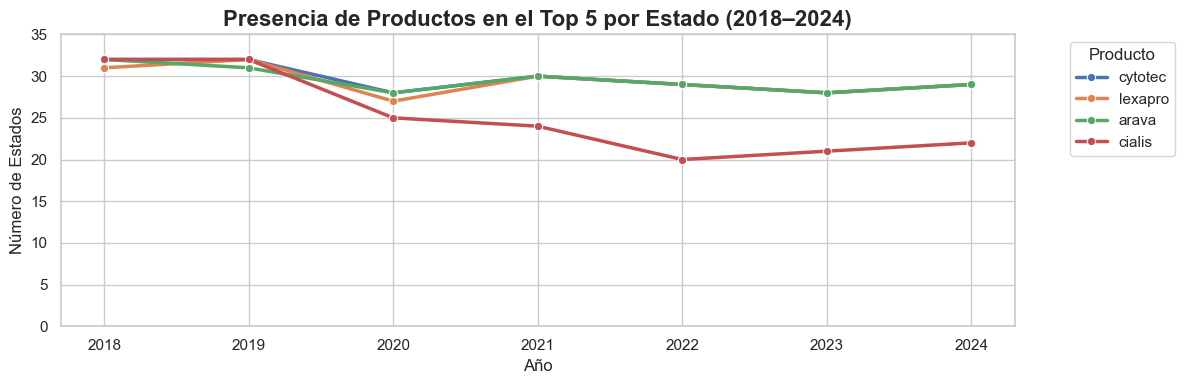

In [140]:
# Crear el gráfico automáticamente desde el DataFrame original
plt.figure(figsize=(12, 4))
sns.lineplot(data=df_top_filtered_auto, x="anio", y="count", hue="producto", marker="o", linewidth=2.5)

plt.title("Presencia de Productos en el Top 5 por Estado (2018–2024)", fontsize=16, weight='bold')
plt.xlabel("Año", fontsize=12)
plt.ylabel("Número de Estados", fontsize=12)
plt.ylim(0, 35)
plt.legend(title="Producto", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Cytotec fue el más dominante en 2018 y mantiene alta presencia hasta 2024.

Arava y Lexapro se han mantenido fuertes a lo largo de los años con presencia constante en ~29–32 estados.

Cialis arrancó fuerte, pero ha perdido terreno, cayendo a solo 22 estados en 2024.

### **f) ¿Cuáles son el top 5 de productos con menor precio en CDMX? (en aquel entonces Distrito Federal) ¿Verifica si te dió lo mismo en Spark?**

In [78]:
query_f_2 = """
WITH ranked_prices_cdmx AS (
    SELECT
        anio,
        producto,
        MIN(precio) AS precio_minimo,
        RANK() OVER (PARTITION BY anio ORDER BY MIN(precio) ASC) AS ranking
    FROM
        profeco_db.profeco
    WHERE
        precio IS NOT NULL
    AND 
        catalogo = 'medicamentos'
    -- AND 
    --    anio between 2018 and 2024
    AND
        estado = 'ciudad de mexico'
    GROUP BY
        anio, producto
)
SELECT
    anio,
    producto,
    precio_minimo,
    ranking
FROM
    ranked_prices_cdmx
WHERE
    ranking <= 5
ORDER BY
    precio_minimo, ranking;
"""
df_query_f_2 = wr.athena.read_sql_query(
    query_f_2, 
    database="profeco_db", 
    ctas_approach=False,
    boto3_session=session
)

In [80]:
# df_query_f_2.to_csv("./output_b/data_f_min.csv", index=False)
df_query_f_2.head()

anio           producto  precio_minimo  ranking
0  2023       ampliron duo           5.00        1
1  2020   guantes de latex           5.21        1
2  2021  gel antibacterial           5.40        1
3  2020  gel antibacterial           6.00        2
4  2021   metamizol sodico           6.63        2

En CDMX, los productos con menor precio entre 2020 y 2023 fueron:

-   Ampliron Duo en 2023 ($5.00)

-   Guantes de látex en 2020 ($5.21)

-   Gel antibacterial en 2020 y 2021 ($5.40 y $6.00)

-   Metamizol sódico en 2021 ($6.63)

Y sí dió lo mismo que en Pyspark

### **g) ¿Cuáles son el top 5 de productos con mayores observaciones? ¿Se parecen a las de nivel por estado? ¿Verifica si te dió lo mismo en Spark?**

In [88]:
query_g = """
WITH ranked_obs AS (
    SELECT
        anio,
        producto,
        COUNT(*) observaciones,
        RANK() OVER (PARTITION BY anio ORDER BY COUNT(*) DESC) AS ranking
    FROM
        profeco_db.profeco
    WHERE 
        catalogo = 'medicamentos'
    -- AND 
    --    anio between 2018 and 2022
    GROUP BY
        anio, producto
)
SELECT
    anio,
    producto,
    observaciones,
    ranking
FROM
    ranked_obs
WHERE
    ranking <= 5
ORDER BY
    anio, ranking;
"""
df_query_g = wr.athena.read_sql_query(
    query_g, 
    database="profeco_db", 
    ctas_approach=False,
    boto3_session=session
)

In [142]:
df_query_g.to_csv("./output_b/data_g.csv", index=False)
df_query_g = pd.read_csv("./output_b/data_g.csv")
df_query_g.head(50)

anio           producto  observaciones  ranking
0   2018             cialis          33544        1
1   2018     celestamine-ns          32239        2
2   2018           micardis          31421        3
3   2018             lyrica          31055        4
4   2018           celebrex          30505        5
..   ...                ...            ...      ...
30  2024  gel antibacterial          14015        1
31  2024         cubrebocas          12566        2
32  2024             tabcin          10987        3
33  2024       cafiaspirina          10387        4
34  2024     venda elastica           7071        5

[35 rows x 4 columns]

In [152]:
pivot_prod = df_query_g.pivot(index="anio", columns="ranking", values="producto").reset_index()
pivot_prod

ranking  anio                  1                  2           3  \
0        2018             cialis     celestamine-ns    micardis   
1        2019           micardis             cialis      lyrica   
2        2020             tabcin  gel antibacterial      cialis   
3        2021  gel antibacterial             tabcin  cubrebocas   
4        2022  gel antibacterial             tabcin  cubrebocas   
5        2023  gel antibacterial         cubrebocas      tabcin   
6        2024  gel antibacterial         cubrebocas      tabcin   

ranking               4               5  
0                lyrica        celebrex  
1        celestamine-ns         lexapro  
2        celestamine-ns          lyrica  
3          cafiaspirina  venda elastica  
4          cafiaspirina  venda elastica  
5          cafiaspirina          cialis  
6          cafiaspirina  venda elastica

In [153]:
pivot_obs = df_query_g.pivot(index="anio", columns="ranking", values="observaciones").reset_index()
pivot_obs

ranking  anio      1      2      3      4      5
0        2018  33544  32239  31421  31055  30505
1        2019  25812  25649  25262  25036  23681
2        2020  31549  26780  21749  21104  19902
3        2021  45671  42167  36825  31151  26189
4        2022  52479  45145  45031  39448  30004
5        2023  55492  51838  47339  41314  27204
6        2024  14015  12566  10987  10387   7071

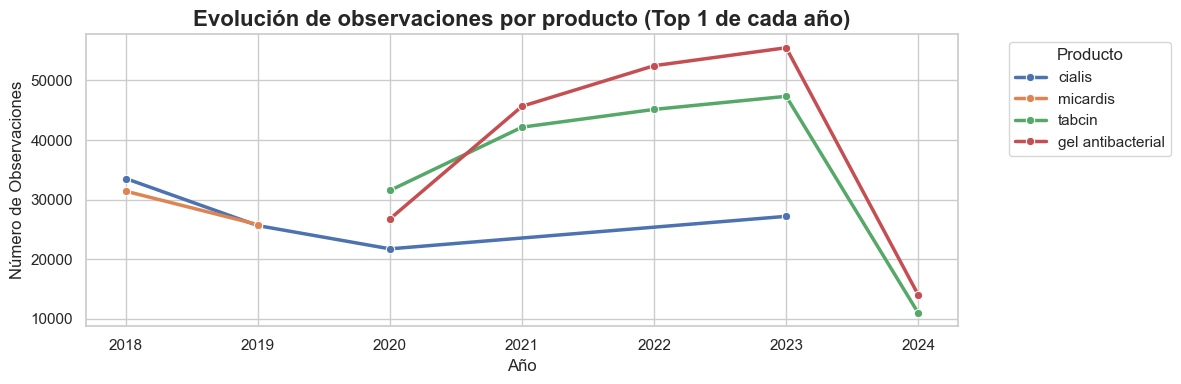

In [159]:
# Convertir a formato largo
prod_melted = pivot_prod.melt(id_vars="anio", var_name="ranking", value_name="producto")
obs_melted = pivot_obs.melt(id_vars="anio", var_name="ranking", value_name="observaciones")
df_graf = pd.merge(prod_melted, obs_melted, on=["anio", "ranking"])

# Filtrar productos más frecuentes como top 1
top_productos = df_graf[df_graf["ranking"] == 1]["producto"].unique()
df_filtered = df_graf[df_graf["producto"].isin(top_productos)]

plt.figure(figsize=(12, 4))
sns.lineplot(data=df_filtered, x="anio", y="observaciones", hue="producto", marker="o", linewidth=2.5)
plt.title("Evolución de observaciones por producto (Top 1 de cada año)", fontsize=16, weight='bold')
plt.xlabel("Año", fontsize=12)
plt.ylabel("Número de Observaciones", fontsize=12)
plt.legend(title="Producto", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Top 5 de productos con más observaciones por año**

Se identifican claramente productos recurrentes como Gel antibacterial, Tabcin, Cubrebocas y Cialis, con presencia constante entre los primeros lugares.

Desde 2021 a 2024, gel antibacterial es el más reportado, con más de 50,000 observaciones en 2023, destacando por su relevancia post-pandemia.

En años previos (2018–2019), el top estaba dominado por medicamentos como Cialis, Micardis, Lyrica y Celestamine-NS, todos relacionados con tratamientos crónicos o de uso generalizado.


**Los resultados ya fueron verificados y coinciden con los obtenidos en PySpark, lo que valida la consistencia entre plataformas.**

### **g2) Genera un boxplot por año, para cada una de las top 5 productos de tu categoría**

In [167]:
df_query_g

anio           producto  observaciones  ranking
0   2018             cialis          33544        1
1   2018     celestamine-ns          32239        2
2   2018           micardis          31421        3
3   2018             lyrica          31055        4
4   2018           celebrex          30505        5
5   2019           micardis          25812        1
6   2019             cialis          25649        2
7   2019             lyrica          25262        3
8   2019     celestamine-ns          25036        4
9   2019            lexapro          23681        5
10  2020             tabcin          31549        1
11  2020  gel antibacterial          26780        2
12  2020             cialis          21749        3
13  2020     celestamine-ns          21104        4
14  2020             lyrica          19902        5
15  2021  gel antibacterial          45671        1
16  2021             tabcin          42167        2
17  2021         cubrebocas          36825        3
18  2021       cafiaspirina          31151        4
19  2021     venda elastica          26189        5
20  2022  gel antibacterial          52479        1
21  2022             tabcin          45145        2
22  2022         cubrebocas          45031        3
23  2022       cafiaspirina          39448        4
24  2022     venda elastica          30004        5
25  2023  gel antibacterial          55492        1
26  2023         cubrebocas          51838        2
27  2023             tabcin          47339        3
28  2023       cafiaspirina          41314        4
29  2023             cialis          27204        5
30  2024  gel antibacterial          14015        1
31  2024         cubrebocas          12566        2
32  2024             tabcin          10987        3
33  2024       cafiaspirina          10387        4
34  2024     venda elastica           7071        5

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/580377578.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x="anio", y="observaciones", palette="Blues", width=0.6)


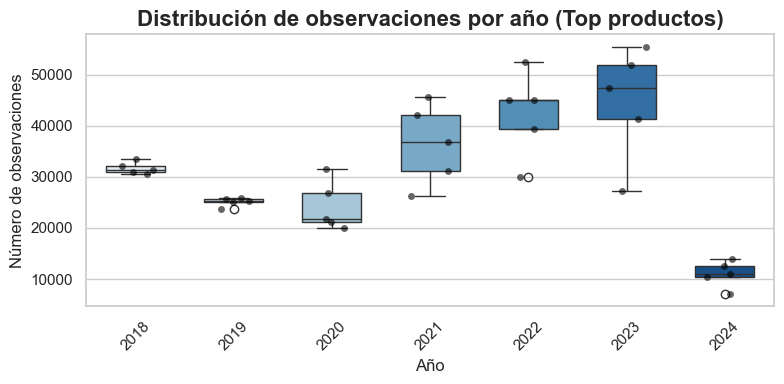

In [ ]:
# Ejecutar la función
graficar_boxplot_observaciones(df_query_g)

-   En 2018 y 2019 los productos más observados tenían cantidades similares, con pocas diferencias entre ellos.

-   Desde 2020 empezó a haber más variación entre productos y subieron las observaciones.

-   En 2021, 2022 y 2023 hubo un aumento fuerte, con productos como gel antibacterial y cubrebocas destacando.

-   En 2024 bajaron mucho las observaciones, probablemente porque aún no se completa el registro de ese año.

# Apéndice (Top "N" por categoría dado el año y el catálogo)

In [175]:
def graficar_categorias_por_catalogo_con_otros(df, anio_objetivo, top_n=5,
                                               col_anio='anio', col_catalogo='catalogo',
                                               col_categoria='categoria', col_valor='cont_anio_categoria'):
    """
    Gráfico de pastel para todos los catálogos de un año, mostrando top_n categorías
    y agrupando el resto como 'Otros', con una paleta profesional.
    """
    df_anio = df[df[col_anio] == anio_objetivo]
    catalogos = df_anio[col_catalogo].unique()

    if len(catalogos) == 0:
        print(f"No hay datos para el año {anio_objetivo}.")
        return

    num_catalogos = len(catalogos)
    cols = 3
    rows = (num_catalogos + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows))
    axes = axes.flatten()

    for i, catalogo in enumerate(catalogos):
        ax = axes[i]
        df_cat = df_anio[df_anio[col_catalogo] == catalogo]
        df_grouped = df_cat.groupby(col_categoria)[col_valor].sum()

        top_cats = df_grouped.sort_values(ascending=False).head(top_n)
        otros_valor = df_grouped.sum() - top_cats.sum()

        if otros_valor > 0:
            top_cats["Otros"] = otros_valor

        cmap = cm.get_cmap("tab20")
        colors = [cmap(j) for j in np.linspace(0, 1, len(top_cats))]

        ax.pie(
            top_cats.values,
            labels=top_cats.index,
            wedgeprops=dict(width=0.5),
            autopct='%1.1f%%',
            startangle=140,
            textprops={'fontsize': 11},
            colors=colors
        )
        ax.set_title(f'{catalogo.title()} - {anio_objetivo}', fontsize=14)
        ax.axis('equal')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()




In [191]:
conteo_categoria_anio = pd.read_csv("./csvs_PA/completo.csv")

TOP 6 por año (con 20 se ve muy sucia la imagen)

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")
/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")
/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab

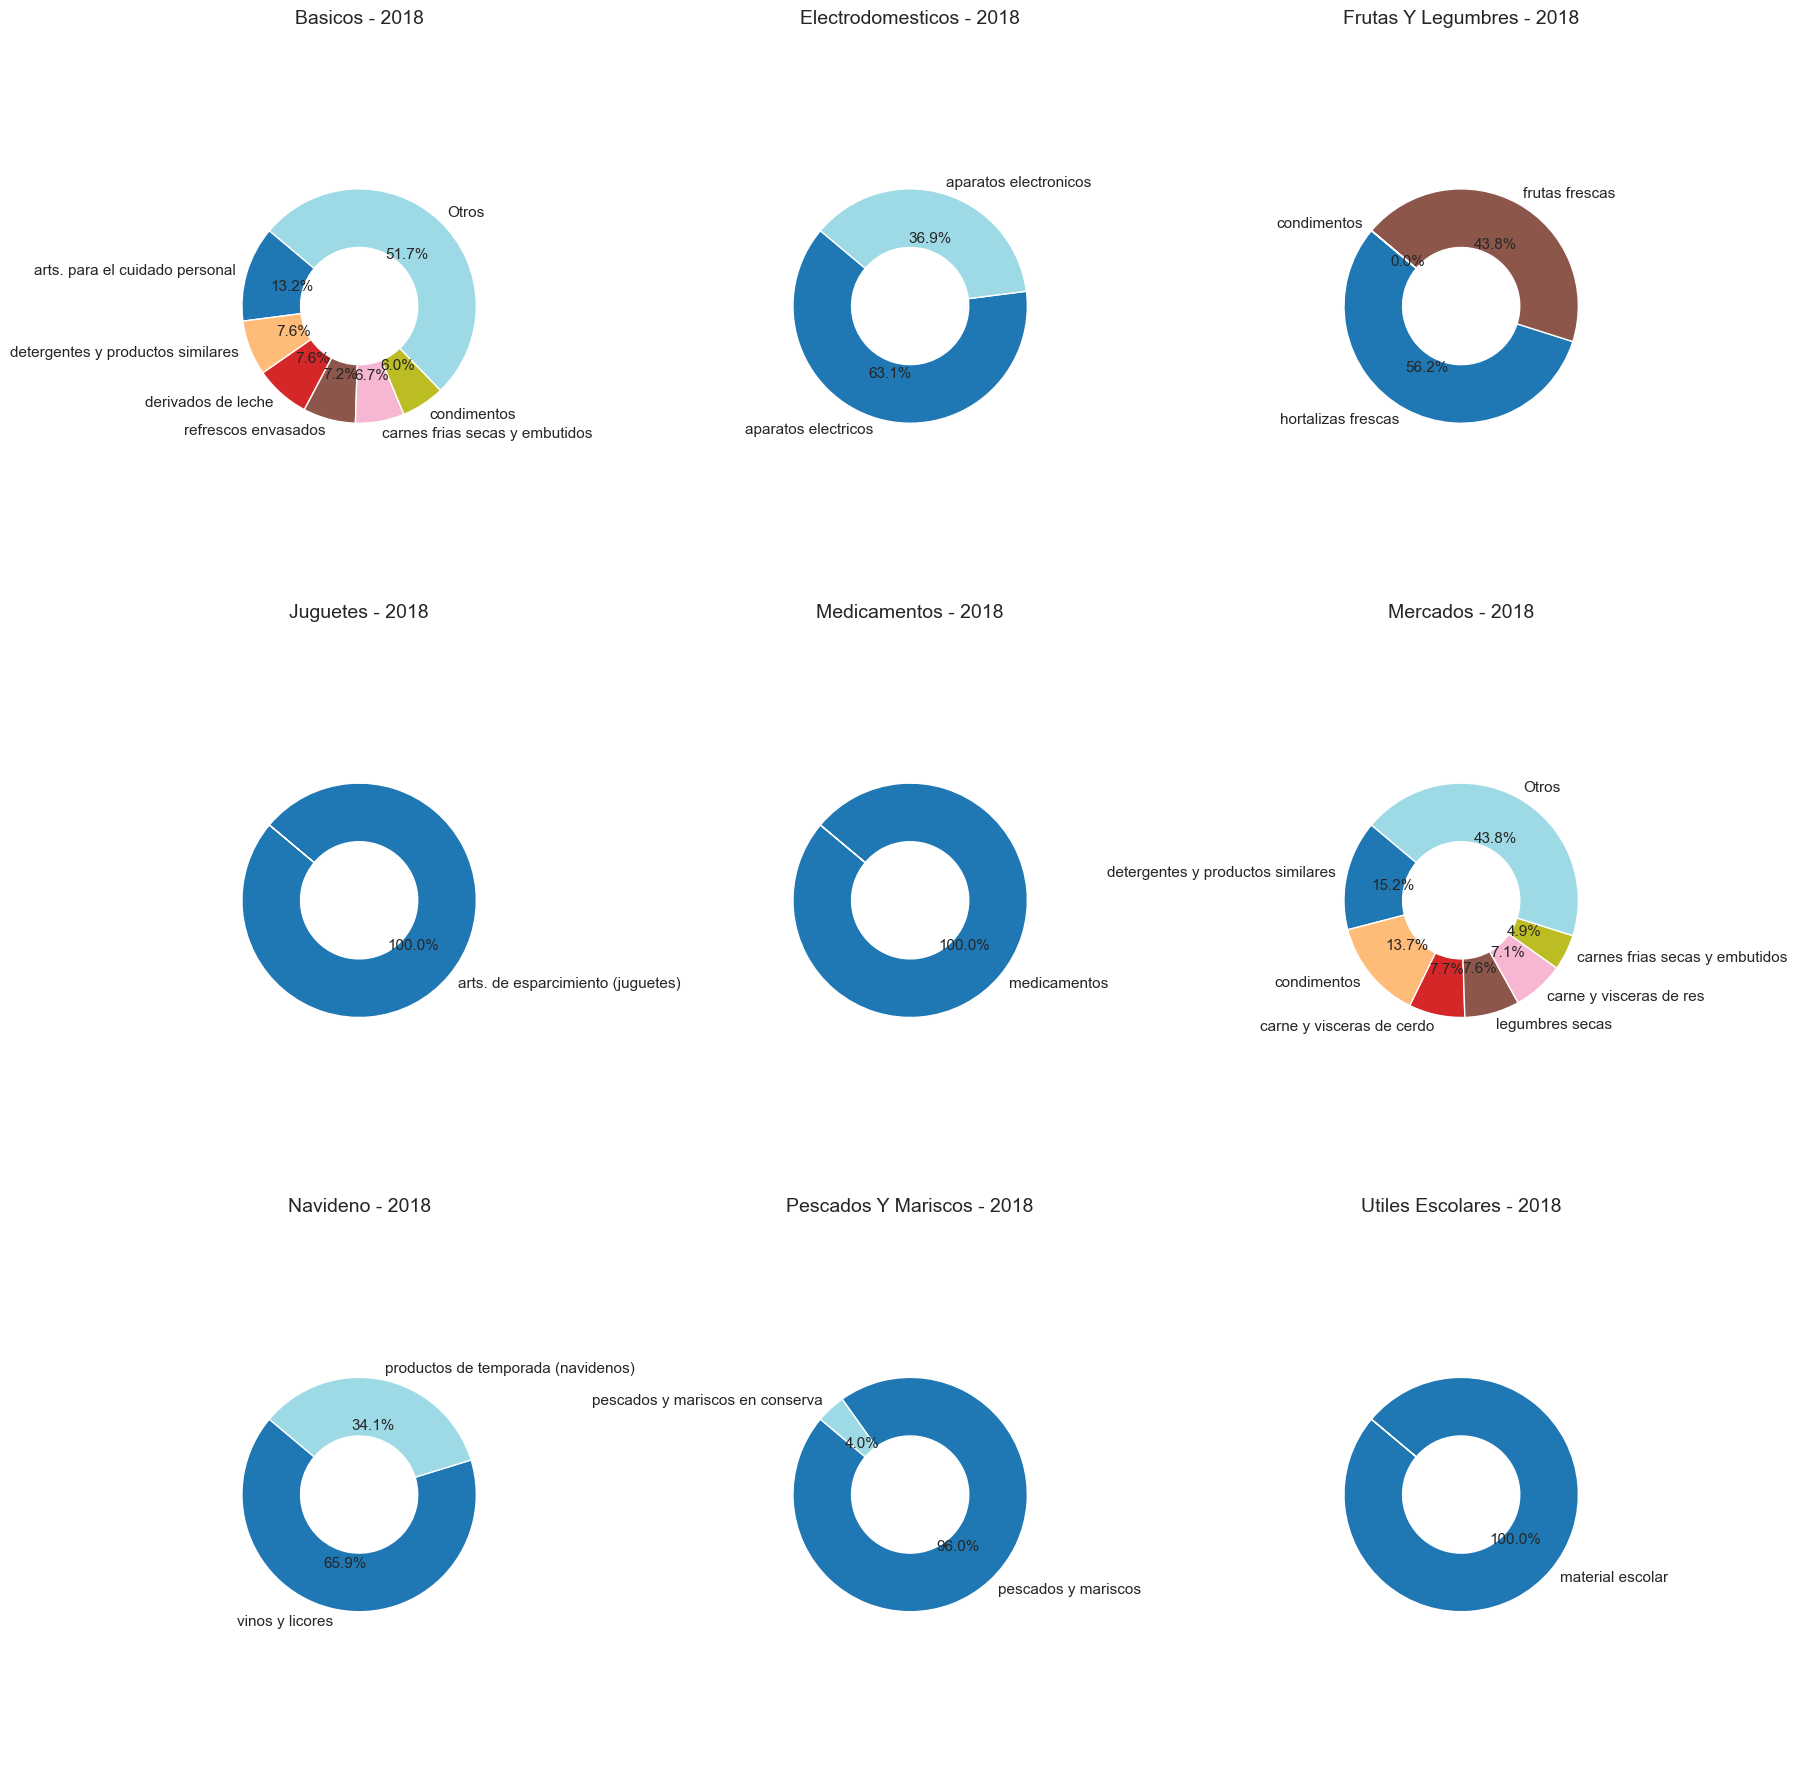

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")
/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")
/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab

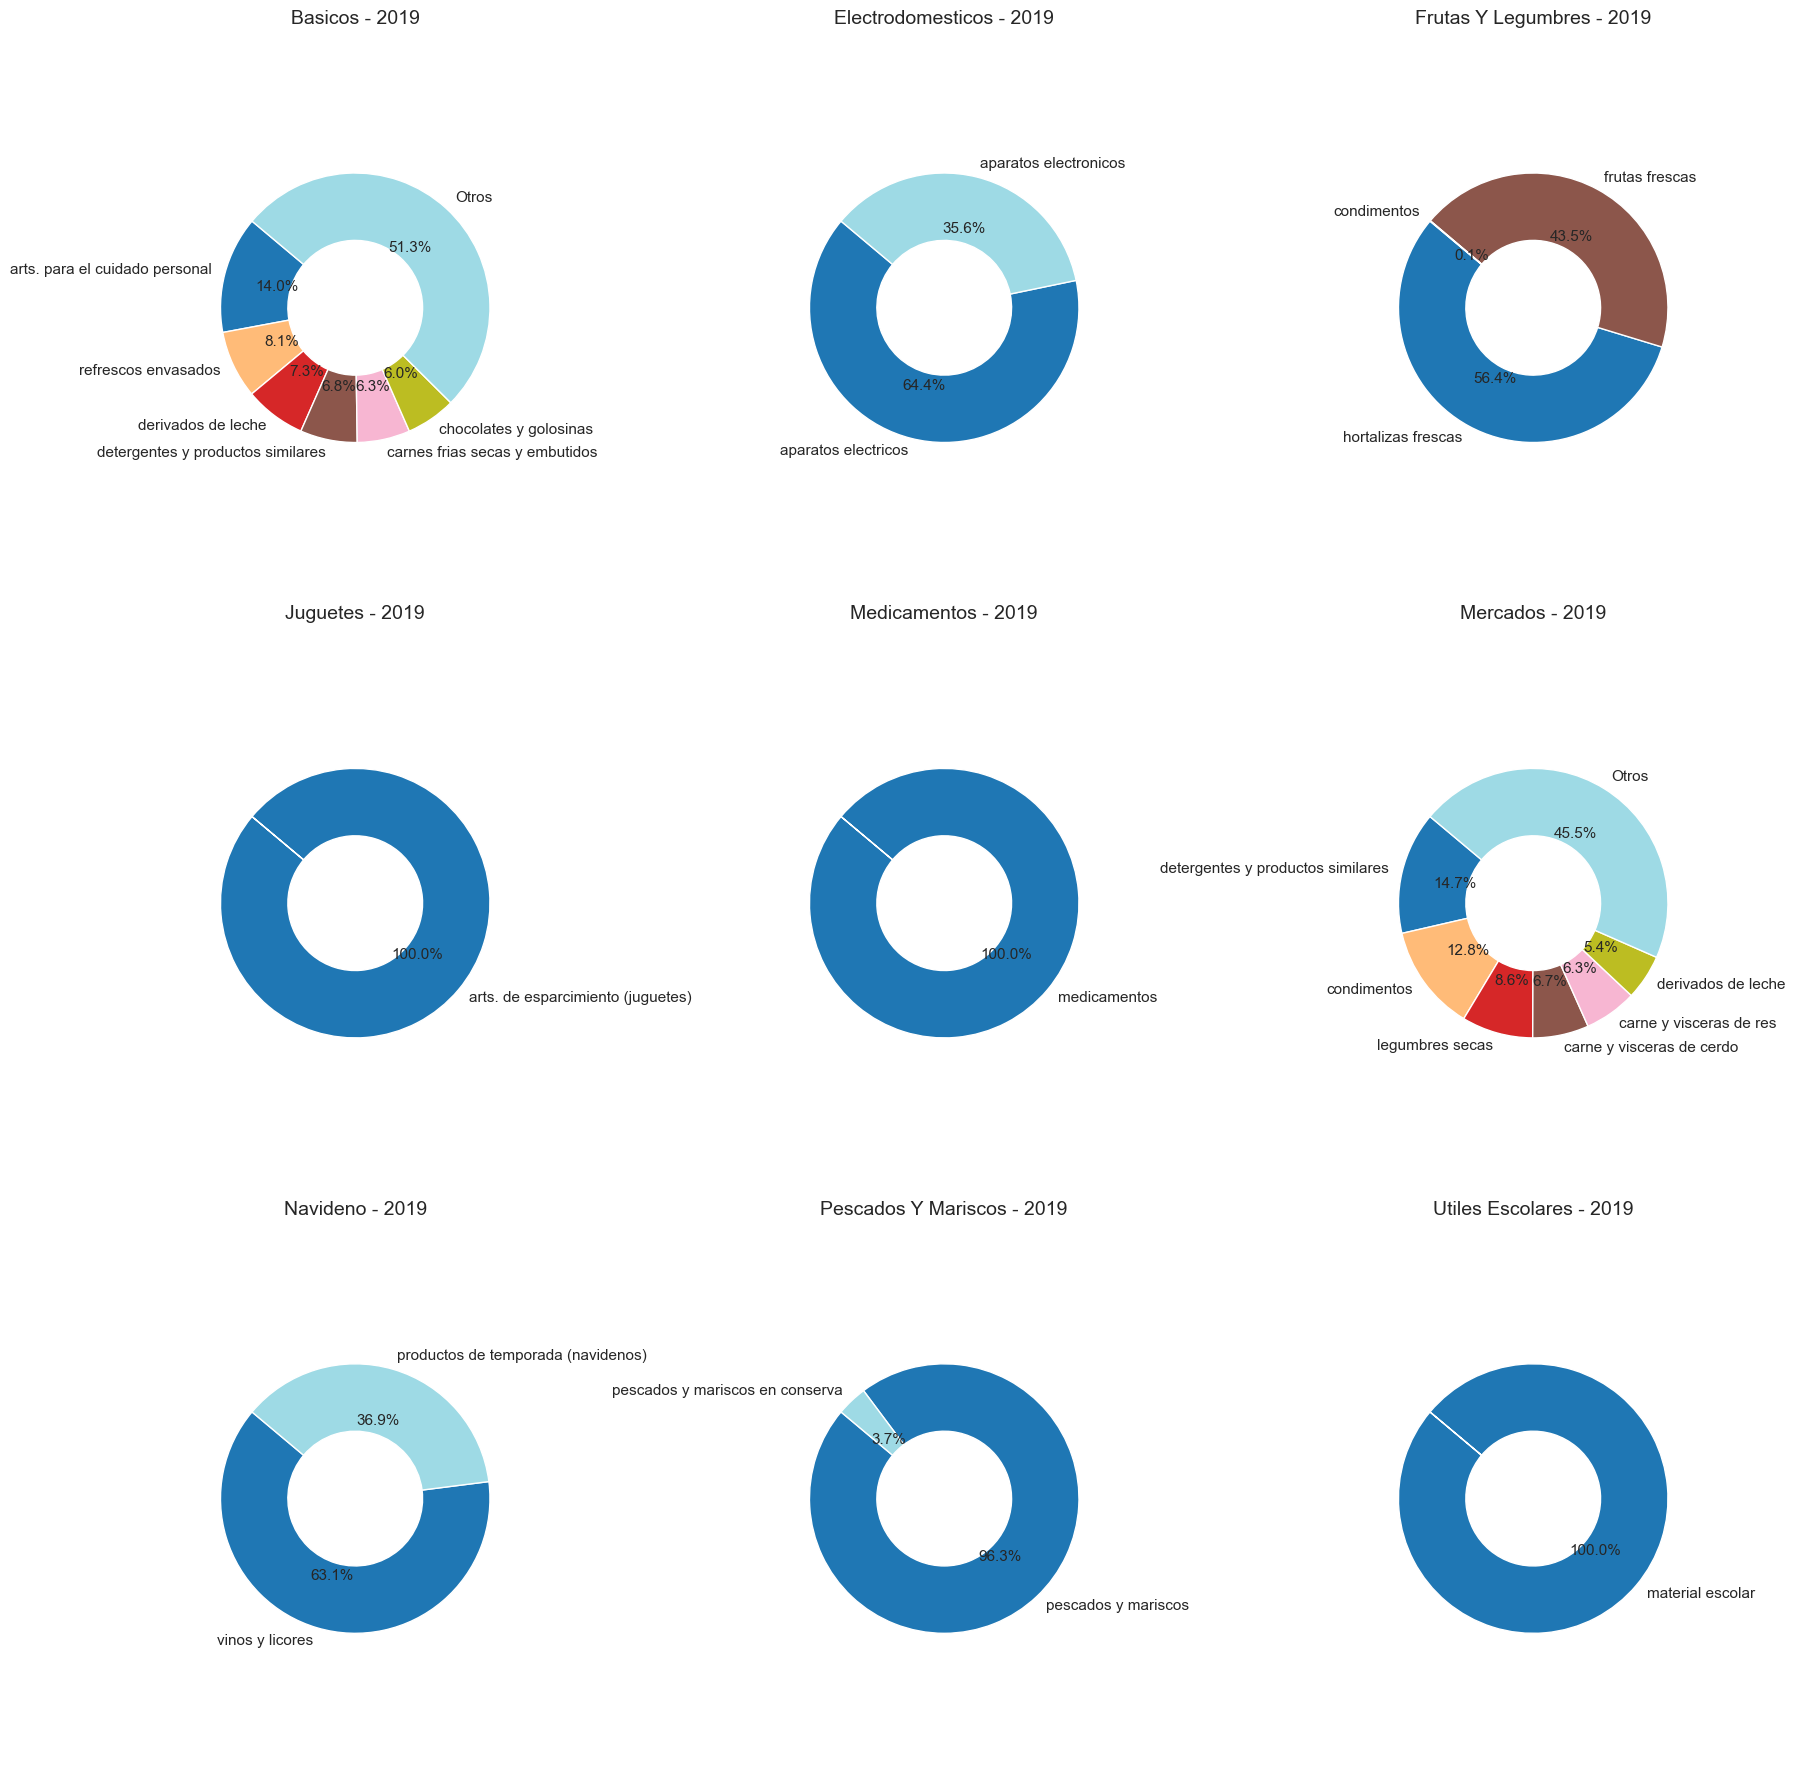

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")
/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")
/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab

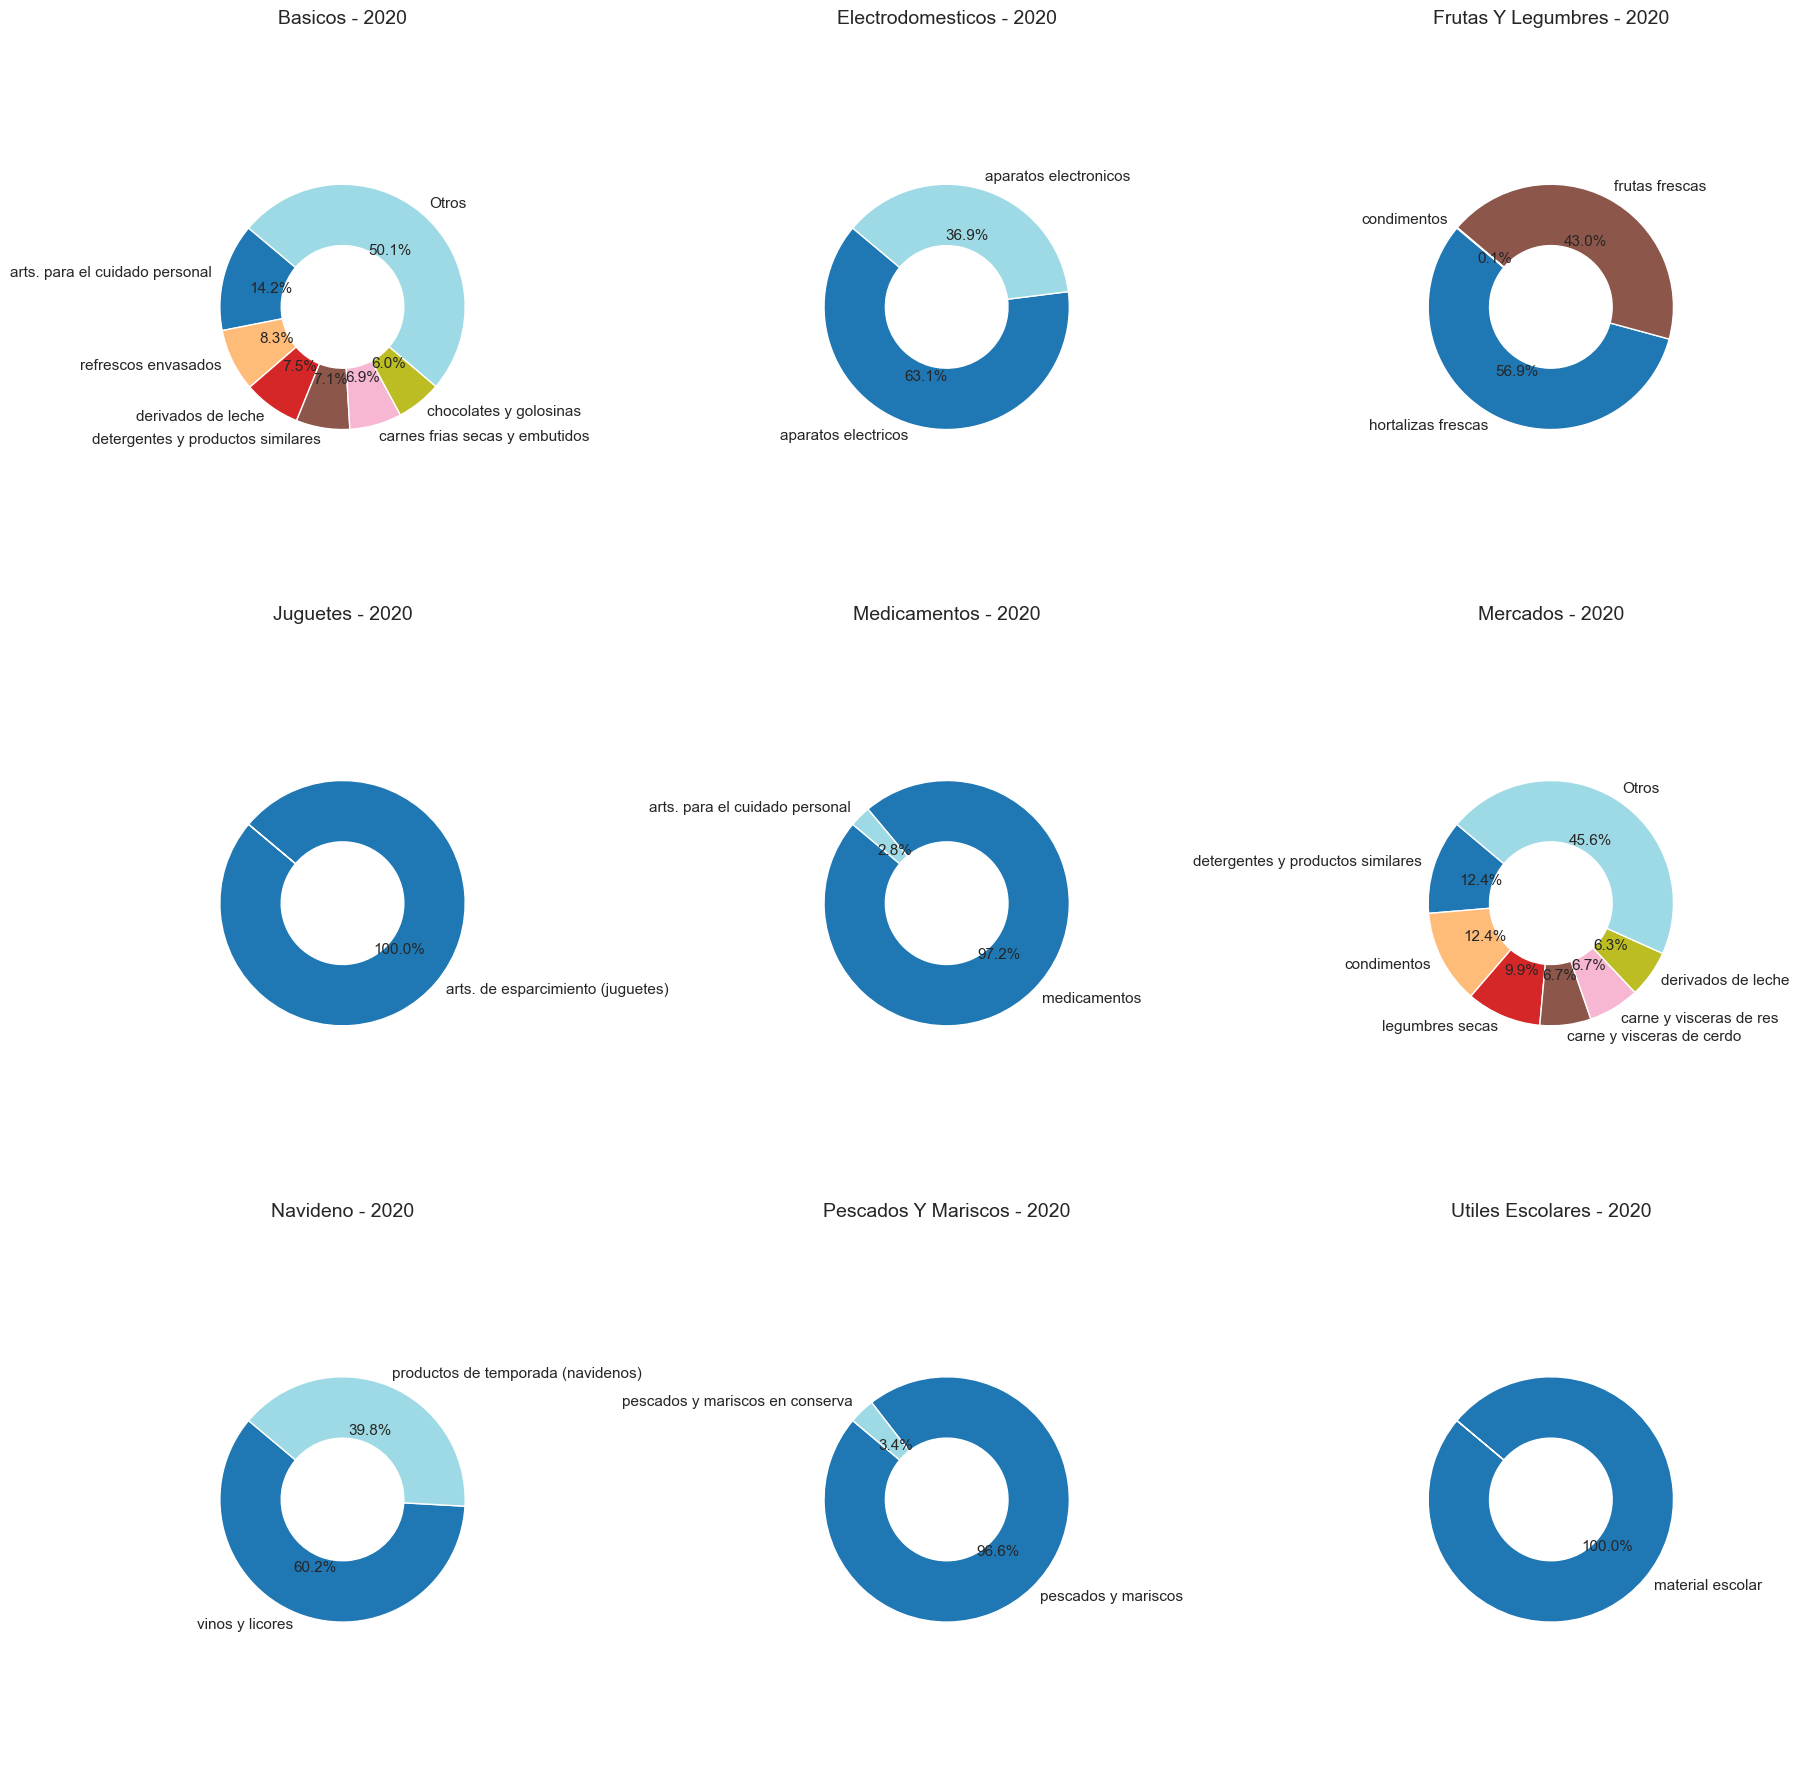

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")
/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")
/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab

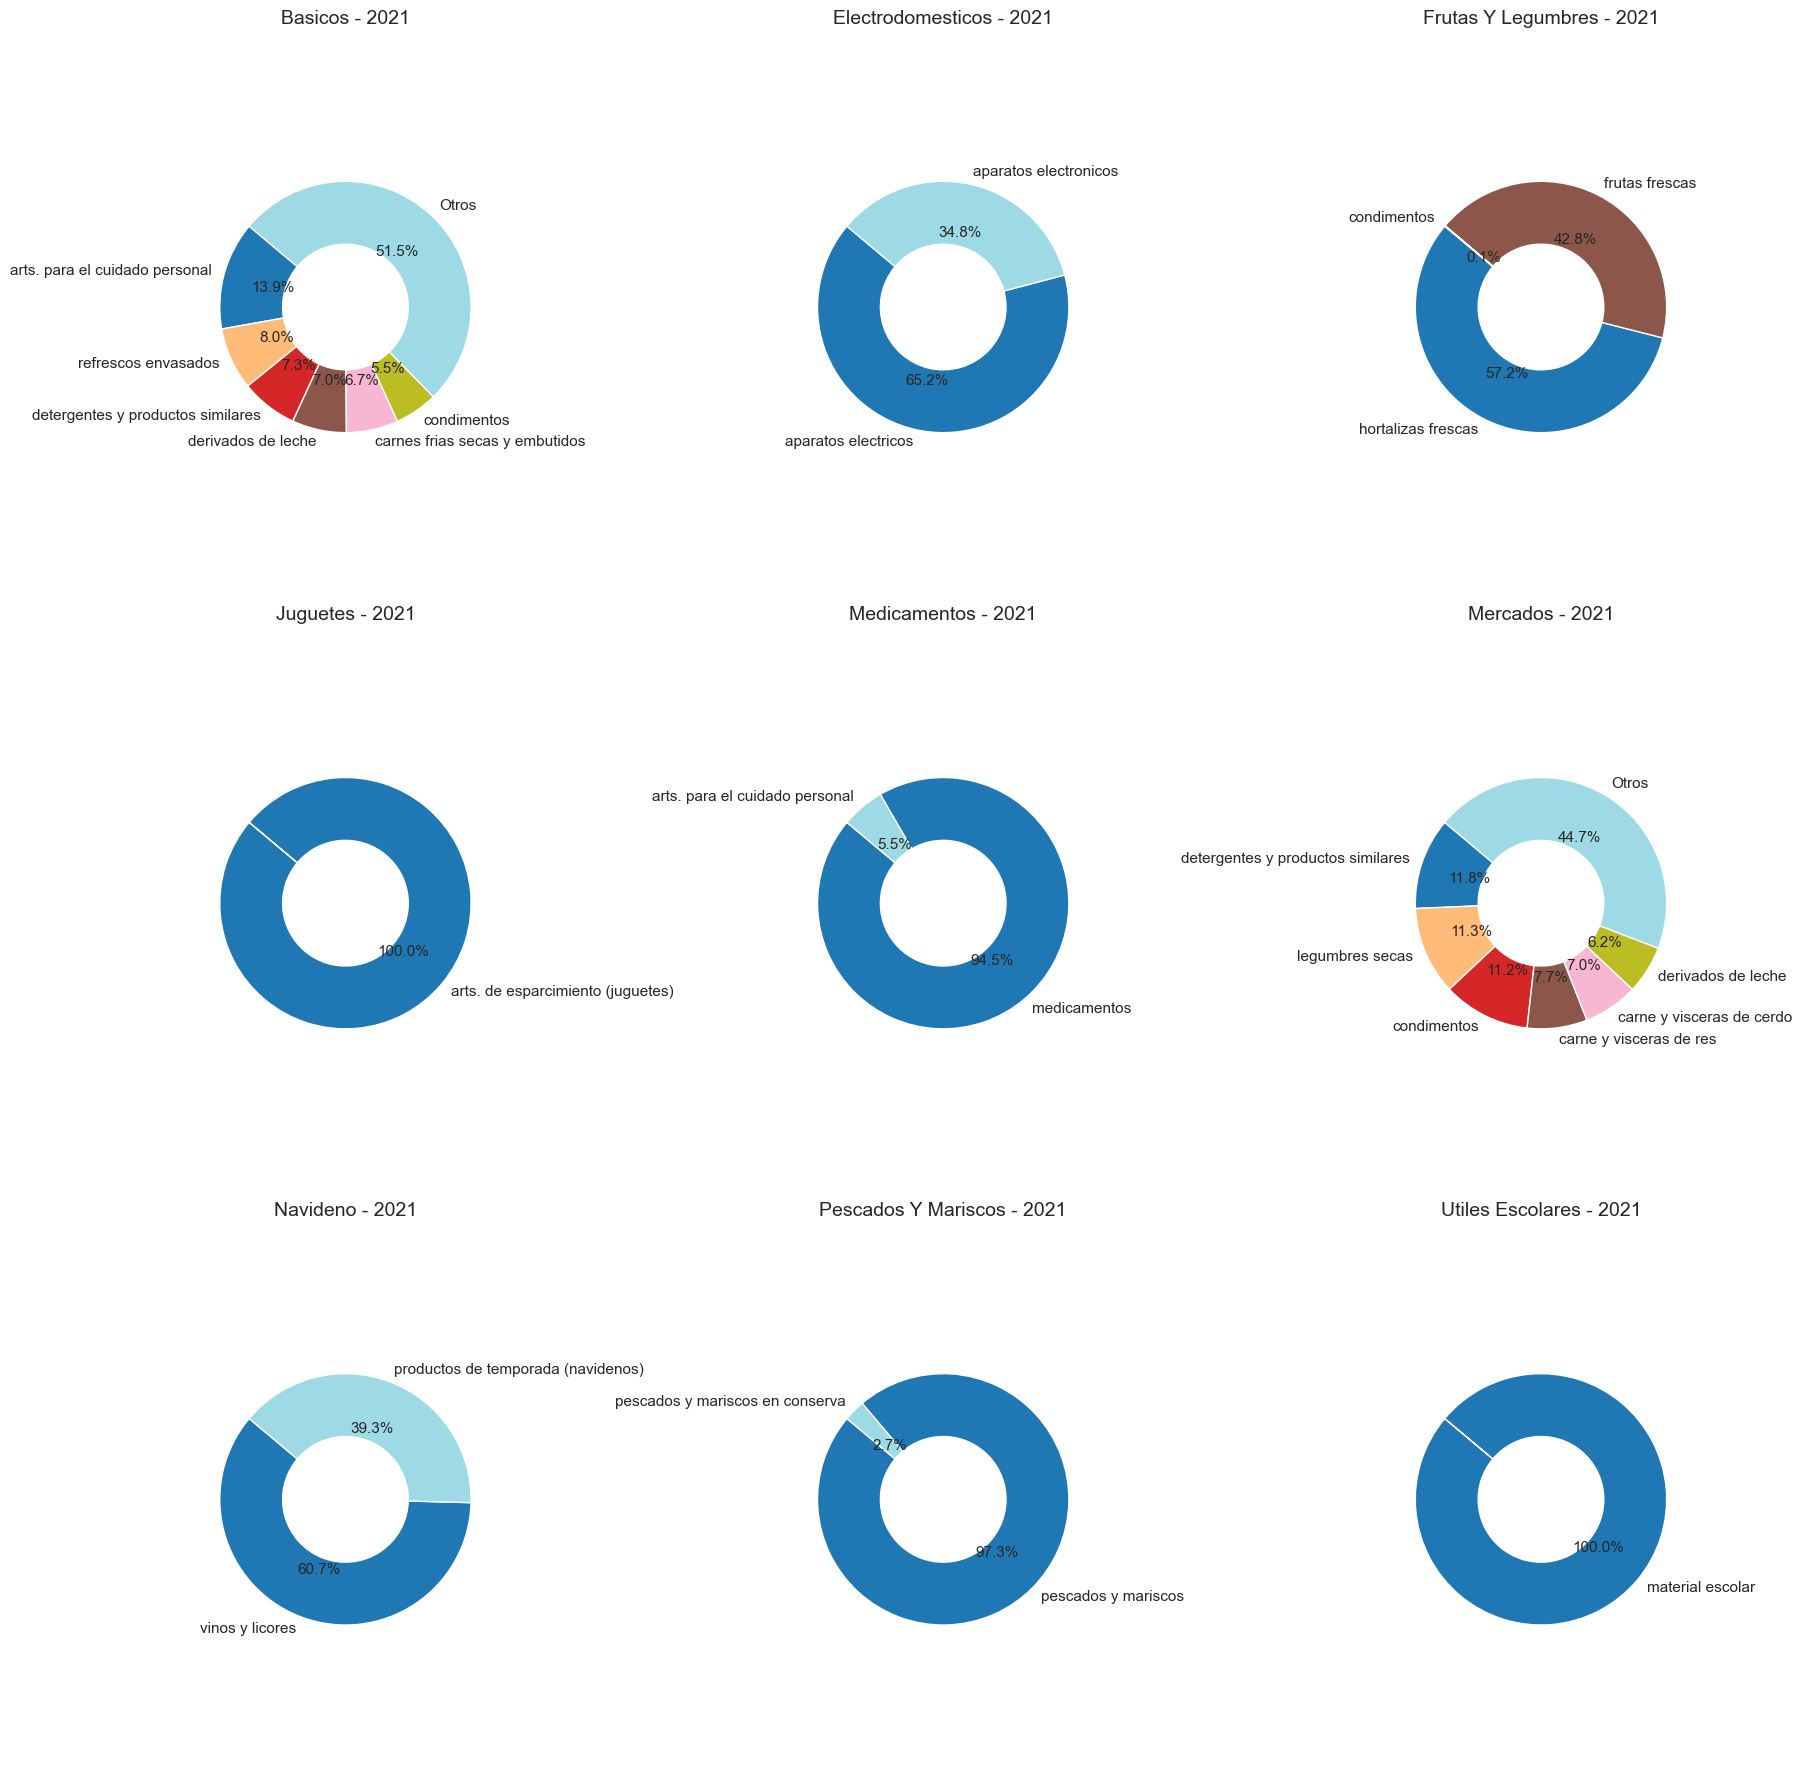

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")
/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")
/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab

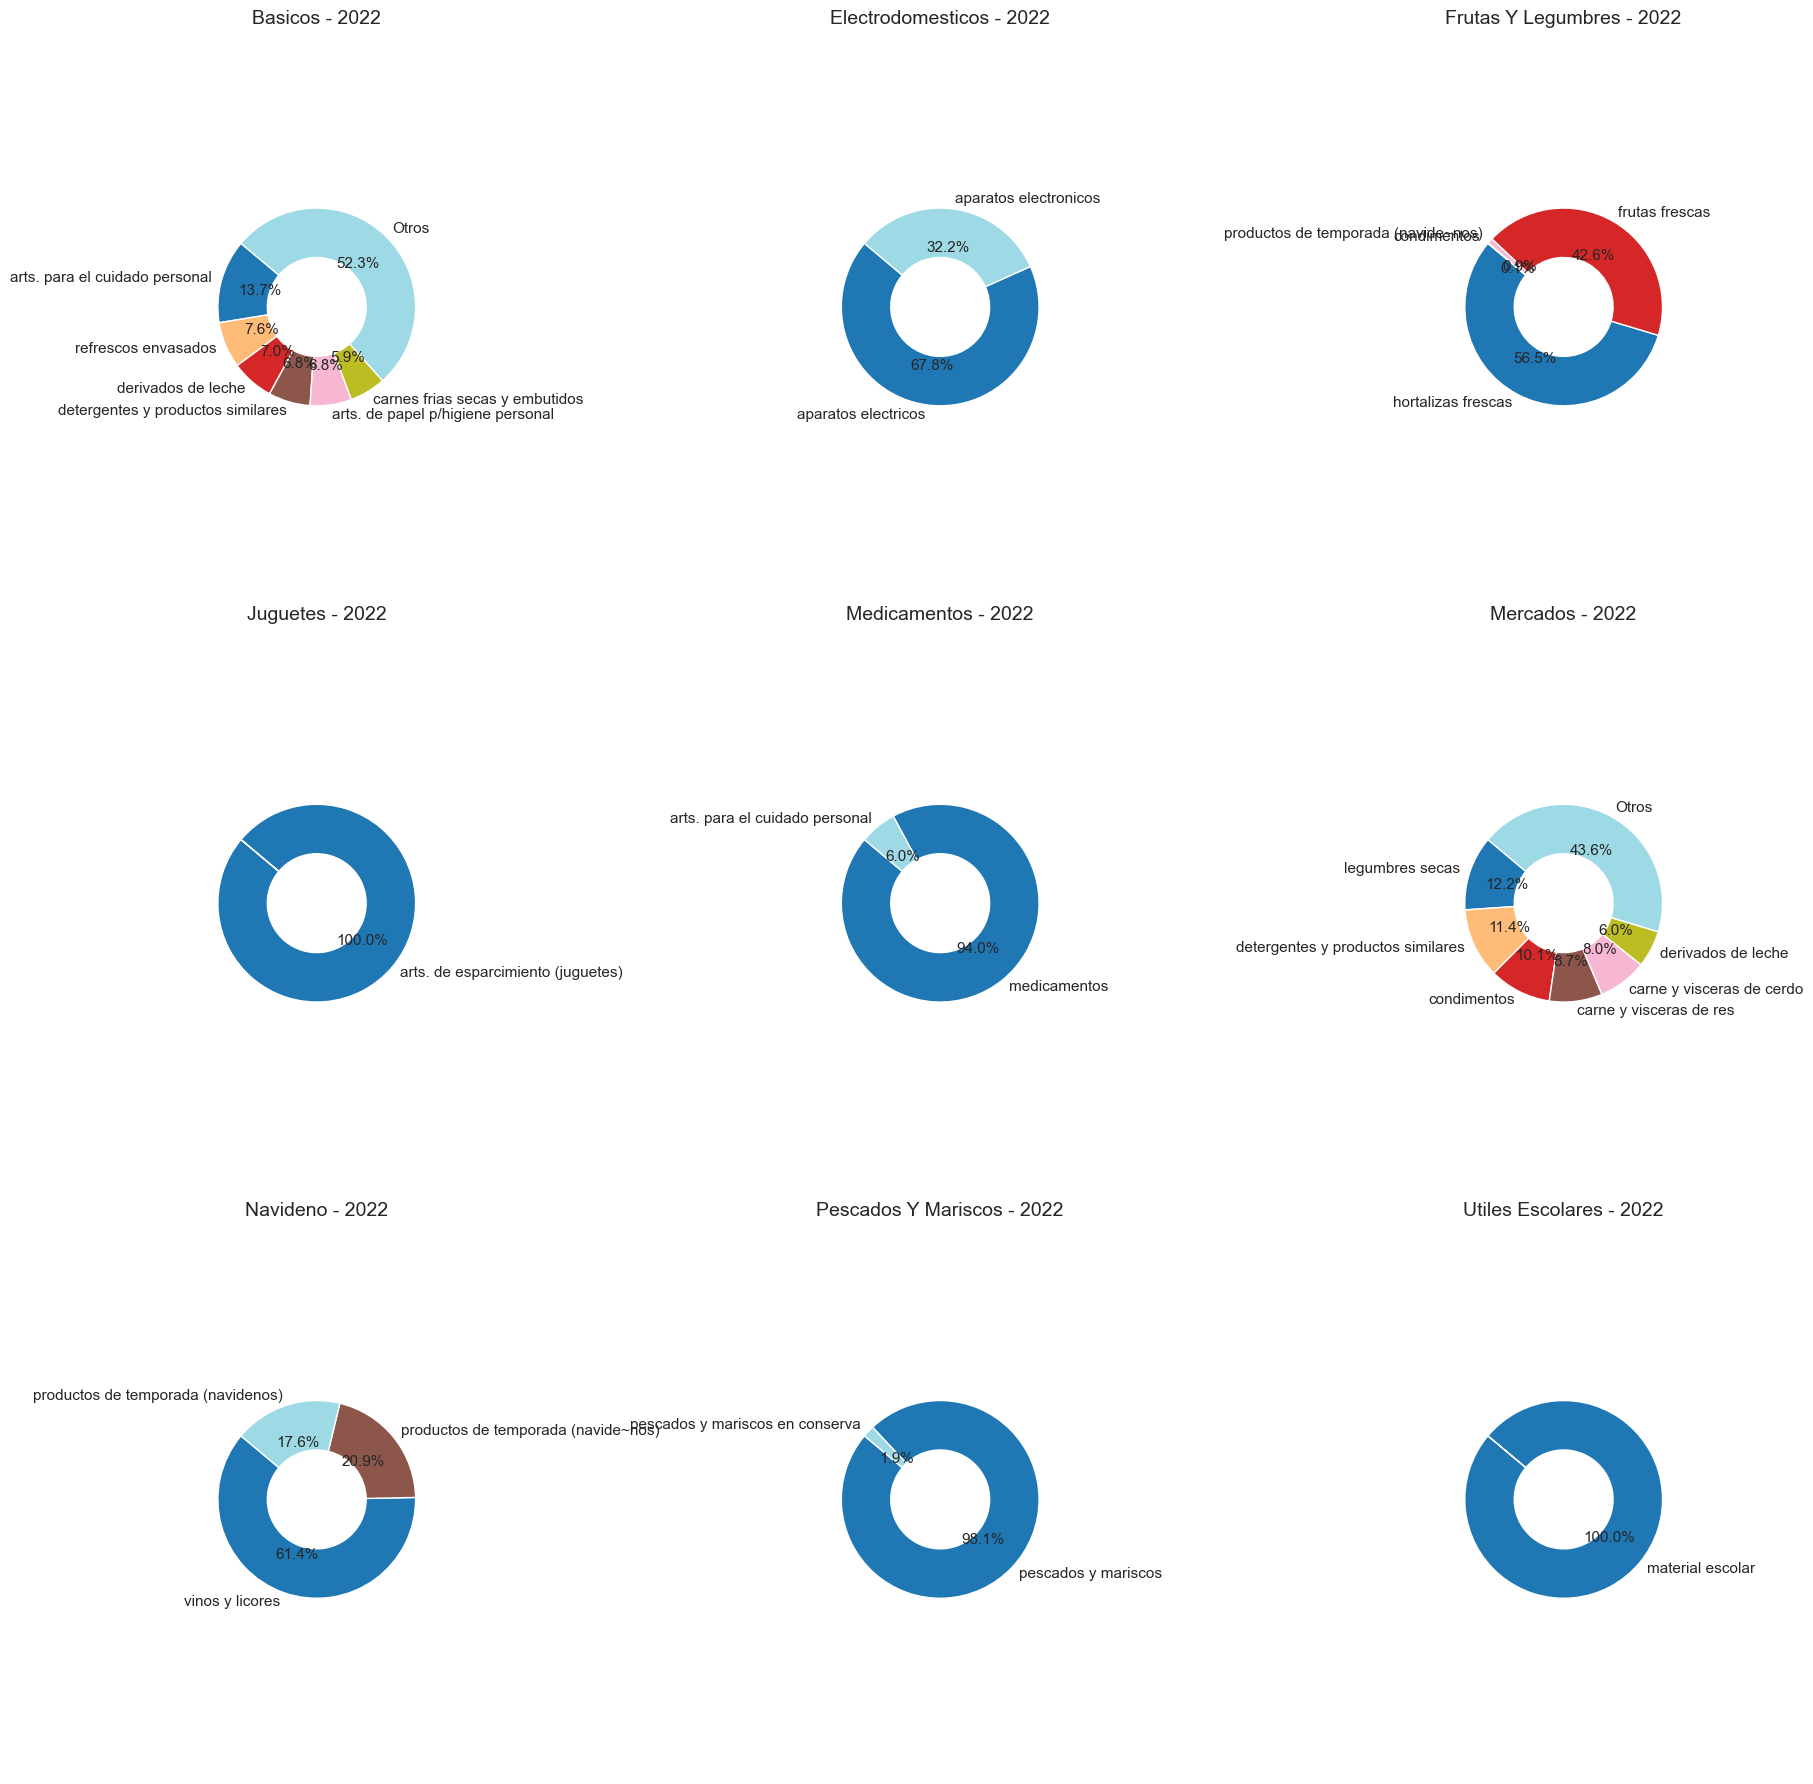

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")
/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")
/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab

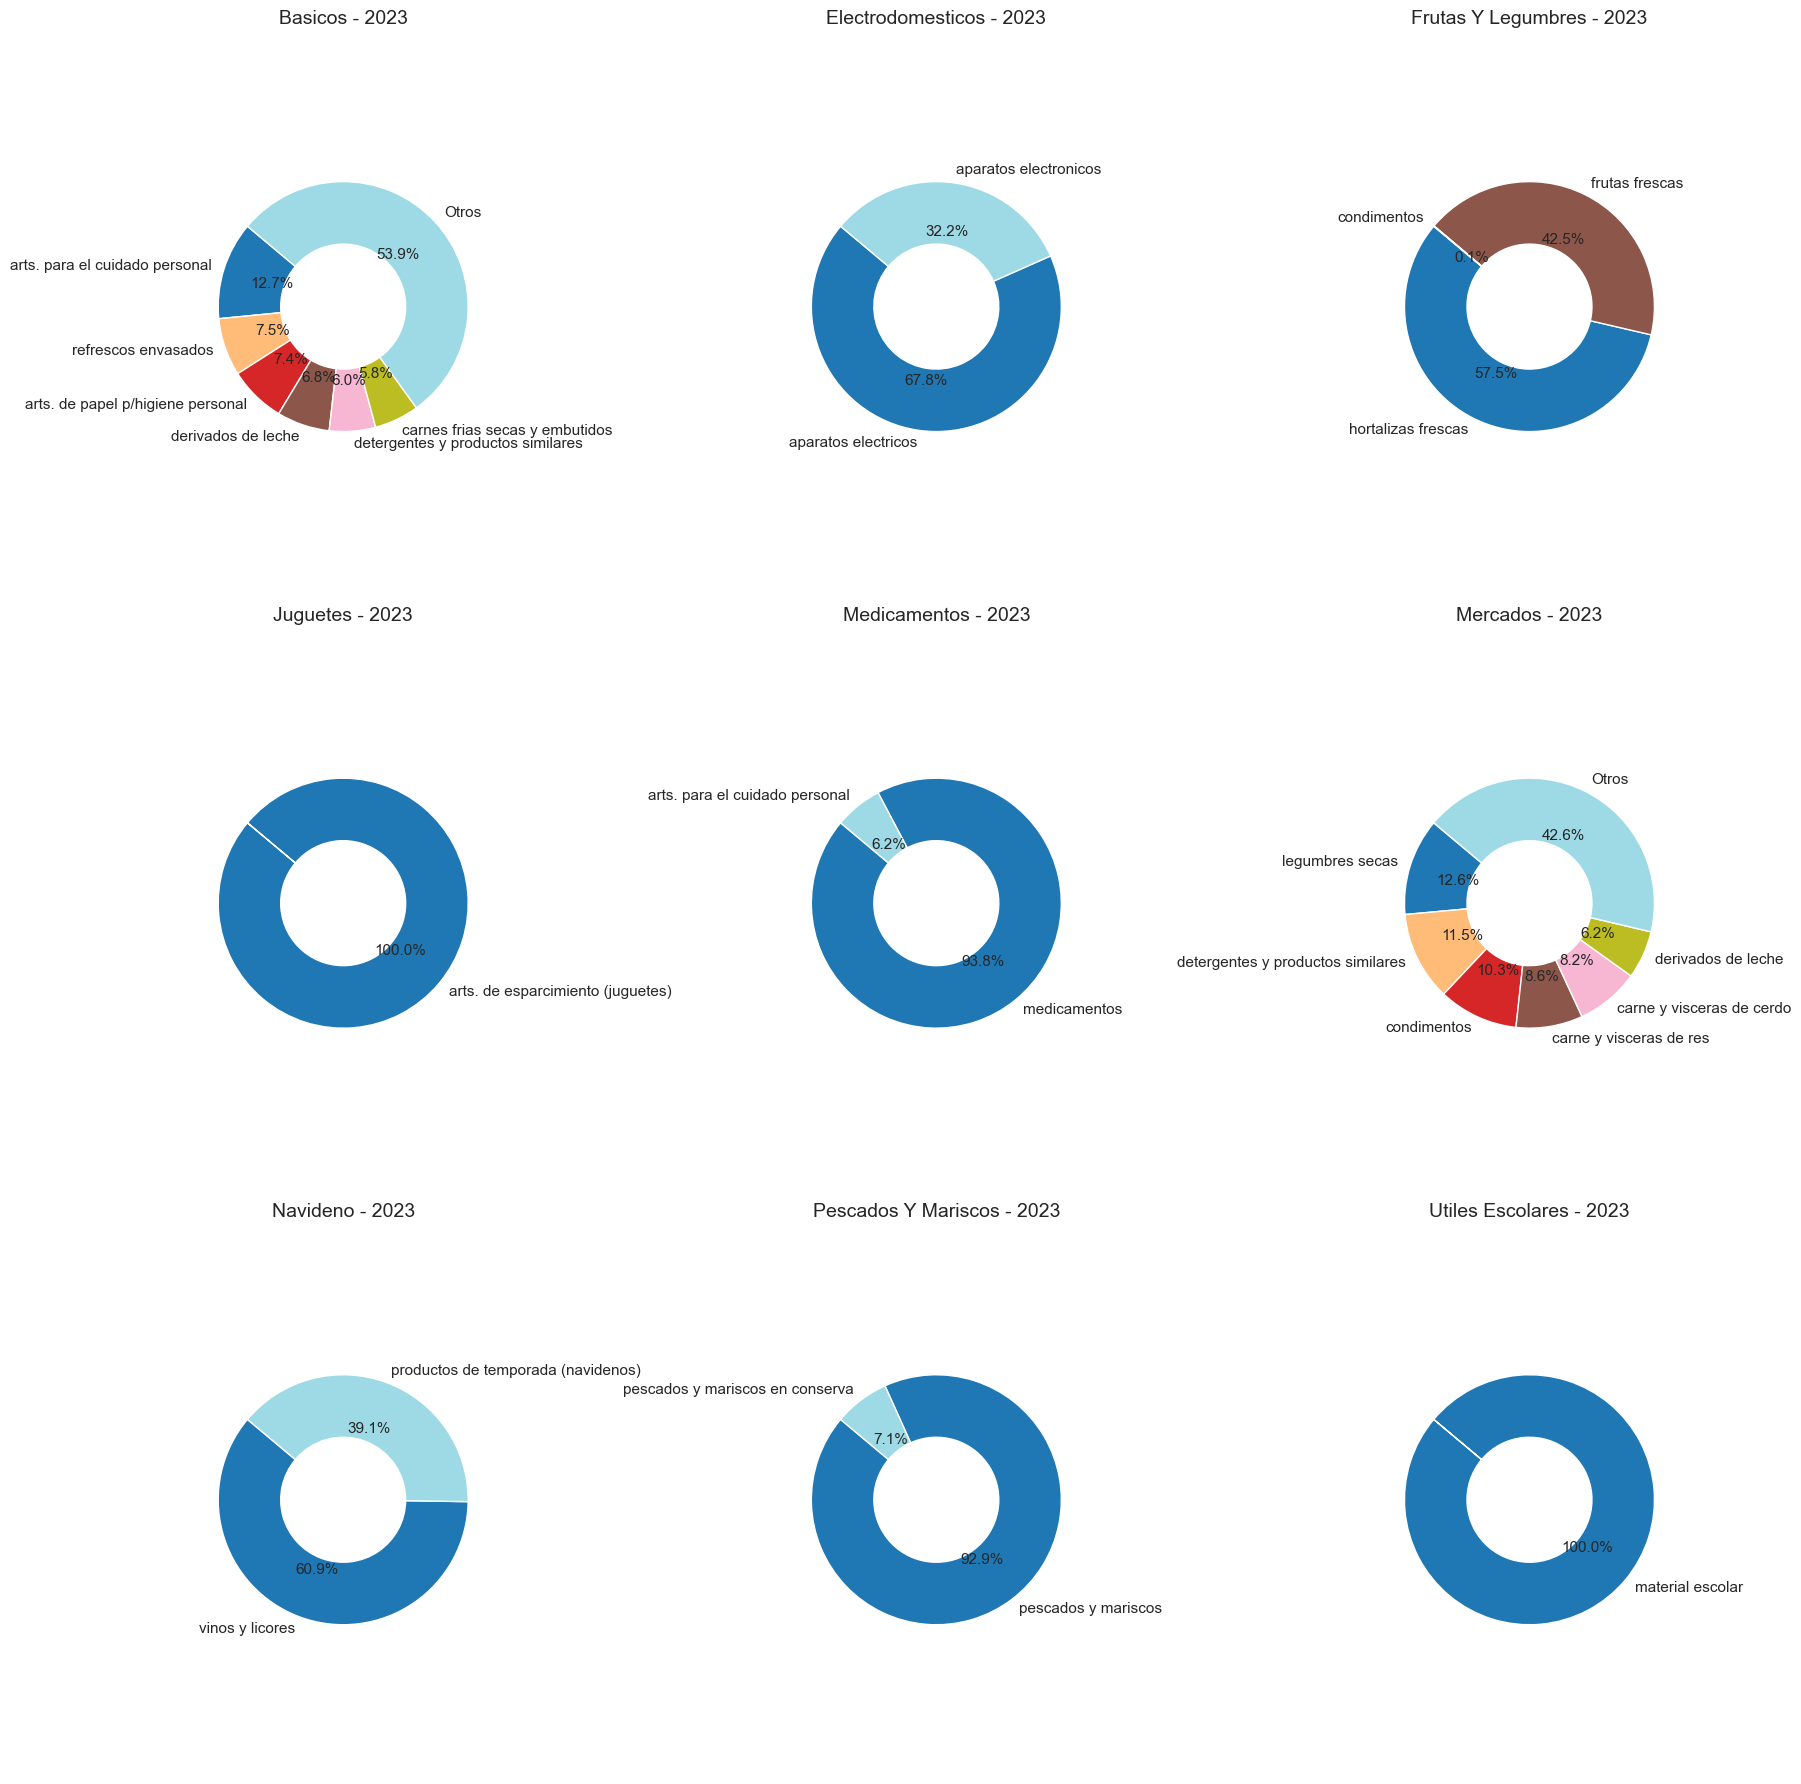

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")
/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")
/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_27285/3481034851.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab

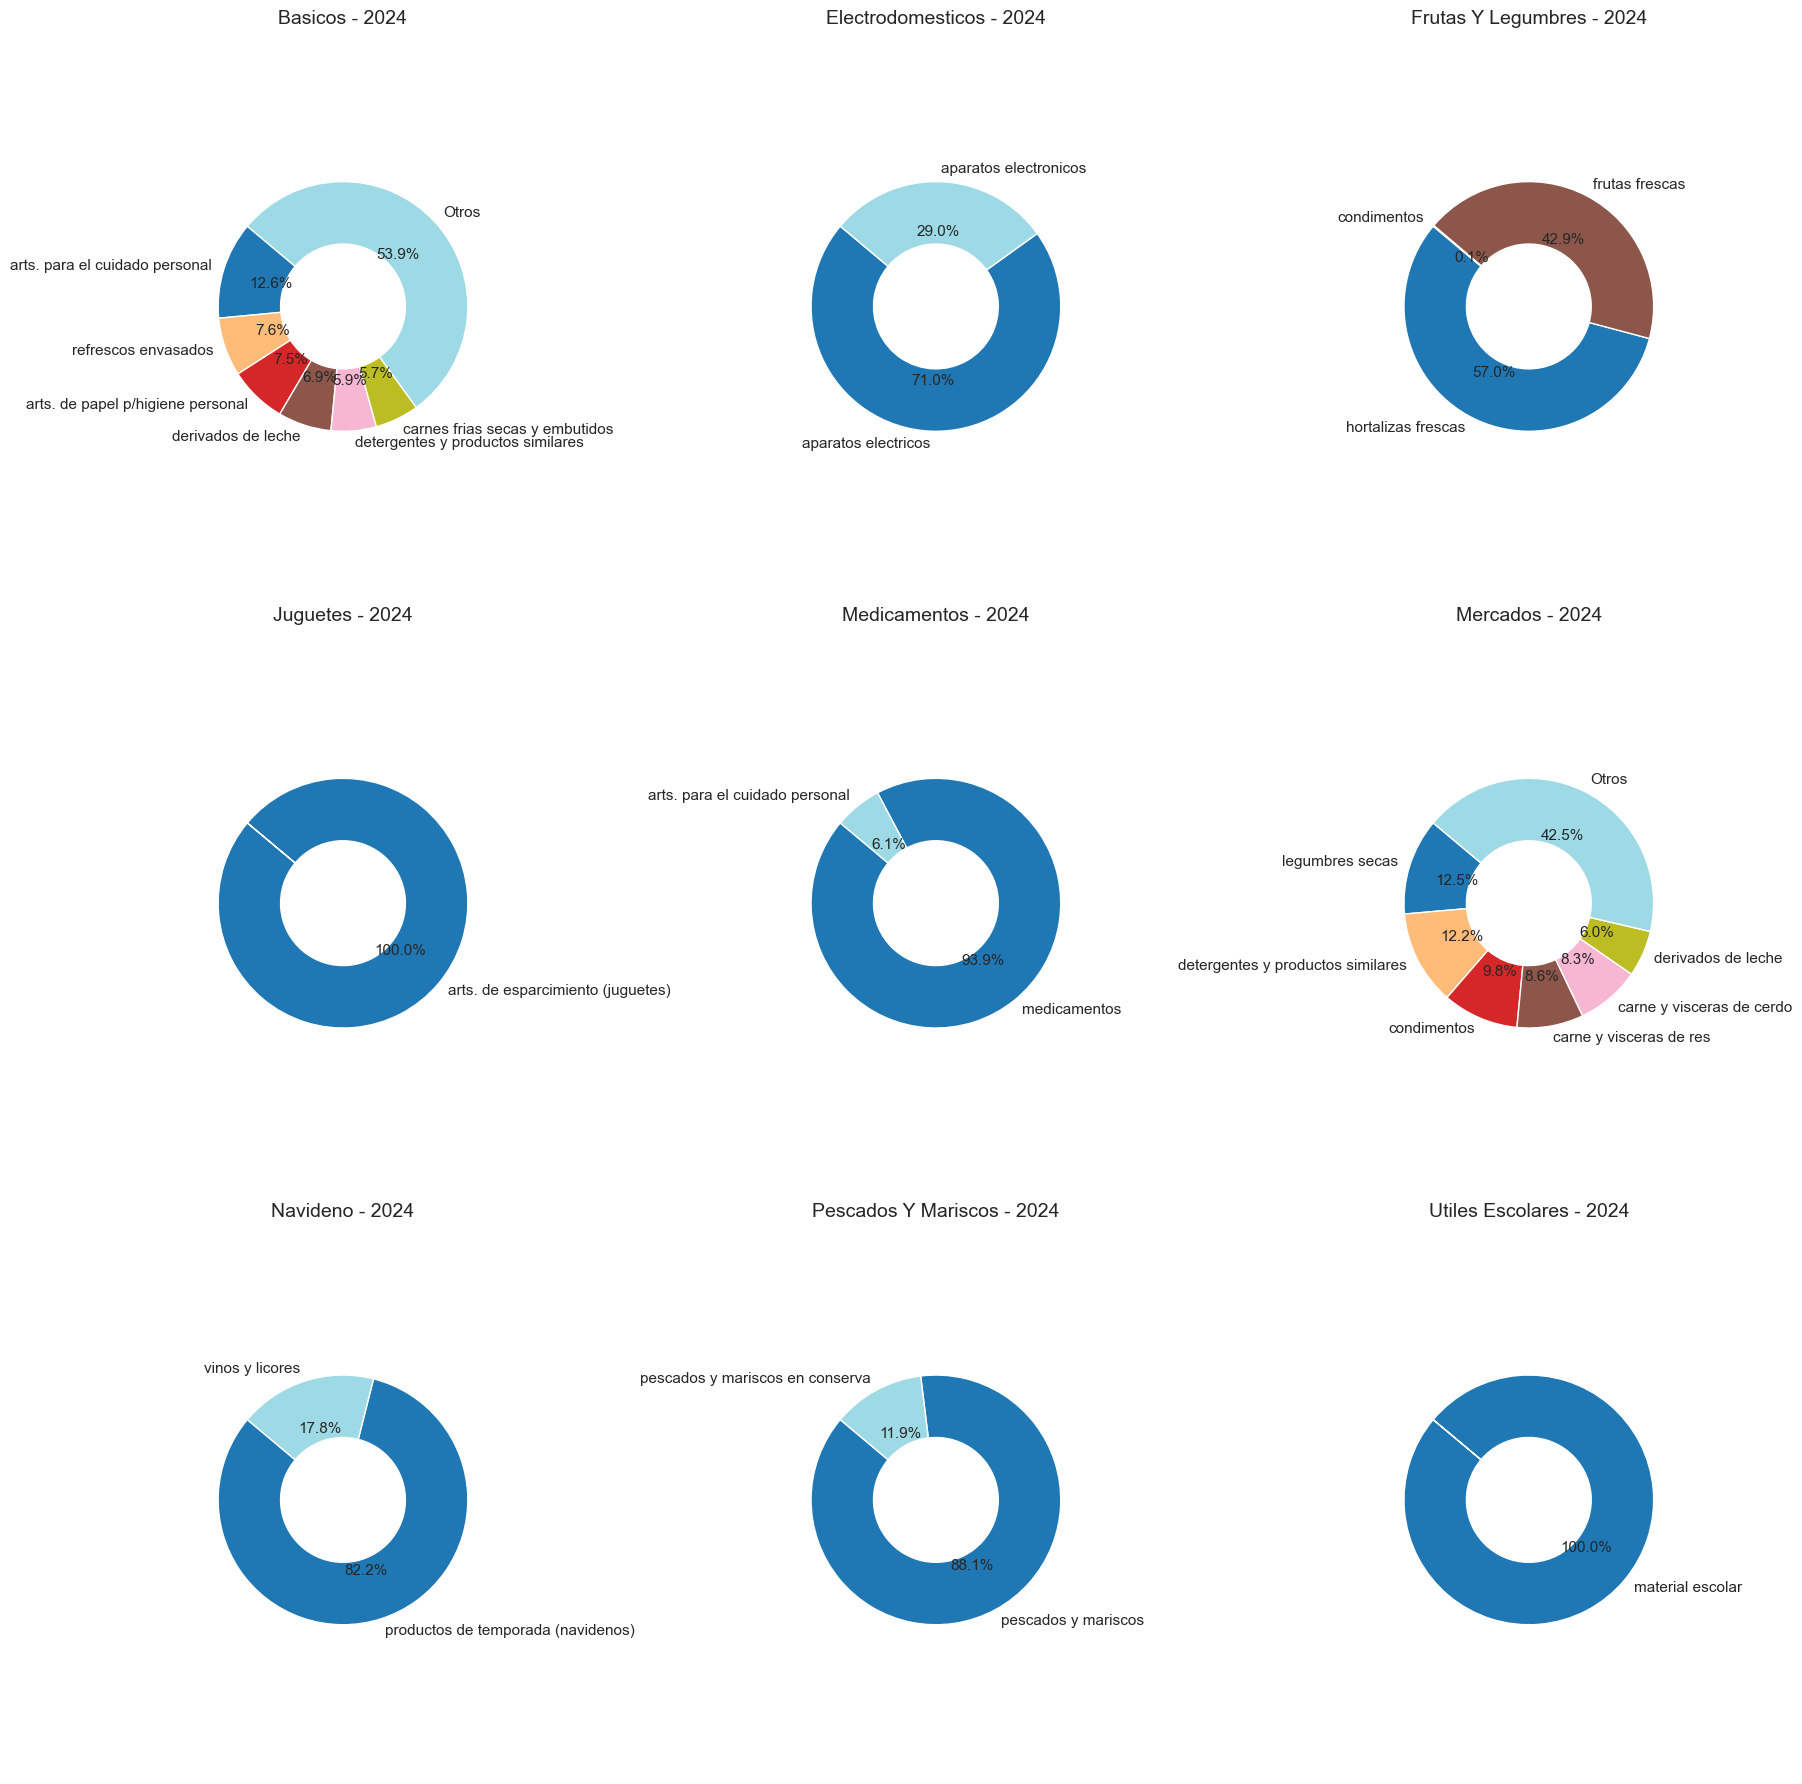

In [192]:
graficar_categorias_por_catalogo_con_otros(conteo_categoria_anio, anio_objetivo=2018, top_n=6)
graficar_categorias_por_catalogo_con_otros(conteo_categoria_anio, anio_objetivo=2019, top_n=6)
graficar_categorias_por_catalogo_con_otros(conteo_categoria_anio, anio_objetivo=2020, top_n=6)
graficar_categorias_por_catalogo_con_otros(conteo_categoria_anio, anio_objetivo=2021, top_n=6)
graficar_categorias_por_catalogo_con_otros(conteo_categoria_anio, anio_objetivo=2022, top_n=6)
graficar_categorias_por_catalogo_con_otros(conteo_categoria_anio, anio_objetivo=2023, top_n=6)
graficar_categorias_por_catalogo_con_otros(conteo_categoria_anio, anio_objetivo=2024, top_n=6)

. Productos dominantes por catálogo

-   En varios catálogos como Juguetes, Medicamentos, Útiles escolares y Pescados y Mariscos, un solo producto acapara el 100% de la participación año con año. Esto muestra que son categorías muy concentradas.


1. Básicos

    Muy diversa, pero artículos para el cuidado personal siempre están entre los más representativos (~13–14%).

    “Otros” concentra más del 50%, lo que sugiere una categoría amplia con muchas subcategorías menores.

    Participaciones de productos como refrescos, detergentes y lácteos se mantienen estables.


2. Electrodomésticos

    Solo dos subcategorías: aparatos eléctricos domina cada año (~65–71%) sobre aparatos electrónicos.

    Es una categoría muy estable en su composición año con año.


3. Frutas y legumbres
4. 
    Siempre lideran hortalizas frescas (~57%) y frutas frescas (~42%).

    Condimentos aparece con mínima participación (<1%), y es poco relevante dentro de este catálogo.

4. Juguetes

    Completamente dominado por arts. de esparcimiento (juguetes) al 100% cada año.

    No hay otras subcategorías registradas, lo que indica una estructura fija.

5. Medicamentos
 
    Igual que juguetes: completamente concentrado, con “medicamentos” representando el 100%.

    A partir de 2020, aparece una mínima proporción de arts. para el cuidado personal (~6%).

6. Mercados 
    
    Más variado, pero los productos principales como derivados de leche, carnes y legumbres se mantienen cada año.

    “Otros” siempre ocupa entre 42% y 46%, lo que indica muchas subcategorías con baja representación individual.

7. Navideño

    Muy concentrado en dos subcategorías: vinos y licores (~60%) y productos de temporada (navideños) (~30%).

    Estas proporciones se han mantenido con muy poca variación desde 2018 a 2024.


8. Pescados y mariscos

    Dominado por pescados y mariscos (~88–93%), con una pequeña participación de productos en conserva.

    Composición muy estable a lo largo del tiempo.

9. Útiles escolares

    100% material escolar todos los años.

    No hay diversidad dentro del catálogo, lo que lo hace extremadamente uniforme.